#Imports
All the imports required for the project are done at the begining.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
%matplotlib inline
sns.set_style('darkgrid')
init_notebook_mode(connected=True)
cf.go_offline()

#Data


In [2]:
data = pd.read_csv('train/train.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 211 entries, Id to Weight_Daily
dtypes: float64(209), int64(2)
memory usage: 64.4 MB


In [4]:
data.describe()

Id    Feature_1     Feature_2     Feature_3     Feature_4  \
count  40000.00000  6687.000000  30854.000000  38763.000000  32279.000000   
mean   20000.50000     3.590250     -0.117558      0.558392      0.405572   
std    11547.14972     2.798532      1.236250      0.902233      0.799082   
min        1.00000     1.000000     -3.440521     -4.643526     -5.440596   
25%    10000.75000     1.000000     -0.967186     -0.110192     -0.111696   
50%    20000.50000     3.000000     -0.389162      0.437228      0.403516   
75%    30000.25000     6.000000      0.414442      1.064754      0.945944   
max    40000.00000    10.000000      4.175150      4.530405      2.953163   

          Feature_5     Feature_6     Feature_7     Feature_8     Feature_9  \
count  40000.000000  38067.000000  40000.000000  39531.000000  38125.000000   
mean       5.482775      0.430972  49244.971525      0.196958     10.680289   
std        2.942324      1.498274  28242.409717      0.138485      2.850634   
min        1.000000     -0.936644    338.000000      0.009800      0.000000   
25%        2.000000     -0.265555  26143.000000      0.016600      9.000000   
50%        6.000000      0.055564  48457.000000      0.213800     11.000000   
75%        8.000000      0.559921  72387.000000      0.331800     12.000000   
max       10.000000     12.609885  99861.000000      0.365000     36.000000   

       ...       Ret_175       Ret_176       Ret_177       Ret_178  \
count  ...  40000.000000  4.000000e+04  4.000000e+04  4.000000e+04   
mean   ...      0.000049 -3.580980e-06 -9.675766e-06 -1.268935e-05   
std    ...      0.001115  1.166019e-03  1.248956e-03  1.217967e-03   
min    ...     -0.018048 -1.786752e-02 -3.526027e-02 -4.864099e-02   
25%    ...     -0.000316 -3.943210e-04 -4.091851e-04 -3.649676e-04   
50%    ...      0.000004 -4.039616e-07  4.016833e-07  6.407432e-07   
75%    ...      0.000407  3.820685e-04  4.172179e-04  3.750965e-04   
max    ...      0.020781  3.061460e-02  4.406460e-02  2.922928e-02   

            Ret_179       Ret_180   Ret_PlusOne   Ret_PlusTwo  \
count  40000.000000  40000.000000  40000.000000  40000.000000   
mean      -0.000017     -0.000057     -0.000210      0.000012   
std        0.001208      0.001270      0.025039      0.024160   
min       -0.037215     -0.058046     -0.627690     -0.450779   
25%       -0.000361     -0.000413     -0.010521     -0.010055   
50%        0.000001     -0.000002     -0.000258     -0.000258   
75%        0.000378      0.000364      0.010005      0.009772   
max        0.048221      0.026112      0.795602      0.303038   

       Weight_Intraday  Weight_Daily  
count     4.000000e+04  4.000000e+04  
mean      1.504600e+06  1.880750e+06  
std       2.059143e+05  2.573928e+05  
min       1.000035e+06  1.250044e+06  
25%       1.357070e+06  1.696337e+06  
50%       1.477713e+06  1.847142e+06  
75%       1.624389e+06  2.030486e+06  
max       2.761229e+06  3.451536e+06  

[8 rows x 211 columns]

Seperate lists of column names are made for easier manipulation of the columns
1. feat: list of features
2. ret_agg_label: list of intra-day results from Ret_2 to Ret_120
3. ret_agg_target: list of intra-day results from Ret_121 to Ret_180


In [5]:
feat =[]            
for f in range(1,26):
    feat.append(f'Feature_{f}')
    

In [6]:
ret_agg_label=[]
for f in range(2,121):
    ret_agg_label.append(f'Ret_{f}')
ret_agg_target=[]
for f in range(121,181):
    ret_agg_target.append(f'Ret_{f}')

To make the problem simpler, the intraday returns are aggregated as sum and standard deviation for both features (Ret_2 to Ret_120) and target labels (Ret_121 to Ret_180)

Standard deviation of the interday returns is also considered to see how much the returns vary.

In [7]:
data['RetAgg_sum_label']=data[ret_agg_label].sum(axis=1)
data['RetAgg_std_label']=data[ret_agg_label].std(axis=1)
data['Ret_std_label']=data[['Ret_MinusOne','Ret_MinusTwo','RetAgg_sum_label']].std(axis=1)
data['RetAgg_sum_target']=data[ret_agg_target].sum(axis=1)
data['RetAgg_std_target']=data[ret_agg_target].std(axis=1)
data['Ret_std_target']=data[['Ret_PlusOne','Ret_PlusTwo','RetAgg_sum_target']].std(axis=1)

In [8]:
data.drop(columns=ret_agg_label+ret_agg_target, axis=1, inplace=True)

In [9]:
data[feat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 25 columns):
Feature_1     6687 non-null float64
Feature_2     30854 non-null float64
Feature_3     38763 non-null float64
Feature_4     32279 non-null float64
Feature_5     40000 non-null float64
Feature_6     38067 non-null float64
Feature_7     40000 non-null int64
Feature_8     39531 non-null float64
Feature_9     38125 non-null float64
Feature_10    20529 non-null float64
Feature_11    39013 non-null float64
Feature_12    38904 non-null float64
Feature_13    39406 non-null float64
Feature_14    39272 non-null float64
Feature_15    37859 non-null float64
Feature_16    39390 non-null float64
Feature_17    39354 non-null float64
Feature_18    39432 non-null float64
Feature_19    38810 non-null float64
Feature_20    32174 non-null float64
Feature_21    38982 non-null float64
Feature_22    38655 non-null float64
Feature_23    38289 non-null float64
Feature_24    39274 non-null float64
Featur

In [10]:
data.head()

Id  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   1        NaN        NaN        NaN        NaN        8.0        NaN   
1   2        NaN        NaN        NaN        NaN        3.0   0.388896   
2   3        NaN  -0.696727   0.739591  -0.167928        9.0   0.471947   
3   4        NaN  -0.694350   1.568248   0.479073        5.0   0.120653   
4   5        6.0  -1.736489   2.765531   1.245280        7.0   4.866985   

   Feature_7  Feature_8  Feature_9  ...  Ret_PlusOne  Ret_PlusTwo  \
0      75751     0.2254       11.0  ...    -0.019512     0.028846   
1      17369     0.0166       13.0  ...    -0.002939    -0.010253   
2       8277     0.3650        9.0  ...    -0.024791     0.015711   
3      22508     0.2654       13.0  ...    -0.005680    -0.002190   
4      22423     0.2138       13.0  ...     0.036104    -0.026552   

   Weight_Intraday  Weight_Daily  RetAgg_sum_label  RetAgg_std_label  \
0     1.251508e+06  1.564385e+06         -0.025248          0.000826   
1     1.733950e+06  2.167438e+06         -0.008142          0.000364   
2     1.529197e+06  1.911497e+06         -0.000633          0.000525   
3     1.711569e+06  2.139462e+06          0.001276          0.000294   
4     1.267270e+06  1.584088e+06         -0.002293          0.000832   

   Ret_std_label  RetAgg_sum_target  RetAgg_std_target  Ret_std_target  
0       0.042925           0.000083           0.001388        0.024324  
1       0.009033           0.001087           0.000345        0.005749  
2       0.003411          -0.000796           0.000419        0.020366  
3       0.007493           0.000331           0.000253        0.003019  
4       0.014664           0.003667           0.000869        0.031334  

[5 rows x 38 columns]

Since the fetaures are all numeric in nature. In order to differentiate between the categorical and continous features, percentage of unique values and imbalance is calculated for each of the featues. 

In [11]:
for col in data.columns:
    if (len(data[col].unique())/400)<5:
        print(col+'\t'+str(len(data[col].unique())/400)+'\t'+str(len(data[col].unique()))+'\t'+str(data[col].value_counts().values[0])+'\t'+str(data[col].value_counts().values[0]/400)+'\t'+str(data[col].isnull().sum()/400))

Feature_1	0.0275	11	2651	6.6275	83.2825
Feature_5	0.025	10	6943	17.3575	0.0
Feature_7	2.06	824	114	0.285	0.0
Feature_8	0.0825	33	4178	10.445	1.1725
Feature_9	0.0925	37	5863	14.6575	4.6875
Feature_10	0.0175	7	14437	36.0925	48.6775
Feature_12	0.255	102	1596	3.99	2.74
Feature_13	0.0275	11	4715	11.7875	1.485
Feature_15	2.3025	921	61	0.1525	5.3525
Feature_16	0.0075	3	39100	97.75	1.525
Feature_20	0.025	10	7008	17.52	19.565


Since Feature_1 and Feature_10 have high number of missing values, and Feature_16 is highly imbalanced, these features can not be used for training the model as imputting such large amounts of data can create bias.

In [12]:
drop_feat = ['Feature_1', 'Feature_10', 'Feature_16']

In [13]:
categorical = ['Feature_5', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_12', 'Feature_13', 'Feature_15', 'Feature_20']

In [14]:
numerical = ['Feature_2', 'Feature_3', 'Feature_4', 'Feature_6',
             'Feature_11', 'Feature_12', 'Feature_14', 'Feature_17',
             'Feature_18', 'Feature_19','Feature_21', 'Feature_22',
             'Feature_23', 'Feature_24', 'Feature_25']

Now, all the categorical features are of float data type. It is Important to differentiate between the integer features and the float type features, thus here we are manually examining the values in order to identify the integer type features.

In [15]:
for cat in categorical:
    print(cat,data[cat].dropna().unique())

Feature_5 [ 8.  3.  9.  5.  7.  1.  2. 10.  4.  6.]
Feature_7 [75751 17369  8277 22508 22423 24099 39351 92214 18418 47637 51499 79888
 63267 35023 76131 69564 94022 16080 14259 65146 47683 35266 49660 57773
 34161 64351 19660 94975 99483 40712 62488 56152 10016  5064 88794 17103
 97667 26216 87426 84543 41301 32724 18907 26896 56379 29650 45523  3028
 70376  1013 34983 25571 44322 43382 48456 86314 22794  5850 25144 85952
 90379 89151 21635 53301 25498 56222 64320 96569 11442 75099 68528   338
 56547 31857 37410 88973 47550 63238 59401 10426 99861 82176 31534 83855
 38839 67409 10311 53489 53371  5896 48135 21016 14939 35971 71785 56348
 41948 27661 68443 95920 36818 67692 48918  4639 82574 78437 76464 59828
 48016 79444 97375 56690 36905 29815 82641 50022 58032 58878 86137 91929
   638 71484 85050  2441 43138 83707 27912 50443 73026 57841 87448 88655
  1913 15416 14653 62140 61693 16814 35872  9989 81535 39365 85154 69920
 40980 75116 61543  3349  1344 16234 86947 96321 85777 23907 4

In [16]:
cat_int = ['Feature_5', 'Feature_9', 'Feature_13', 'Feature_20']

A heatmap is generated to identify to what extent are the features correlated to each other.

In [17]:
cor = data[feat].drop(columns=drop_feat, axis=1).corr()

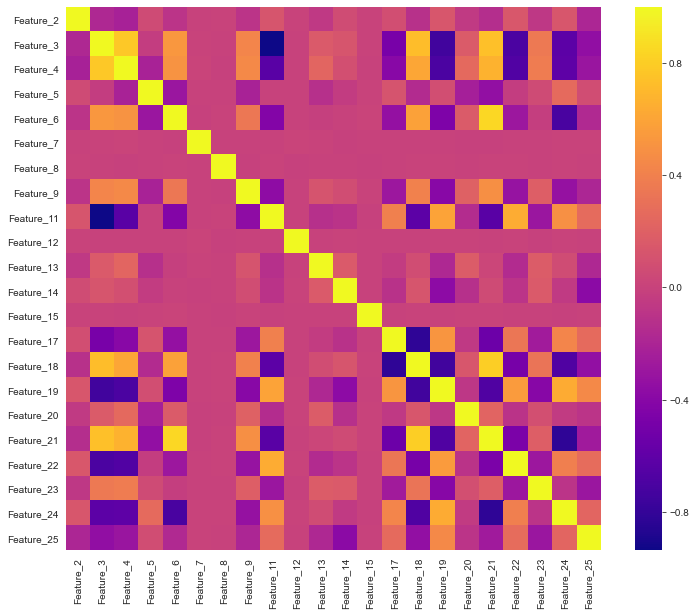

In [18]:
plt.figure(figsize=(12,10))
sns.heatmap(cor, cmap='plasma')

To handle missing data, Iterative Imputer is used for both categorical and numerical features.

In [19]:
iter_cat = IterativeImputer(initial_strategy='constant', verbose=3)

In [20]:
data[categorical]= iter_cat.fit_transform(data[categorical])

[IterativeImputer] Completing matrix with shape (40000, 8)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.12
[IterativeImputer] Early stopping criterion reached.


In [21]:
data[cat_int] = data[cat_int].astype('int64')

In [22]:
iter_num = IterativeImputer(initial_strategy='median', verbose=3)

In [23]:
data[numerical] = iter_num.fit_transform(data[numerical])

[IterativeImputer] Completing matrix with shape (40000, 15)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.55
[IterativeImputer] Ending imputation round 2/10, elapsed time 1.10
[IterativeImputer] Ending imputation round 3/10, elapsed time 1.69
[IterativeImputer] Ending imputation round 4/10, elapsed time 2.23
[IterativeImputer] Ending imputation round 5/10, elapsed time 2.77
[IterativeImputer] Ending imputation round 6/10, elapsed time 3.30
[IterativeImputer] Ending imputation round 7/10, elapsed time 3.83
[IterativeImputer] Ending imputation round 8/10, elapsed time 4.37
[IterativeImputer] Ending imputation round 9/10, elapsed time 4.91
[IterativeImputer] Ending imputation round 10/10, elapsed time 5.43


C:\Users\Parth Chawla\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



In [24]:
data.drop(columns=drop_feat, axis=1, inplace=True)

#Dimensionality Reduction
In order to extract the most usefull features, Principal Component Analysis is carried out and the feature columns are transformed into a new set of features with lesser number of columns.
 

In [25]:
mms = MinMaxScaler(feature_range=(0,1))
data[numerical] = mms.fit_transform(data[numerical]) 

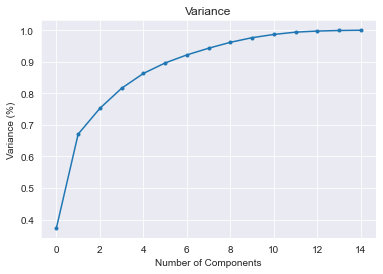

In [26]:
pca = PCA()
pca.fit(data[numerical])
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='.')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Variance')
plt.show()

In [27]:
pca = PCA(n_components=12)
df=pca.fit_transform(data[numerical])

The new set of features are saved in a pandas dataframe


In [28]:
df = pd.DataFrame(df)

In [29]:
df

0         1         2         3         4         5         6  \
0      0.005850 -0.123371 -0.057070 -0.019511 -0.009305  0.036729 -0.031849   
1     -0.213369 -0.088642 -0.084217 -0.008957 -0.024826 -0.050265  0.072512   
2      0.470503  0.080107 -0.057380  0.009514 -0.232782 -0.047030 -0.001359   
3      0.503563  0.260729  0.019781 -0.136686  0.061070 -0.002712 -0.003856   
4     -0.467395  0.123935  0.686349  0.217782  0.120302 -0.221212  0.047178   
...         ...       ...       ...       ...       ...       ...       ...   
39995 -0.333826 -0.051190  0.091730  0.517427 -0.068369  0.394538 -0.125416   
39996 -0.460111 -0.425764 -0.024549  0.088336  0.081101  0.021988  0.143157   
39997  0.238613 -0.497874 -0.074069  0.093729 -0.058775  0.017294  0.002302   
39998 -0.468430  0.165441 -0.054343 -0.013698 -0.044419 -0.036902 -0.045966   
39999 -0.141599 -0.505332 -0.075188  0.027756  0.091559 -0.049294  0.098760   

              7         8         9        10        11  
0      0.021456  0.005710  0.050687 -0.019115 -0.012544  
1      0.048066 -0.064020  0.079960  0.079077 -0.005386  
2      0.048313 -0.034074  0.018788 -0.024777  0.046409  
3      0.034320 -0.038384  0.012490 -0.045038  0.058922  
4      0.478929  0.790423 -0.172896 -0.008796  0.049667  
...         ...       ...       ...       ...       ...  
39995  0.188275 -0.107662 -0.084407 -0.034189 -0.062113  
39996  0.045568 -0.027854  0.010146 -0.048013 -0.055340  
39997  0.025364 -0.009964  0.037942 -0.067640  0.005750  
39998  0.030507 -0.009336  0.047350  0.086716 -0.010492  
39999  0.015367 -0.012948  0.041528  0.015641 -0.023828  

[40000 rows x 12 columns]

In [30]:
for col in categorical:
    df[col] = data[col].apply(lambda x: "{0:.4f}".format(x))

In [31]:
df[categorical] = df[categorical].astype('category')

In [32]:
ret = ['Ret_MinusTwo', 'Ret_MinusOne',
       'Ret_PlusOne', 'Ret_PlusTwo', 'RetAgg_sum_label', 'RetAgg_std_label', 'Ret_std_label',
       'RetAgg_sum_target', 'RetAgg_std_target', 'Ret_std_target']
df[ret] = data[ret]

After adding the categorical features and the intra-day and inter-day values, df is the resultant dataframe with all the required features and target labels.  

In [33]:
df.columns

Index([                  0,                   1,                   2,
                         3,                   4,                   5,
                         6,                   7,                   8,
                         9,                  10,                  11,
               'Feature_5',         'Feature_7',         'Feature_8',
               'Feature_9',        'Feature_12',        'Feature_13',
              'Feature_15',        'Feature_20',      'Ret_MinusTwo',
            'Ret_MinusOne',       'Ret_PlusOne',       'Ret_PlusTwo',
        'RetAgg_sum_label',  'RetAgg_std_label',     'Ret_std_label',
       'RetAgg_sum_target', 'RetAgg_std_target',    'Ret_std_target'],
      dtype='object')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 30 columns):
0                    40000 non-null float64
1                    40000 non-null float64
2                    40000 non-null float64
3                    40000 non-null float64
4                    40000 non-null float64
5                    40000 non-null float64
6                    40000 non-null float64
7                    40000 non-null float64
8                    40000 non-null float64
9                    40000 non-null float64
10                   40000 non-null float64
11                   40000 non-null float64
Feature_5            40000 non-null category
Feature_7            40000 non-null category
Feature_8            40000 non-null category
Feature_9            40000 non-null category
Feature_12           40000 non-null category
Feature_13           40000 non-null category
Feature_15           40000 non-null category
Feature_20           40000 non-null category
Ret

Categorical data is encoded using pandas get_dummies encoder in order to make it easier for the model to read categorical data. 

In [35]:
cat_enc = pd.get_dummies(df[categorical], drop_first=True)

In [36]:
pca_df = df.iloc[:,:12]
enc_data = pca_df.join(cat_enc)
enc_data[ret] = data[ret]

In [37]:
enc_data.shape

(40000, 2989)

In [38]:
targets = ['Ret_PlusOne', 'Ret_PlusTwo', 'RetAgg_sum_target', 'RetAgg_std_target', 'Ret_std_target']

#Train Test Split
Here we are applying train test split twice in order to create a "hold out" set (X1, y1) for final testing of our model.

In [39]:
X,X1,y,y1 = train_test_split(enc_data.drop(columns=targets, axis=1), enc_data[targets], test_size=0.1, random_state=101)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=101)

#Regression Models
The two estimator models used for this project are **Random Forest Regressor** and **Multi Layer Perceptron Regressor (MLPReggresor)**.
Since the problem statement dictates us to predict multiple values, **MultiOutputRegressor** is used. 


In [41]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=8, verbose=3)
mor2 = MultiOutputRegressor(rfr)

In [42]:
mor2.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100


KeyboardInterrupt: 

In [ ]:
pickle.dump(mor2,open('mor_rfr.sav', 'wb'))

In [ ]:
mlp = MLPRegressor(batch_size=256, max_iter=300, learning_rate='adaptive',verbose=True, early_stopping=True)
mor1 = MultiOutputRegressor(mlp)

In [ ]:
mor1.fit(X_train, y_train)

In [0]:
pickle.dump(mor1,open('mor_mlp.sav', 'wb'))

In [43]:
mor_mlp = pickle.load(open('mor_mlp.sav', 'rb'))

In [44]:
mor_rfr = pickle.load(open('mor_rfr.sav', 'rb'))

Predicting values of the test set

In [45]:
y_pred_mlp = mor_mlp.predict(X_test)

In [46]:
y_pred_rfr = mor_rfr.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

#Metrics Used
The metrics used for initial evaluation of the models are **Mean Squared Error** and **Mean Absolute Error**.



In [47]:
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
mse_rfr

0.000272433188540767

In [48]:
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
mae_rfr

0.008455844657590946

In [49]:
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
mse_mlp

0.00025713705575859447

In [50]:
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mae_mlp

0.008801409625236439

#Visual Analysis
Not much can be inferred about the model performance just by looking at the error values, thus line graphs of the model predictions and the actual label values are plotted on the same graph. 

In [51]:
y_pred_mlp_df=pd.DataFrame(y_pred_mlp, columns=targets)
y_pred_rfr_df=pd.DataFrame(y_pred_rfr, columns=targets)

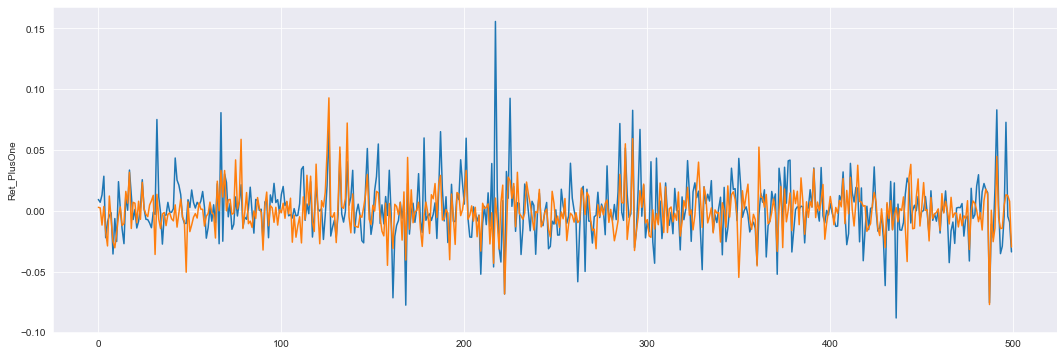

In [52]:
plt.figure(figsize=(18,6))
sns.lineplot(x=range(0,500), y=y_test["Ret_PlusOne"].head(500))
sns.lineplot(x=range(0,500), y=y_pred_mlp_df["Ret_PlusOne"].head(500))

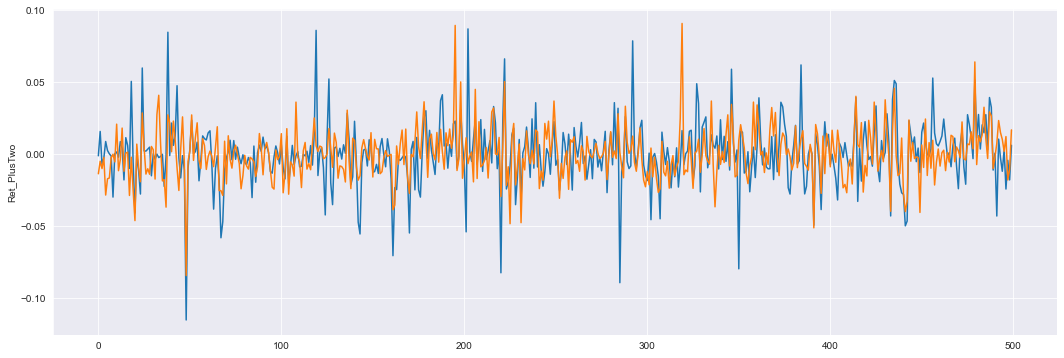

In [53]:
plt.figure(figsize=(18,6))
sns.lineplot(x=range(0,500), y=y_test["Ret_PlusTwo"].head(500))
sns.lineplot(x=range(0,500), y=y_pred_mlp_df["Ret_PlusTwo"].head(500))

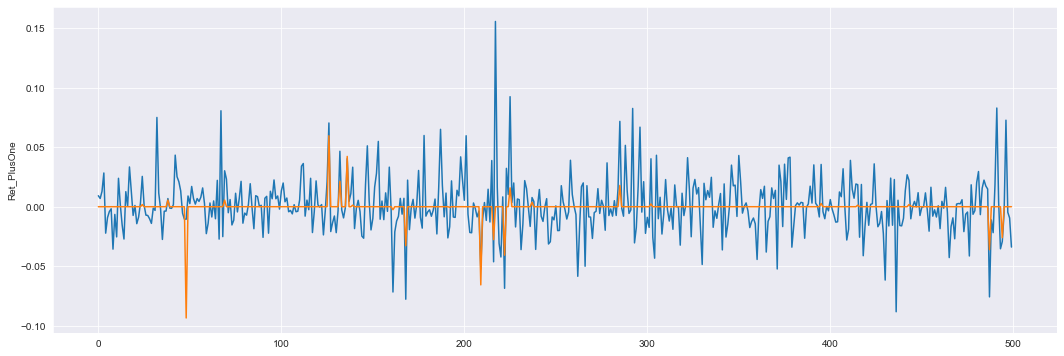

In [54]:
plt.figure(figsize=(18,6))
sns.lineplot(x=range(0,500), y=y_test["Ret_PlusOne"].head(500))
sns.lineplot(x=range(0,500), y=y_pred_rfr_df["Ret_PlusOne"].head(500))

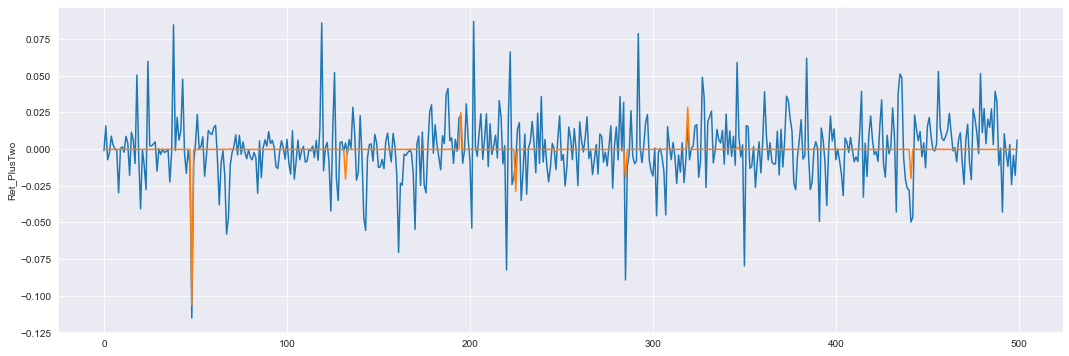

In [55]:
plt.figure(figsize=(18,6))
sns.lineplot(x=range(0,500), y=y_test["Ret_PlusTwo"].head(500))
sns.lineplot(x=range(0,500), y=y_pred_rfr_df["Ret_PlusTwo"].head(500))

Taking a closer look

C:\Users\Parth Chawla\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x0000017242ADEE08> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists



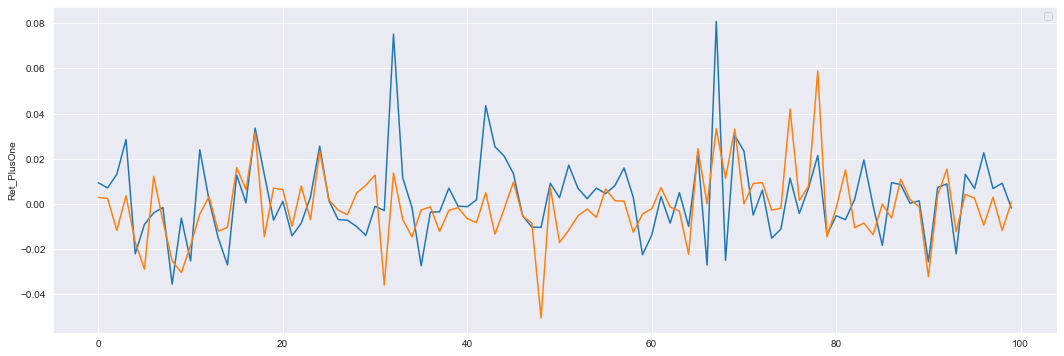

In [80]:
plt.figure(figsize=(18,6))
sns.lineplot(x=range(0,100), y=y_test["Ret_PlusOne"].head(100))
sns.lineplot(x=range(0,100), y=y_pred_mlp_df["Ret_PlusOne"].head(100))

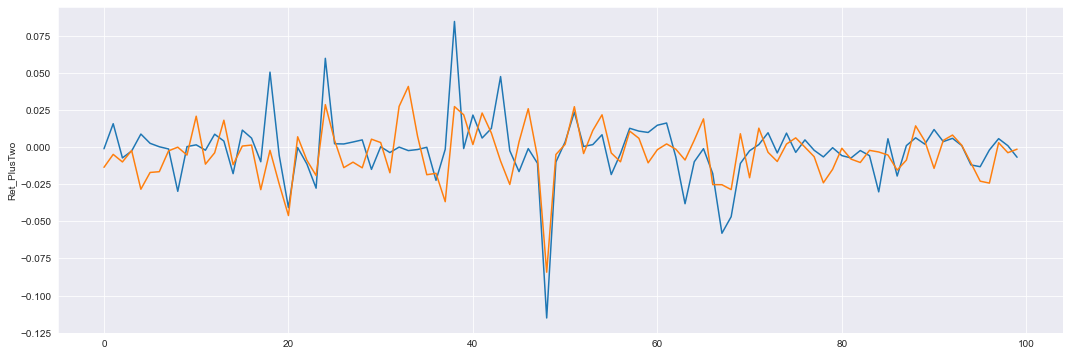

In [57]:
plt.figure(figsize=(18,6))
sns.lineplot(x=range(0,100), y=y_test["Ret_PlusTwo"].head(100))
sns.lineplot(x=range(0,100), y=y_pred_mlp_df["Ret_PlusTwo"].head(100))

It can be clearly inferred that the Random Forest Regressor model is **not** predicting correct values and the MLPRegressor is doing a better job at predicting the required values.

#Hyperparameter Tuning
To **improve** the performance of the MLPRegressor MultiOutputRegressor even further, GridSearchCV is used for fine tuning of the model.

In [0]:
parameter_space = {
    'estimator__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'estimator__activation': ['tanh', 'relu'],
    'estimator__alpha': [0.0001, 0.001, 0.01],
}

In [0]:
gcv = GridSearchCV(MultiOutputRegressor(MLPRegressor(early_stopping=True ,learning_rate='adaptive', verbose=True,
                                                     max_iter=1000, solver='adam')), 
                   param_grid= parameter_space, 
                   verbose=3, 
                   cv=5)

In [0]:
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] estimator__activation=tanh, estimator__alpha=0.0001, estimator__hidden_layer_sizes=(50, 50, 50) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Iteration 1, loss = 0.00594337
Validation score: -0.204524
Iteration 2, loss = 0.00031065
Validation score: 0.145618
Iteration 3, loss = 0.00026072
Validation score: 0.192307
Iteration 4, loss = 0.00025055
Validation score: 0.194452
Iteration 5, loss = 0.00024744
Validation score: 0.186697
Iteration 6, loss = 0.00024470
Validation score: 0.216316
Iteration 7, loss = 0.00024173
Validation score: 0.204126
Iteration 8, loss = 0.00023801
Validation score: 0.207682
Iteration 9, loss = 0.00023434
Validation score: 0.210080
Iteration 10, loss = 0.00023221
Validation score: 0.199945
Iteration 11, loss = 0.00023058
Validation score: 0.206721
Iteration 12, loss = 0.00022836
Validation score: 0.217811
Iteration 13, loss = 0.00022357
Validation score: 0.196955
Iteration 14, loss = 0.00022270
Validation score: 0.212593
Iteration 15, loss = 0.00021973
Validation score: 0.208340
Iteration 16, loss = 0.00021782
Validation score: 0.224531
Iteration 17, loss = 0.00021249
Validation score: 0.183796
Itera

Iteration 21, loss = 0.00008800
Validation score: 0.337238
Iteration 22, loss = 0.00008800
Validation score: 0.327845
Iteration 23, loss = 0.00008531
Validation score: 0.332895
Iteration 24, loss = 0.00008340
Validation score: 0.297535
Iteration 25, loss = 0.00008134
Validation score: 0.304202
Iteration 26, loss = 0.00007869
Validation score: 0.296360
Iteration 27, loss = 0.00007735
Validation score: 0.310945
Iteration 28, loss = 0.00007696
Validation score: 0.301766
Iteration 29, loss = 0.00007547
Validation score: 0.301989
Iteration 30, loss = 0.00007292
Validation score: 0.267549
Iteration 31, loss = 0.00007402
Validation score: 0.238699
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
[CV]  estimator__activation=tanh, estimator__alpha=0.0001, estimator__hidden_layer_sizes=(50, 50, 50), score=0.266, total= 4.2min
[CV] estimator__activation=tanh, estimator__alpha=0.0001, estimator__hidden_layer_sizes=(50, 50, 50) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min remaining:    0.0s


Iteration 1, loss = 0.00074839
Validation score: 0.208856
Iteration 2, loss = 0.00027109
Validation score: 0.243455
Iteration 3, loss = 0.00025780
Validation score: 0.262933
Iteration 4, loss = 0.00025111
Validation score: 0.218224
Iteration 5, loss = 0.00024458
Validation score: 0.234780
Iteration 6, loss = 0.00023768
Validation score: 0.264164
Iteration 7, loss = 0.00023425
Validation score: 0.245882
Iteration 8, loss = 0.00022669
Validation score: 0.273493
Iteration 9, loss = 0.00021463
Validation score: 0.244695
Iteration 10, loss = 0.00020806
Validation score: 0.230889
Iteration 11, loss = 0.00019772
Validation score: 0.177416
Iteration 12, loss = 0.00019140
Validation score: 0.162430
Iteration 13, loss = 0.00018211
Validation score: 0.105362
Iteration 14, loss = 0.00018049
Validation score: 0.158938
Iteration 15, loss = 0.00016602
Validation score: 0.166983
Iteration 16, loss = 0.00015976
Validation score: 0.118195
Iteration 17, loss = 0.00015286
Validation score: 0.108656
Iterat

Iteration 18, loss = 0.00008820
Validation score: 0.312536
Iteration 19, loss = 0.00008622
Validation score: 0.276397
Iteration 20, loss = 0.00008442
Validation score: 0.307375
Iteration 21, loss = 0.00008290
Validation score: 0.303705
Iteration 22, loss = 0.00008109
Validation score: 0.306477
Iteration 23, loss = 0.00008031
Validation score: 0.257954
Iteration 24, loss = 0.00007923
Validation score: 0.054455
Iteration 25, loss = 0.00007789
Validation score: 0.257340
Iteration 26, loss = 0.00007603
Validation score: 0.273977
Iteration 27, loss = 0.00007415
Validation score: 0.273464
Iteration 28, loss = 0.00007255
Validation score: 0.228459
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
[CV]  estimator__activation=tanh, estimator__alpha=0.0001, estimator__hidden_layer_sizes=(50, 50, 50), score=0.251, total= 4.5min
[CV] estimator__activation=tanh, estimator__alpha=0.0001, estimator__hidden_layer_sizes=(50, 50, 50) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.7min remaining:    0.0s


Iteration 1, loss = 0.00111908
Validation score: 0.190938
Iteration 2, loss = 0.00025713
Validation score: 0.264972
Iteration 3, loss = 0.00024113
Validation score: 0.241024
Iteration 4, loss = 0.00023794
Validation score: 0.230120
Iteration 5, loss = 0.00023112
Validation score: 0.271002
Iteration 6, loss = 0.00022410
Validation score: 0.269104
Iteration 7, loss = 0.00022123
Validation score: 0.261183
Iteration 8, loss = 0.00022026
Validation score: 0.233505
Iteration 9, loss = 0.00021588
Validation score: 0.265152
Iteration 10, loss = 0.00020970
Validation score: 0.275986
Iteration 11, loss = 0.00020419
Validation score: 0.260211
Iteration 12, loss = 0.00019898
Validation score: 0.264103
Iteration 13, loss = 0.00019113
Validation score: 0.234939
Iteration 14, loss = 0.00018260
Validation score: 0.225038
Iteration 15, loss = 0.00017911
Validation score: 0.163424
Iteration 16, loss = 0.00017126
Validation score: 0.094025
Iteration 17, loss = 0.00016373
Validation score: 0.181820
Iterat

Iteration 43, loss = 0.00002775
Validation score: -0.926662
Iteration 44, loss = 0.00002741
Validation score: -0.906539
Iteration 45, loss = 0.00002697
Validation score: -0.958978
Iteration 46, loss = 0.00002659
Validation score: -0.667823
Iteration 47, loss = 0.00002620
Validation score: -0.685041
Iteration 48, loss = 0.00002580
Validation score: -0.660240
Iteration 49, loss = 0.00002545
Validation score: -0.441476
Iteration 50, loss = 0.00002506
Validation score: -0.391807
Iteration 51, loss = 0.00002476
Validation score: -0.360336
Iteration 52, loss = 0.00002437
Validation score: -0.548580
Iteration 53, loss = 0.00002400
Validation score: -0.245454
Iteration 54, loss = 0.00002366
Validation score: -1.333700
Iteration 55, loss = 0.00002340
Validation score: -0.592006
Iteration 56, loss = 0.00002299
Validation score: -0.137488
Iteration 57, loss = 0.00002265
Validation score: -1.849712
Iteration 58, loss = 0.00002237
Validation score: -0.024897
Iteration 59, loss = 0.00002197
Validati

Iteration 10, loss = 0.00003498
Validation score: -1.230545
Iteration 11, loss = 0.00003402
Validation score: -0.750911
Iteration 12, loss = 0.00003298
Validation score: -0.644223
Iteration 13, loss = 0.00003209
Validation score: -0.724861
Iteration 14, loss = 0.00003128
Validation score: -0.618246
Iteration 15, loss = 0.00003051
Validation score: -2.044057
Iteration 16, loss = 0.00002989
Validation score: -0.477769
Iteration 17, loss = 0.00002926
Validation score: -1.055914
Iteration 18, loss = 0.00002985
Validation score: -5.816895
Iteration 19, loss = 0.00002907
Validation score: -8.406323
Iteration 20, loss = 0.00002767
Validation score: -1.099472
Iteration 21, loss = 0.00002758
Validation score: -0.441668
Iteration 22, loss = 0.00002690
Validation score: -9.133532
Iteration 23, loss = 0.00002603
Validation score: -0.991899
Iteration 24, loss = 0.00002634
Validation score: -0.461077
Iteration 25, loss = 0.00002582
Validation score: 0.118959
Iteration 26, loss = 0.00002372
Validatio

Iteration 5, loss = 0.00004207
Validation score: -2.713074
Iteration 6, loss = 0.00004088
Validation score: -2.415516
Iteration 7, loss = 0.00003969
Validation score: -2.084570
Iteration 8, loss = 0.00003869
Validation score: -1.790851
Iteration 9, loss = 0.00003762
Validation score: -1.678987
Iteration 10, loss = 0.00003686
Validation score: -1.897673
Iteration 11, loss = 0.00003595
Validation score: -1.705185
Iteration 12, loss = 0.00003488
Validation score: -1.976511
Iteration 13, loss = 0.00003444
Validation score: -1.190607
Iteration 14, loss = 0.00003338
Validation score: -0.848769
Iteration 15, loss = 0.00003252
Validation score: -0.480668
Iteration 16, loss = 0.00003185
Validation score: -0.429977
Iteration 17, loss = 0.00003150
Validation score: -1.460802
Iteration 18, loss = 0.00003183
Validation score: -1.499911
Iteration 19, loss = 0.00003044
Validation score: -0.849441
Iteration 20, loss = 0.00003197
Validation score: -24.980169
Iteration 21, loss = 0.00002977
Validation s

Iteration 18, loss = 0.00005761
Validation score: -0.323847
Iteration 19, loss = 0.00006294
Validation score: 0.101128
Iteration 20, loss = 0.00005665
Validation score: 0.138462
Iteration 21, loss = 0.00005632
Validation score: 0.109718
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00365443
Validation score: -247.984466
Iteration 2, loss = 0.00008541
Validation score: -58.783425
Iteration 3, loss = 0.00006167
Validation score: -23.829670
Iteration 4, loss = 0.00005590
Validation score: -12.981342
Iteration 5, loss = 0.00005350
Validation score: -8.527938
Iteration 6, loss = 0.00005207
Validation score: -6.313806
Iteration 7, loss = 0.00005104
Validation score: -5.244083
Iteration 8, loss = 0.00005015
Validation score: -4.341963
Iteration 9, loss = 0.00004939
Validation score: -3.768725
Iteration 10, loss = 0.00004868
Validation score: -3.315728
Iteration 11, loss = 0.00004799
Validation score: -3.087897
Iteration 12, 

Iteration 17, loss = 0.00019976
Validation score: 0.078470
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00060258
Validation score: 0.067661
Iteration 2, loss = 0.00008290
Validation score: 0.216127
Iteration 3, loss = 0.00007549
Validation score: 0.333796
Iteration 4, loss = 0.00007176
Validation score: 0.348035
Iteration 5, loss = 0.00006947
Validation score: 0.340199
Iteration 6, loss = 0.00006868
Validation score: 0.357909
Iteration 7, loss = 0.00006753
Validation score: 0.375535
Iteration 8, loss = 0.00006653
Validation score: 0.348561
Iteration 9, loss = 0.00006575
Validation score: 0.151076
Iteration 10, loss = 0.00006545
Validation score: 0.372337
Iteration 11, loss = 0.00006547
Validation score: 0.370431
Iteration 12, loss = 0.00006382
Validation score: 0.372775
Iteration 13, loss = 0.00006201
Validation score: 0.359504
Iteration 14, loss = 0.00006152
Validation score: 0.375101
Iteration 15, loss = 0.00006122

Iteration 2, loss = 0.00029160
Validation score: 0.163730
Iteration 3, loss = 0.00025799
Validation score: 0.157411
Iteration 4, loss = 0.00024844
Validation score: 0.165796
Iteration 5, loss = 0.00024627
Validation score: 0.172144
Iteration 6, loss = 0.00024514
Validation score: 0.177816
Iteration 7, loss = 0.00024361
Validation score: 0.140919
Iteration 8, loss = 0.00023948
Validation score: 0.158295
Iteration 9, loss = 0.00023912
Validation score: 0.108119
Iteration 10, loss = 0.00024046
Validation score: 0.153976
Iteration 11, loss = 0.00023773
Validation score: 0.174239
Iteration 12, loss = 0.00023443
Validation score: 0.163890
Iteration 13, loss = 0.00023251
Validation score: 0.162705
Iteration 14, loss = 0.00023086
Validation score: 0.141872
Iteration 15, loss = 0.00023236
Validation score: 0.111668
Iteration 16, loss = 0.00022948
Validation score: 0.168472
Iteration 17, loss = 0.00022765
Validation score: 0.144916
Validation score did not improve more than tol=0.000100 for 10 c

Iteration 1, loss = 0.00189012
Validation score: -0.392719
Iteration 2, loss = 0.00009092
Validation score: 0.032588
Iteration 3, loss = 0.00008007
Validation score: 0.146176
Iteration 4, loss = 0.00007441
Validation score: 0.238212
Iteration 5, loss = 0.00007161
Validation score: 0.240438
Iteration 6, loss = 0.00007022
Validation score: 0.266308
Iteration 7, loss = 0.00006923
Validation score: 0.280026
Iteration 8, loss = 0.00006822
Validation score: 0.267505
Iteration 9, loss = 0.00006758
Validation score: 0.271105
Iteration 10, loss = 0.00006684
Validation score: 0.267697
Iteration 11, loss = 0.00006610
Validation score: 0.276318
Iteration 12, loss = 0.00006499
Validation score: 0.187345
Iteration 13, loss = 0.00006455
Validation score: 0.248931
Iteration 14, loss = 0.00006377
Validation score: 0.263975
Iteration 15, loss = 0.00006347
Validation score: 0.273944
Iteration 16, loss = 0.00006231
Validation score: 0.274487
Iteration 17, loss = 0.00006183
Validation score: 0.262862
Itera

Iteration 24, loss = 0.00006239
Validation score: 0.216719
Iteration 25, loss = 0.00006089
Validation score: 0.368971
Iteration 26, loss = 0.00006152
Validation score: -0.124668
Iteration 27, loss = 0.00006077
Validation score: 0.133028
Iteration 28, loss = 0.00006000
Validation score: 0.261699
Iteration 29, loss = 0.00006244
Validation score: 0.337070
Iteration 30, loss = 0.00006006
Validation score: 0.379973
Iteration 31, loss = 0.00005771
Validation score: 0.308856
Iteration 32, loss = 0.00006059
Validation score: 0.094595
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00256245
Validation score: -142.638384
Iteration 2, loss = 0.00007328
Validation score: -29.139662
Iteration 3, loss = 0.00005792
Validation score: -11.802567
Iteration 4, loss = 0.00005449
Validation score: -6.561375
Iteration 5, loss = 0.00005290
Validation score: -4.457561
Iteration 6, loss = 0.00005179
Validation score: -3.453346
Iteration 7, loss

Iteration 26, loss = 0.00021244
Validation score: 0.234035
Iteration 27, loss = 0.00021227
Validation score: 0.244001
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00207358
Validation score: -0.639625
Iteration 2, loss = 0.00049853
Validation score: -0.544144
Iteration 3, loss = 0.00047420
Validation score: -0.598416
Iteration 4, loss = 0.00045556
Validation score: -0.516449
Iteration 5, loss = 0.00043325
Validation score: -0.470632
Iteration 6, loss = 0.00039458
Validation score: -0.358044
Iteration 7, loss = 0.00036758
Validation score: -0.238442
Iteration 8, loss = 0.00033837
Validation score: -0.127280
Iteration 9, loss = 0.00031451
Validation score: -0.091088
Iteration 10, loss = 0.00030120
Validation score: -0.026689
Iteration 11, loss = 0.00028959
Validation score: -0.027064
Iteration 12, loss = 0.00027865
Validation score: -0.001090
Iteration 13, loss = 0.00027220
Validation score: 0.070372
Iteration 14, loss 

Iteration 27, loss = 0.00003177
Validation score: -54.197251
Iteration 28, loss = 0.00003249
Validation score: -61.246429
Iteration 29, loss = 0.00003197
Validation score: -53.158040
Iteration 30, loss = 0.00003002
Validation score: -51.595589
Iteration 31, loss = 0.00002866
Validation score: -47.028440
Iteration 32, loss = 0.00002649
Validation score: -40.180800
Iteration 33, loss = 0.00002601
Validation score: -45.945020
Iteration 34, loss = 0.00002637
Validation score: -46.506042
Iteration 35, loss = 0.00002422
Validation score: -37.058332
Iteration 36, loss = 0.00002265
Validation score: -33.810734
Iteration 37, loss = 0.00002031
Validation score: -28.434766
Iteration 38, loss = 0.00001872
Validation score: -26.807567
Iteration 39, loss = 0.00001826
Validation score: -23.808446
Iteration 40, loss = 0.00001651
Validation score: -21.289938
Iteration 41, loss = 0.00001565
Validation score: -19.269966
Iteration 42, loss = 0.00001536
Validation score: -20.609657
Iteration 43, loss = 0.0

Iteration 163, loss = 0.00000019
Validation score: 0.154746
Iteration 164, loss = 0.00000018
Validation score: 0.468234
Iteration 165, loss = 0.00000018
Validation score: 0.371207
Iteration 166, loss = 0.00000018
Validation score: 0.567606
Iteration 167, loss = 0.00000016
Validation score: 0.473702
Iteration 168, loss = 0.00000016
Validation score: 0.551759
Iteration 169, loss = 0.00000018
Validation score: 0.528004
Iteration 170, loss = 0.00000016
Validation score: 0.581514
Iteration 171, loss = 0.00000016
Validation score: 0.581185
Iteration 172, loss = 0.00000016
Validation score: 0.455326
Iteration 173, loss = 0.00000018
Validation score: 0.396586
Iteration 174, loss = 0.00000017
Validation score: 0.512482
Iteration 175, loss = 0.00000017
Validation score: 0.475805
Iteration 176, loss = 0.00000016
Validation score: 0.531704
Iteration 177, loss = 0.00000016
Validation score: 0.549534
Iteration 178, loss = 0.00000017
Validation score: 0.471196
Iteration 179, loss = 0.00000017
Validat

Iteration 48, loss = 0.00020368
Validation score: 0.237978
Iteration 49, loss = 0.00020294
Validation score: 0.244371
Iteration 50, loss = 0.00020362
Validation score: 0.243827
Iteration 51, loss = 0.00020342
Validation score: 0.244846
Iteration 52, loss = 0.00020384
Validation score: 0.242645
Iteration 53, loss = 0.00020190
Validation score: 0.249088
Iteration 54, loss = 0.00020158
Validation score: 0.248849
Iteration 55, loss = 0.00020181
Validation score: 0.227270
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00259261
Validation score: -1.104275
Iteration 2, loss = 0.00051864
Validation score: -0.745477
Iteration 3, loss = 0.00050089
Validation score: -0.763260
Iteration 4, loss = 0.00048905
Validation score: -0.713277
Iteration 5, loss = 0.00046826
Validation score: -0.666555
Iteration 6, loss = 0.00044124
Validation score: -0.626274
Iteration 7, loss = 0.00041663
Validation score: -0.421519
Iteration 8, loss = 0.

Iteration 52, loss = 0.00002224
Validation score: 0.355641
Iteration 53, loss = 0.00002232
Validation score: 0.388145
Iteration 54, loss = 0.00002223
Validation score: 0.368219
Iteration 55, loss = 0.00002206
Validation score: 0.371159
Iteration 56, loss = 0.00002216
Validation score: 0.380375
Iteration 57, loss = 0.00002215
Validation score: 0.378000
Iteration 58, loss = 0.00002220
Validation score: 0.377645
Iteration 59, loss = 0.00002187
Validation score: 0.377657
Iteration 60, loss = 0.00002180
Validation score: 0.350810
Iteration 61, loss = 0.00002175
Validation score: 0.381632
Iteration 62, loss = 0.00002153
Validation score: 0.351195
Iteration 63, loss = 0.00002168
Validation score: 0.374232
Iteration 64, loss = 0.00002193
Validation score: 0.377762
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00233385
Validation score: -799.086808
Iteration 2, loss = 0.00020151
Validation score: -398.711227
Iteration 3, loss 

Iteration 122, loss = 0.00000051
Validation score: -0.313168
Iteration 123, loss = 0.00000049
Validation score: -0.346250
Iteration 124, loss = 0.00000049
Validation score: -0.184467
Iteration 125, loss = 0.00000047
Validation score: -0.573501
Iteration 126, loss = 0.00000054
Validation score: -0.627559
Iteration 127, loss = 0.00000051
Validation score: -0.219477
Iteration 128, loss = 0.00000047
Validation score: -0.250881
Iteration 129, loss = 0.00000044
Validation score: 0.014490
Iteration 130, loss = 0.00000034
Validation score: -0.048249
Iteration 131, loss = 0.00000037
Validation score: 0.002505
Iteration 132, loss = 0.00000034
Validation score: -0.068865
Iteration 133, loss = 0.00000036
Validation score: 0.110202
Iteration 134, loss = 0.00000033
Validation score: -0.031096
Iteration 135, loss = 0.00000049
Validation score: -0.231731
Iteration 136, loss = 0.00000041
Validation score: 0.134990
Iteration 137, loss = 0.00000031
Validation score: -0.264702
Iteration 138, loss = 0.0000

Iteration 33, loss = 0.00008340
Validation score: 0.207840
Iteration 34, loss = 0.00008238
Validation score: 0.186642
Iteration 35, loss = 0.00008167
Validation score: 0.227167
Iteration 36, loss = 0.00007953
Validation score: 0.216850
Iteration 37, loss = 0.00007928
Validation score: 0.198376
Iteration 38, loss = 0.00007789
Validation score: 0.235982
Iteration 39, loss = 0.00007737
Validation score: 0.210317
Iteration 40, loss = 0.00007725
Validation score: 0.226584
Iteration 41, loss = 0.00007532
Validation score: 0.247034
Iteration 42, loss = 0.00007457
Validation score: 0.217288
Iteration 43, loss = 0.00007452
Validation score: 0.179869
Iteration 44, loss = 0.00007419
Validation score: 0.233949
Iteration 45, loss = 0.00007257
Validation score: 0.251293
Iteration 46, loss = 0.00007197
Validation score: 0.247190
Iteration 47, loss = 0.00007159
Validation score: 0.247610
Iteration 48, loss = 0.00007092
Validation score: 0.242379
Iteration 49, loss = 0.00007074
Validation score: 0.2572

Iteration 46, loss = 0.00019255
Validation score: 0.214710
Iteration 47, loss = 0.00019295
Validation score: 0.201493
Iteration 48, loss = 0.00019229
Validation score: 0.200267
Iteration 49, loss = 0.00019148
Validation score: 0.201949
Iteration 50, loss = 0.00019194
Validation score: 0.192664
Iteration 51, loss = 0.00019379
Validation score: 0.189486
Iteration 52, loss = 0.00019106
Validation score: 0.204590
Iteration 53, loss = 0.00019138
Validation score: 0.192930
Iteration 54, loss = 0.00019094
Validation score: 0.182734
Iteration 55, loss = 0.00019132
Validation score: 0.185414
Iteration 56, loss = 0.00019097
Validation score: 0.185398
Iteration 57, loss = 0.00019144
Validation score: 0.195553
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00131263
Validation score: -0.412781
Iteration 2, loss = 0.00044853
Validation score: -0.292749
Iteration 3, loss = 0.00041254
Validation score: -0.115132
Iteration 4, loss = 0.

Iteration 12, loss = 0.00006227
Validation score: -129.173304
Iteration 13, loss = 0.00005756
Validation score: -118.525821
Iteration 14, loss = 0.00005531
Validation score: -102.429694
Iteration 15, loss = 0.00005272
Validation score: -99.862650
Iteration 16, loss = 0.00005015
Validation score: -93.060599
Iteration 17, loss = 0.00004791
Validation score: -87.064930
Iteration 18, loss = 0.00004803
Validation score: -91.065990
Iteration 19, loss = 0.00004496
Validation score: -80.277766
Iteration 20, loss = 0.00004262
Validation score: -78.367599
Iteration 21, loss = 0.00003988
Validation score: -64.978742
Iteration 22, loss = 0.00003580
Validation score: -57.383137
Iteration 23, loss = 0.00003536
Validation score: -58.962979
Iteration 24, loss = 0.00003349
Validation score: -56.166988
Iteration 25, loss = 0.00003067
Validation score: -46.365930
Iteration 26, loss = 0.00002900
Validation score: -44.092160
Iteration 27, loss = 0.00002563
Validation score: -29.353679
Iteration 28, loss = 

Iteration 148, loss = 0.00000021
Validation score: 0.515562
Iteration 149, loss = 0.00000017
Validation score: 0.534145
Iteration 150, loss = 0.00000016
Validation score: 0.509660
Iteration 151, loss = 0.00000019
Validation score: 0.306175
Iteration 152, loss = 0.00000017
Validation score: 0.543075
Iteration 153, loss = 0.00000017
Validation score: 0.540792
Iteration 154, loss = 0.00000015
Validation score: 0.414259
Iteration 155, loss = 0.00000017
Validation score: 0.475791
Iteration 156, loss = 0.00000016
Validation score: 0.561264
Iteration 157, loss = 0.00000014
Validation score: 0.543457
Iteration 158, loss = 0.00000017
Validation score: 0.550187
Iteration 159, loss = 0.00000016
Validation score: 0.505029
Iteration 160, loss = 0.00000016
Validation score: 0.575450
Iteration 161, loss = 0.00000015
Validation score: 0.576312
Iteration 162, loss = 0.00000015
Validation score: 0.385703
Iteration 163, loss = 0.00000017
Validation score: 0.501481
Iteration 164, loss = 0.00000016
Validat

Iteration 2, loss = 0.00049406
Validation score: -0.435093
Iteration 3, loss = 0.00041461
Validation score: -0.224384
Iteration 4, loss = 0.00036220
Validation score: -0.098299
Iteration 5, loss = 0.00031890
Validation score: -0.039870
Iteration 6, loss = 0.00029101
Validation score: -0.000106
Iteration 7, loss = 0.00027450
Validation score: 0.047083
Iteration 8, loss = 0.00025883
Validation score: 0.106773
Iteration 9, loss = 0.00025098
Validation score: 0.126329
Iteration 10, loss = 0.00024183
Validation score: 0.151731
Iteration 11, loss = 0.00023288
Validation score: 0.145736
Iteration 12, loss = 0.00022797
Validation score: 0.140927
Iteration 13, loss = 0.00022582
Validation score: 0.162795
Iteration 14, loss = 0.00022156
Validation score: 0.155212
Iteration 15, loss = 0.00021874
Validation score: 0.165661
Iteration 16, loss = 0.00021779
Validation score: 0.162632
Iteration 17, loss = 0.00021520
Validation score: 0.172884
Iteration 18, loss = 0.00021469
Validation score: 0.166031


Iteration 67, loss = 0.00002414
Validation score: 0.355345
Iteration 68, loss = 0.00002437
Validation score: 0.377884
Iteration 69, loss = 0.00002370
Validation score: 0.369285
Iteration 70, loss = 0.00002350
Validation score: 0.379271
Iteration 71, loss = 0.00002335
Validation score: 0.382518
Iteration 72, loss = 0.00002309
Validation score: 0.371263
Iteration 73, loss = 0.00002309
Validation score: 0.334184
Iteration 74, loss = 0.00002319
Validation score: 0.374070
Iteration 75, loss = 0.00002283
Validation score: 0.372621
Iteration 76, loss = 0.00002283
Validation score: 0.379245
Iteration 77, loss = 0.00002285
Validation score: 0.385048
Iteration 78, loss = 0.00002235
Validation score: 0.382145
Iteration 79, loss = 0.00002251
Validation score: 0.383506
Iteration 80, loss = 0.00002287
Validation score: 0.375165
Iteration 81, loss = 0.00002291
Validation score: 0.387339
Iteration 82, loss = 0.00002254
Validation score: 0.380123
Iteration 83, loss = 0.00002227
Validation score: 0.3950

Iteration 92, loss = 0.00000050
Validation score: 0.173393
Iteration 93, loss = 0.00000047
Validation score: 0.188381
Iteration 94, loss = 0.00000045
Validation score: 0.255166
Iteration 95, loss = 0.00000045
Validation score: -0.025090
Iteration 96, loss = 0.00000043
Validation score: 0.253220
Iteration 97, loss = 0.00000041
Validation score: 0.172196
Iteration 98, loss = 0.00000040
Validation score: 0.241337
Iteration 99, loss = 0.00000040
Validation score: 0.128389
Iteration 100, loss = 0.00000036
Validation score: 0.017999
Iteration 101, loss = 0.00000034
Validation score: 0.390550
Iteration 102, loss = 0.00000034
Validation score: 0.280992
Iteration 103, loss = 0.00000032
Validation score: 0.370609
Iteration 104, loss = 0.00000029
Validation score: 0.416469
Iteration 105, loss = 0.00000030
Validation score: 0.241283
Iteration 106, loss = 0.00000034
Validation score: 0.333837
Iteration 107, loss = 0.00000026
Validation score: 0.361921
Iteration 108, loss = 0.00000028
Validation sco

Iteration 1, loss = 0.00354677
Validation score: -0.666877
Iteration 2, loss = 0.00047257
Validation score: -0.390934
Iteration 3, loss = 0.00043441
Validation score: -0.317382
Iteration 4, loss = 0.00044309
Validation score: -0.394962
Iteration 5, loss = 0.00044267
Validation score: -0.413676
Iteration 6, loss = 0.00042805
Validation score: -0.306804
Iteration 7, loss = 0.00042181
Validation score: -0.323382
Iteration 8, loss = 0.00039648
Validation score: -0.151420
Iteration 9, loss = 0.00037255
Validation score: -0.149740
Iteration 10, loss = 0.00036190
Validation score: -0.078492
Iteration 11, loss = 0.00034283
Validation score: -0.041305
Iteration 12, loss = 0.00032605
Validation score: 0.028282
Iteration 13, loss = 0.00032044
Validation score: -0.033580
Iteration 14, loss = 0.00030695
Validation score: 0.088655
Iteration 15, loss = 0.00029863
Validation score: 0.098057
Iteration 16, loss = 0.00028780
Validation score: 0.083821
Iteration 17, loss = 0.00028120
Validation score: 0.1

Iteration 5, loss = 0.00021138
Validation score: -5.276691
Iteration 6, loss = 0.00022802
Validation score: -4.814847
Iteration 7, loss = 0.00023284
Validation score: -4.704504
Iteration 8, loss = 0.00020594
Validation score: -3.961294
Iteration 9, loss = 0.00016232
Validation score: -2.790271
Iteration 10, loss = 0.00014125
Validation score: -2.479844
Iteration 11, loss = 0.00013869
Validation score: -1.949387
Iteration 12, loss = 0.00011933
Validation score: -1.777940
Iteration 13, loss = 0.00010843
Validation score: -1.509040
Iteration 14, loss = 0.00010430
Validation score: -1.321432
Iteration 15, loss = 0.00009592
Validation score: -0.959230
Iteration 16, loss = 0.00009081
Validation score: -1.026163
Iteration 17, loss = 0.00008806
Validation score: -0.996416
Iteration 18, loss = 0.00008553
Validation score: -0.928406
Iteration 19, loss = 0.00007964
Validation score: -0.679133
Iteration 20, loss = 0.00007671
Validation score: -0.805516
Iteration 21, loss = 0.00007483
Validation sc

Iteration 13, loss = 0.00005998
Validation score: -147.571588
Iteration 14, loss = 0.00006297
Validation score: -165.511034
Iteration 15, loss = 0.00006726
Validation score: -167.930667
Iteration 16, loss = 0.00006550
Validation score: -132.468928
Iteration 17, loss = 0.00005563
Validation score: -100.765311
Iteration 18, loss = 0.00005026
Validation score: -85.614031
Iteration 19, loss = 0.00004478
Validation score: -72.284201
Iteration 20, loss = 0.00004196
Validation score: -66.843908
Iteration 21, loss = 0.00003796
Validation score: -54.453988
Iteration 22, loss = 0.00003513
Validation score: -57.084025
Iteration 23, loss = 0.00003423
Validation score: -52.455921
Iteration 24, loss = 0.00003391
Validation score: -46.691507
Iteration 25, loss = 0.00003284
Validation score: -58.594045
Iteration 26, loss = 0.00003332
Validation score: -56.520812
Iteration 27, loss = 0.00003331
Validation score: -60.002238
Iteration 28, loss = 0.00003145
Validation score: -54.568411
Iteration 29, loss 

Iteration 149, loss = 0.00000017
Validation score: 0.072049
Iteration 150, loss = 0.00000018
Validation score: 0.449064
Iteration 151, loss = 0.00000017
Validation score: 0.486912
Iteration 152, loss = 0.00000018
Validation score: 0.300126
Iteration 153, loss = 0.00000020
Validation score: 0.474745
Iteration 154, loss = 0.00000016
Validation score: 0.560317
Iteration 155, loss = 0.00000015
Validation score: 0.584122
Iteration 156, loss = 0.00000017
Validation score: 0.529539
Iteration 157, loss = 0.00000017
Validation score: 0.500366
Iteration 158, loss = 0.00000017
Validation score: 0.605215
Iteration 159, loss = 0.00000016
Validation score: 0.467224
Iteration 160, loss = 0.00000017
Validation score: 0.469368
Iteration 161, loss = 0.00000021
Validation score: 0.567806
Iteration 162, loss = 0.00000015
Validation score: 0.587115
Iteration 163, loss = 0.00000016
Validation score: 0.520102
Iteration 164, loss = 0.00000018
Validation score: 0.592357
Iteration 165, loss = 0.00000015
Validat

Iteration 27, loss = 0.00036575
Validation score: 0.269713
Iteration 28, loss = 0.00035853
Validation score: 0.283513
Iteration 29, loss = 0.00035454
Validation score: 0.276575
Iteration 30, loss = 0.00035148
Validation score: 0.258234
Iteration 31, loss = 0.00034564
Validation score: 0.283046
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00199070
Validation score: -0.546735
Iteration 2, loss = 0.00042896
Validation score: 0.261553
Iteration 3, loss = 0.00039390
Validation score: 0.350227
Iteration 4, loss = 0.00037199
Validation score: 0.393470
Iteration 5, loss = 0.00035451
Validation score: 0.346987
Iteration 6, loss = 0.00033852
Validation score: 0.385622
Iteration 7, loss = 0.00032372
Validation score: 0.425776
Iteration 8, loss = 0.00031079
Validation score: 0.425222
Iteration 9, loss = 0.00029881
Validation score: 0.430762
Iteration 10, loss = 0.00028847
Validation score: 0.429526
Iteration 11, loss = 0.0002785

Iteration 34, loss = 0.00021646
Validation score: 0.331453
Iteration 35, loss = 0.00020749
Validation score: 0.301380
Iteration 36, loss = 0.00020561
Validation score: 0.254525
Iteration 37, loss = 0.00020251
Validation score: 0.310559
Iteration 38, loss = 0.00020008
Validation score: 0.319071
Iteration 39, loss = 0.00019624
Validation score: 0.287856
Iteration 40, loss = 0.00019531
Validation score: 0.218223
Iteration 41, loss = 0.00019024
Validation score: 0.300443
Iteration 42, loss = 0.00018915
Validation score: 0.106657
Iteration 43, loss = 0.00018578
Validation score: 0.325053
Iteration 44, loss = 0.00018205
Validation score: 0.168154
Iteration 45, loss = 0.00018034
Validation score: 0.189031
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
[CV]  estimator__activation=tanh, estimator__alpha=0.001, estimator__hidden_layer_sizes=(50, 50, 50), score=0.360, total= 6.1min
[CV] estimator__activation=tanh, estimator__alpha=0.001, estimator__hi

Iteration 18, loss = 0.00019342
Validation score: -1.075463
Iteration 19, loss = 0.00018749
Validation score: -0.978473
Iteration 20, loss = 0.00018170
Validation score: -1.117879
Iteration 21, loss = 0.00017621
Validation score: -0.949541
Iteration 22, loss = 0.00017095
Validation score: -0.969879
Iteration 23, loss = 0.00016587
Validation score: -0.731143
Iteration 24, loss = 0.00016089
Validation score: -0.776771
Iteration 25, loss = 0.00015608
Validation score: -0.247559
Iteration 26, loss = 0.00015147
Validation score: -0.397504
Iteration 27, loss = 0.00014702
Validation score: -0.534302
Iteration 28, loss = 0.00014263
Validation score: -0.505850
Iteration 29, loss = 0.00013842
Validation score: -0.708099
Iteration 30, loss = 0.00013415
Validation score: -0.047539
Iteration 31, loss = 0.00013014
Validation score: -0.415246
Iteration 32, loss = 0.00012614
Validation score: -0.260985
Iteration 33, loss = 0.00012214
Validation score: 0.137683
Iteration 34, loss = 0.00011839
Validatio

Iteration 30, loss = 0.00030894
Validation score: 0.274506
Iteration 31, loss = 0.00029809
Validation score: 0.330273
Iteration 32, loss = 0.00029634
Validation score: 0.323456
Iteration 33, loss = 0.00029657
Validation score: 0.318379
Iteration 34, loss = 0.00029263
Validation score: 0.315447
Iteration 35, loss = 0.00028484
Validation score: 0.215665
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00100464
Validation score: 0.052226
Iteration 2, loss = 0.00039888
Validation score: 0.294406
Iteration 3, loss = 0.00036437
Validation score: 0.320369
Iteration 4, loss = 0.00033870
Validation score: 0.358592
Iteration 5, loss = 0.00031722
Validation score: 0.355606
Iteration 6, loss = 0.00029864
Validation score: 0.400985
Iteration 7, loss = 0.00028353
Validation score: 0.399238
Iteration 8, loss = 0.00026863
Validation score: 0.397225
Iteration 9, loss = 0.00025779
Validation score: 0.291369
Iteration 10, loss = 0.00024561

Iteration 10, loss = 0.00045088
Validation score: 0.314013
Iteration 11, loss = 0.00044461
Validation score: 0.312904
Iteration 12, loss = 0.00043246
Validation score: 0.303503
Iteration 13, loss = 0.00042626
Validation score: 0.314440
Iteration 14, loss = 0.00041618
Validation score: 0.318609
Iteration 15, loss = 0.00041665
Validation score: 0.301004
Iteration 16, loss = 0.00040013
Validation score: 0.236614
Iteration 17, loss = 0.00040209
Validation score: 0.165279
Iteration 18, loss = 0.00039647
Validation score: 0.299004
Iteration 19, loss = 0.00039721
Validation score: 0.312951
Iteration 20, loss = 0.00038012
Validation score: 0.211654
Iteration 21, loss = 0.00037837
Validation score: 0.312854
Iteration 22, loss = 0.00036835
Validation score: 0.300276
Iteration 23, loss = 0.00036457
Validation score: 0.326393
Iteration 24, loss = 0.00035575
Validation score: 0.322125
Iteration 25, loss = 0.00035576
Validation score: 0.301600
Iteration 26, loss = 0.00034824
Validation score: 0.3392

Iteration 15, loss = 0.00028019
Validation score: -15.798800
Iteration 16, loss = 0.00027292
Validation score: -15.010433
Iteration 17, loss = 0.00026626
Validation score: -13.831883
Iteration 18, loss = 0.00025967
Validation score: -11.374142
Iteration 19, loss = 0.00025317
Validation score: -10.177058
Iteration 20, loss = 0.00024723
Validation score: -9.855110
Iteration 21, loss = 0.00024161
Validation score: -8.219259
Iteration 22, loss = 0.00023622
Validation score: -8.917565
Iteration 23, loss = 0.00023093
Validation score: -7.085502
Iteration 24, loss = 0.00022577
Validation score: -7.546411
Iteration 25, loss = 0.00022092
Validation score: -7.288733
Iteration 26, loss = 0.00021620
Validation score: -6.828060
Iteration 27, loss = 0.00021128
Validation score: -5.242337
Iteration 28, loss = 0.00020682
Validation score: -5.744103
Iteration 29, loss = 0.00020230
Validation score: -4.636378
Iteration 30, loss = 0.00019792
Validation score: -3.868909
Iteration 31, loss = 0.00019382
Val

Iteration 39, loss = 0.00039667
Validation score: 0.239787
Iteration 40, loss = 0.00039562
Validation score: 0.265030
Iteration 41, loss = 0.00039045
Validation score: 0.258133
Iteration 42, loss = 0.00039420
Validation score: 0.255797
Iteration 43, loss = 0.00038613
Validation score: 0.259678
Iteration 44, loss = 0.00037953
Validation score: 0.256390
Iteration 45, loss = 0.00038030
Validation score: 0.222932
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00305252
Validation score: 0.011768
Iteration 2, loss = 0.00061707
Validation score: 0.235303
Iteration 3, loss = 0.00056676
Validation score: 0.253650
Iteration 4, loss = 0.00054366
Validation score: 0.275665
Iteration 5, loss = 0.00052594
Validation score: 0.268723
Iteration 6, loss = 0.00050604
Validation score: 0.276918
Iteration 7, loss = 0.00049305
Validation score: 0.276566
Iteration 8, loss = 0.00047936
Validation score: 0.273483
Iteration 9, loss = 0.00046942

Iteration 1, loss = 0.00143489
Validation score: 0.013707
Iteration 2, loss = 0.00044910
Validation score: 0.276799
Iteration 3, loss = 0.00041118
Validation score: 0.290238
Iteration 4, loss = 0.00038624
Validation score: 0.324558
Iteration 5, loss = 0.00036277
Validation score: 0.305832
Iteration 6, loss = 0.00034409
Validation score: 0.347998
Iteration 7, loss = 0.00032927
Validation score: 0.314104
Iteration 8, loss = 0.00031610
Validation score: 0.347510
Iteration 9, loss = 0.00030340
Validation score: 0.313832
Iteration 10, loss = 0.00029420
Validation score: 0.333325
Iteration 11, loss = 0.00028346
Validation score: 0.356999
Iteration 12, loss = 0.00027560
Validation score: 0.373252
Iteration 13, loss = 0.00026914
Validation score: 0.342066
Iteration 14, loss = 0.00026039
Validation score: 0.356330
Iteration 15, loss = 0.00025362
Validation score: 0.280598
Iteration 16, loss = 0.00024892
Validation score: 0.361356
Iteration 17, loss = 0.00024485
Validation score: 0.126059
Iterat

Iteration 19, loss = 0.00033475
Validation score: -1.428081
Iteration 20, loss = 0.00032839
Validation score: -1.357663
Iteration 21, loss = 0.00032223
Validation score: -1.301857
Iteration 22, loss = 0.00031618
Validation score: -1.092120
Iteration 23, loss = 0.00031036
Validation score: -1.130673
Iteration 24, loss = 0.00030462
Validation score: -1.017003
Iteration 25, loss = 0.00029901
Validation score: -0.769114
Iteration 26, loss = 0.00029353
Validation score: -0.904454
Iteration 27, loss = 0.00028820
Validation score: -0.990201
Iteration 28, loss = 0.00028293
Validation score: -0.677850
Iteration 29, loss = 0.00027767
Validation score: -0.621821
Iteration 30, loss = 0.00027254
Validation score: -0.578511
Iteration 31, loss = 0.00026745
Validation score: -0.613431
Iteration 32, loss = 0.00026252
Validation score: -0.612376
Iteration 33, loss = 0.00025752
Validation score: -0.551000
Iteration 34, loss = 0.00025263
Validation score: -0.452966
Iteration 35, loss = 0.00024778
Validati

Iteration 16, loss = 0.00030407
Validation score: 0.421918
Iteration 17, loss = 0.00029560
Validation score: 0.442988
Iteration 18, loss = 0.00028857
Validation score: 0.399102
Iteration 19, loss = 0.00028199
Validation score: 0.435475
Iteration 20, loss = 0.00027315
Validation score: 0.418792
Iteration 21, loss = 0.00026796
Validation score: 0.396711
Iteration 22, loss = 0.00025989
Validation score: 0.449406
Iteration 23, loss = 0.00025346
Validation score: 0.401137
Iteration 24, loss = 0.00024797
Validation score: 0.420749
Iteration 25, loss = 0.00024268
Validation score: 0.428115
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00159654
Validation score: -38.165924
Iteration 2, loss = 0.00046145
Validation score: -7.128456
Iteration 3, loss = 0.00042719
Validation score: -3.086365
Iteration 4, loss = 0.00039979
Validation score: -1.963655
Iteration 5, loss = 0.00037645
Validation score: -1.461179
Iteration 6, loss = 0

Iteration 19, loss = 0.00021765
Validation score: 0.394035
Iteration 20, loss = 0.00021035
Validation score: 0.265037
Iteration 21, loss = 0.00020269
Validation score: 0.405939
Iteration 22, loss = 0.00019702
Validation score: 0.373793
Iteration 23, loss = 0.00019387
Validation score: 0.379684
Iteration 24, loss = 0.00018793
Validation score: 0.066843
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00189359
Validation score: -49.710935
Iteration 2, loss = 0.00047236
Validation score: -8.822638
Iteration 3, loss = 0.00043976
Validation score: -3.063527
Iteration 4, loss = 0.00041380
Validation score: -1.684442
Iteration 5, loss = 0.00039123
Validation score: -1.168136
Iteration 6, loss = 0.00037123
Validation score: -0.887957
Iteration 7, loss = 0.00035335
Validation score: -0.740153
Iteration 8, loss = 0.00033721
Validation score: -0.585544
Iteration 9, loss = 0.00032255
Validation score: -0.547585
Iteration 10, loss = 

Iteration 6, loss = 0.00042708
Validation score: 0.322633
Iteration 7, loss = 0.00041189
Validation score: 0.335164
Iteration 8, loss = 0.00039827
Validation score: 0.322144
Iteration 9, loss = 0.00038557
Validation score: 0.340853
Iteration 10, loss = 0.00037396
Validation score: 0.344474
Iteration 11, loss = 0.00036318
Validation score: 0.311579
Iteration 12, loss = 0.00035359
Validation score: 0.333429
Iteration 13, loss = 0.00034397
Validation score: 0.355507
Iteration 14, loss = 0.00033491
Validation score: 0.321798
Iteration 15, loss = 0.00032671
Validation score: 0.348220
Iteration 16, loss = 0.00031898
Validation score: 0.348555
Iteration 17, loss = 0.00031113
Validation score: 0.352289
Iteration 18, loss = 0.00030297
Validation score: 0.322963
Iteration 19, loss = 0.00029663
Validation score: 0.311600
Iteration 20, loss = 0.00028930
Validation score: 0.352583
Iteration 21, loss = 0.00028347
Validation score: 0.326442
Iteration 22, loss = 0.00027626
Validation score: 0.324807
I

Iteration 8, loss = 0.00050132
Validation score: 0.170356
Iteration 9, loss = 0.00047956
Validation score: 0.188808
Iteration 10, loss = 0.00046678
Validation score: 0.152711
Iteration 11, loss = 0.00045172
Validation score: 0.181488
Iteration 12, loss = 0.00044307
Validation score: 0.149686
Iteration 13, loss = 0.00043044
Validation score: 0.178103
Iteration 14, loss = 0.00042935
Validation score: 0.149081
Iteration 15, loss = 0.00041365
Validation score: 0.060528
Iteration 16, loss = 0.00040071
Validation score: 0.195123
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00278898
Validation score: -0.697274
Iteration 2, loss = 0.00051031
Validation score: 0.140350
Iteration 3, loss = 0.00047237
Validation score: 0.287863
Iteration 4, loss = 0.00044749
Validation score: 0.347307
Iteration 5, loss = 0.00042785
Validation score: 0.329924
Iteration 6, loss = 0.00041035
Validation score: 0.355537
Iteration 7, loss = 0.0003949

Iteration 25, loss = 0.00024054
Validation score: 0.207383
Iteration 26, loss = 0.00023683
Validation score: 0.202775
Iteration 27, loss = 0.00023342
Validation score: 0.209806
Iteration 28, loss = 0.00023208
Validation score: 0.212331
Iteration 29, loss = 0.00022867
Validation score: 0.213258
Iteration 30, loss = 0.00022697
Validation score: 0.216521
Iteration 31, loss = 0.00022547
Validation score: 0.214104
Iteration 32, loss = 0.00022413
Validation score: 0.219717
Iteration 33, loss = 0.00022414
Validation score: 0.215675
Iteration 34, loss = 0.00022185
Validation score: 0.220885
Iteration 35, loss = 0.00022205
Validation score: 0.221312
Iteration 36, loss = 0.00022173
Validation score: 0.219247
Iteration 37, loss = 0.00022079
Validation score: 0.225226
Iteration 38, loss = 0.00021988
Validation score: 0.224626
Iteration 39, loss = 0.00021790
Validation score: 0.228047
Iteration 40, loss = 0.00021752
Validation score: 0.221808
Iteration 41, loss = 0.00021741
Validation score: 0.2294

Iteration 39, loss = 0.00002886
Validation score: 0.202384
Iteration 40, loss = 0.00002814
Validation score: 0.225482
Iteration 41, loss = 0.00002798
Validation score: 0.279978
Iteration 42, loss = 0.00002784
Validation score: 0.219549
Iteration 43, loss = 0.00002747
Validation score: 0.259827
Iteration 44, loss = 0.00002718
Validation score: 0.204873
Iteration 45, loss = 0.00002742
Validation score: 0.278908
Iteration 46, loss = 0.00002690
Validation score: 0.281009
Iteration 47, loss = 0.00002661
Validation score: 0.298330
Iteration 48, loss = 0.00002667
Validation score: 0.291249
Iteration 49, loss = 0.00002651
Validation score: 0.226082
Iteration 50, loss = 0.00002637
Validation score: 0.269381
Iteration 51, loss = 0.00002623
Validation score: 0.271991
Iteration 52, loss = 0.00002614
Validation score: 0.241415
Iteration 53, loss = 0.00002642
Validation score: 0.270502
Iteration 54, loss = 0.00002623
Validation score: 0.295527
Iteration 55, loss = 0.00002588
Validation score: 0.2796

Iteration 116, loss = 0.00000025
Validation score: 0.230494
Iteration 117, loss = 0.00000027
Validation score: 0.440465
Iteration 118, loss = 0.00000026
Validation score: -0.074082
Iteration 119, loss = 0.00000027
Validation score: 0.203027
Iteration 120, loss = 0.00000026
Validation score: 0.425693
Iteration 121, loss = 0.00000026
Validation score: 0.458416
Iteration 122, loss = 0.00000026
Validation score: 0.448139
Iteration 123, loss = 0.00000031
Validation score: 0.061140
Iteration 124, loss = 0.00000026
Validation score: 0.393721
Iteration 125, loss = 0.00000025
Validation score: 0.214077
Iteration 126, loss = 0.00000028
Validation score: 0.138543
Iteration 127, loss = 0.00000024
Validation score: 0.474764
Iteration 128, loss = 0.00000031
Validation score: 0.470961
Iteration 129, loss = 0.00000025
Validation score: 0.405631
Iteration 130, loss = 0.00000028
Validation score: 0.260048
Iteration 131, loss = 0.00000025
Validation score: 0.463113
Iteration 132, loss = 0.00000024
Valida

Iteration 49, loss = 0.00022128
Validation score: 0.233050
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00181091
Validation score: -0.894815
Iteration 2, loss = 0.00075107
Validation score: -0.691832
Iteration 3, loss = 0.00070143
Validation score: -0.562154
Iteration 4, loss = 0.00060395
Validation score: -0.406578
Iteration 5, loss = 0.00052894
Validation score: -0.152923
Iteration 6, loss = 0.00047660
Validation score: -0.054784
Iteration 7, loss = 0.00042639
Validation score: 0.000668
Iteration 8, loss = 0.00039934
Validation score: 0.030882
Iteration 9, loss = 0.00036493
Validation score: 0.088434
Iteration 10, loss = 0.00034153
Validation score: 0.124621
Iteration 11, loss = 0.00032202
Validation score: 0.135292
Iteration 12, loss = 0.00030508
Validation score: 0.186815
Iteration 13, loss = 0.00029084
Validation score: 0.162234
Iteration 14, loss = 0.00027738
Validation score: 0.187780
Iteration 15, loss = 0.00

Iteration 25, loss = 0.00001027
Validation score: -3.537115
Iteration 26, loss = 0.00000907
Validation score: -3.340900
Iteration 27, loss = 0.00000798
Validation score: -2.274352
Iteration 28, loss = 0.00000717
Validation score: -2.024651
Iteration 29, loss = 0.00000666
Validation score: -2.309553
Iteration 30, loss = 0.00000608
Validation score: -2.058030
Iteration 31, loss = 0.00000560
Validation score: -2.249231
Iteration 32, loss = 0.00000522
Validation score: -2.430621
Iteration 33, loss = 0.00000486
Validation score: -1.921694
Iteration 34, loss = 0.00000447
Validation score: -1.688190
Iteration 35, loss = 0.00000402
Validation score: -1.052066
Iteration 36, loss = 0.00000357
Validation score: -0.828732
Iteration 37, loss = 0.00000330
Validation score: -0.833885
Iteration 38, loss = 0.00000306
Validation score: -0.698311
Iteration 39, loss = 0.00000283
Validation score: -0.710012
Iteration 40, loss = 0.00000262
Validation score: -0.659454
Iteration 41, loss = 0.00000244
Validati

Iteration 4, loss = 0.00060722
Validation score: -0.483353
Iteration 5, loss = 0.00055192
Validation score: -0.334520
Iteration 6, loss = 0.00050104
Validation score: -0.279048
Iteration 7, loss = 0.00045901
Validation score: -0.114176
Iteration 8, loss = 0.00041492
Validation score: -0.072021
Iteration 9, loss = 0.00038683
Validation score: -0.055248
Iteration 10, loss = 0.00036105
Validation score: 0.020208
Iteration 11, loss = 0.00033886
Validation score: -0.013091
Iteration 12, loss = 0.00032432
Validation score: 0.060868
Iteration 13, loss = 0.00030603
Validation score: 0.101393
Iteration 14, loss = 0.00029341
Validation score: 0.090326
Iteration 15, loss = 0.00028059
Validation score: 0.094926
Iteration 16, loss = 0.00027027
Validation score: 0.142571
Iteration 17, loss = 0.00026285
Validation score: 0.149807
Iteration 18, loss = 0.00025333
Validation score: 0.148509
Iteration 19, loss = 0.00024804
Validation score: 0.144699
Iteration 20, loss = 0.00024256
Validation score: 0.174

Iteration 36, loss = 0.00002642
Validation score: 0.368374
Iteration 37, loss = 0.00002589
Validation score: 0.399835
Iteration 38, loss = 0.00002587
Validation score: 0.381725
Iteration 39, loss = 0.00002529
Validation score: 0.377694
Iteration 40, loss = 0.00002514
Validation score: 0.381076
Iteration 41, loss = 0.00002486
Validation score: 0.377574
Iteration 42, loss = 0.00002502
Validation score: 0.384873
Iteration 43, loss = 0.00002492
Validation score: 0.383421
Iteration 44, loss = 0.00002470
Validation score: 0.379200
Iteration 45, loss = 0.00002452
Validation score: 0.361897
Iteration 46, loss = 0.00002444
Validation score: 0.365611
Iteration 47, loss = 0.00002442
Validation score: 0.382343
Iteration 48, loss = 0.00002432
Validation score: 0.360748
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00154248
Validation score: -552.005548
Iteration 2, loss = 0.00038682
Validation score: -284.830943
Iteration 3, loss 

Iteration 29, loss = 0.00007702
Validation score: 0.364868
Iteration 30, loss = 0.00007533
Validation score: 0.383240
Iteration 31, loss = 0.00007423
Validation score: 0.377137
Iteration 32, loss = 0.00007444
Validation score: 0.397783
Iteration 33, loss = 0.00007266
Validation score: 0.387945
Iteration 34, loss = 0.00007160
Validation score: 0.397121
Iteration 35, loss = 0.00007046
Validation score: 0.397078
Iteration 36, loss = 0.00007032
Validation score: 0.393742
Iteration 37, loss = 0.00006981
Validation score: 0.397370
Iteration 38, loss = 0.00006946
Validation score: 0.401549
Iteration 39, loss = 0.00006936
Validation score: 0.401250
Iteration 40, loss = 0.00006844
Validation score: 0.382789
Iteration 41, loss = 0.00006850
Validation score: 0.408334
Iteration 42, loss = 0.00006846
Validation score: 0.416745
Iteration 43, loss = 0.00006791
Validation score: 0.396555
Iteration 44, loss = 0.00006934
Validation score: 0.391157
Iteration 45, loss = 0.00006875
Validation score: 0.4052

Iteration 34, loss = 0.00021228
Validation score: 0.285947
Iteration 35, loss = 0.00021273
Validation score: 0.287568
Iteration 36, loss = 0.00021261
Validation score: 0.255109
Iteration 37, loss = 0.00021243
Validation score: 0.281024
Iteration 38, loss = 0.00021158
Validation score: 0.269365
Iteration 39, loss = 0.00021294
Validation score: 0.294064
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00202364
Validation score: -4.591908
Iteration 2, loss = 0.00045575
Validation score: -2.780828
Iteration 3, loss = 0.00039372
Validation score: -2.865383
Iteration 4, loss = 0.00037055
Validation score: -2.452001
Iteration 5, loss = 0.00033996
Validation score: -2.586388
Iteration 6, loss = 0.00029647
Validation score: -1.979357
Iteration 7, loss = 0.00026180
Validation score: -1.501208
Iteration 8, loss = 0.00022850
Validation score: -1.405148
Iteration 9, loss = 0.00019760
Validation score: -0.851033
Iteration 10, loss = 0

Iteration 52, loss = 0.00000120
Validation score: 0.092832
Iteration 53, loss = 0.00000109
Validation score: 0.126632
Iteration 54, loss = 0.00000104
Validation score: 0.178979
Iteration 55, loss = 0.00000095
Validation score: 0.197758
Iteration 56, loss = 0.00000087
Validation score: 0.276237
Iteration 57, loss = 0.00000081
Validation score: 0.288521
Iteration 58, loss = 0.00000074
Validation score: 0.325996
Iteration 59, loss = 0.00000068
Validation score: 0.361907
Iteration 60, loss = 0.00000063
Validation score: 0.435178
Iteration 61, loss = 0.00000058
Validation score: 0.385363
Iteration 62, loss = 0.00000054
Validation score: 0.442107
Iteration 63, loss = 0.00000050
Validation score: 0.444868
Iteration 64, loss = 0.00000047
Validation score: 0.506198
Iteration 65, loss = 0.00000044
Validation score: 0.397248
Iteration 66, loss = 0.00000042
Validation score: 0.291502
Iteration 67, loss = 0.00000039
Validation score: 0.498784
Iteration 68, loss = 0.00000035
Validation score: 0.5352

Iteration 1, loss = 0.00154335
Validation score: -0.950745
Iteration 2, loss = 0.00070619
Validation score: -0.633146
Iteration 3, loss = 0.00061140
Validation score: -0.379859
Iteration 4, loss = 0.00052242
Validation score: -0.126949
Iteration 5, loss = 0.00044971
Validation score: -0.071405
Iteration 6, loss = 0.00040326
Validation score: 0.046409
Iteration 7, loss = 0.00036705
Validation score: 0.110892
Iteration 8, loss = 0.00033743
Validation score: 0.105188
Iteration 9, loss = 0.00031667
Validation score: 0.163367
Iteration 10, loss = 0.00029485
Validation score: 0.171882
Iteration 11, loss = 0.00027876
Validation score: 0.188522
Iteration 12, loss = 0.00026706
Validation score: 0.193152
Iteration 13, loss = 0.00025568
Validation score: 0.215331
Iteration 14, loss = 0.00024629
Validation score: 0.204145
Iteration 15, loss = 0.00023873
Validation score: 0.222652
Iteration 16, loss = 0.00023229
Validation score: 0.215218
Iteration 17, loss = 0.00022825
Validation score: 0.217793
I

Iteration 35, loss = 0.00000944
Validation score: -11.377515
Iteration 36, loss = 0.00000879
Validation score: -13.197764
Iteration 37, loss = 0.00000838
Validation score: -12.329356
Iteration 38, loss = 0.00000797
Validation score: -11.367245
Iteration 39, loss = 0.00000743
Validation score: -10.301056
Iteration 40, loss = 0.00000676
Validation score: -9.361997
Iteration 41, loss = 0.00000650
Validation score: -9.339935
Iteration 42, loss = 0.00000616
Validation score: -9.074220
Iteration 43, loss = 0.00000596
Validation score: -8.368393
Iteration 44, loss = 0.00000564
Validation score: -7.605520
Iteration 45, loss = 0.00000522
Validation score: -6.471568
Iteration 46, loss = 0.00000476
Validation score: -5.843454
Iteration 47, loss = 0.00000440
Validation score: -5.355708
Iteration 48, loss = 0.00000413
Validation score: -4.535650
Iteration 49, loss = 0.00000403
Validation score: -5.205368
Iteration 50, loss = 0.00000400
Validation score: -5.820723
Iteration 51, loss = 0.00000388
Val

Iteration 47, loss = 0.00006434
Validation score: 0.357466
Iteration 48, loss = 0.00006415
Validation score: 0.363679
Iteration 49, loss = 0.00006438
Validation score: 0.371064
Iteration 50, loss = 0.00006469
Validation score: 0.373463
Iteration 51, loss = 0.00006375
Validation score: 0.365745
Iteration 52, loss = 0.00006359
Validation score: 0.371423
Iteration 53, loss = 0.00006404
Validation score: 0.367414
Iteration 54, loss = 0.00006387
Validation score: 0.369178
Iteration 55, loss = 0.00006361
Validation score: 0.374219
Iteration 56, loss = 0.00006346
Validation score: 0.379704
Iteration 57, loss = 0.00006331
Validation score: 0.375948
Iteration 58, loss = 0.00006374
Validation score: 0.364165
Iteration 59, loss = 0.00006356
Validation score: 0.371357
Iteration 60, loss = 0.00006355
Validation score: 0.366743
Iteration 61, loss = 0.00006432
Validation score: 0.361229
Iteration 62, loss = 0.00006352
Validation score: 0.365022
Iteration 63, loss = 0.00006348
Validation score: 0.3711

Iteration 9, loss = 0.00159042
Validation score: 0.255608
Iteration 10, loss = 0.00149098
Validation score: 0.267278
Iteration 11, loss = 0.00139959
Validation score: 0.278528
Iteration 12, loss = 0.00131583
Validation score: 0.280891
Iteration 13, loss = 0.00124073
Validation score: 0.269495
Iteration 14, loss = 0.00116930
Validation score: 0.264636
Iteration 15, loss = 0.00110654
Validation score: 0.286798
Iteration 16, loss = 0.00104461
Validation score: 0.282721
Iteration 17, loss = 0.00098691
Validation score: 0.281919
Iteration 18, loss = 0.00093394
Validation score: 0.267523
Iteration 19, loss = 0.00088607
Validation score: 0.204556
Iteration 20, loss = 0.00084081
Validation score: 0.295453
Iteration 21, loss = 0.00079307
Validation score: 0.284475
Iteration 22, loss = 0.00075342
Validation score: 0.255255
Iteration 23, loss = 0.00071798
Validation score: 0.283965
Iteration 24, loss = 0.00067614
Validation score: 0.274163
Iteration 25, loss = 0.00064139
Validation score: 0.29546

Iteration 1, loss = 0.00556551
Validation score: 0.123521
Iteration 2, loss = 0.00316438
Validation score: 0.229847
Iteration 3, loss = 0.00270404
Validation score: 0.212105
Iteration 4, loss = 0.00238940
Validation score: 0.202269
Iteration 5, loss = 0.00214738
Validation score: 0.242839
Iteration 6, loss = 0.00195411
Validation score: 0.226523
Iteration 7, loss = 0.00179445
Validation score: 0.215329
Iteration 8, loss = 0.00165662
Validation score: 0.221029
Iteration 9, loss = 0.00153694
Validation score: 0.227560
Iteration 10, loss = 0.00143446
Validation score: 0.242242
Iteration 11, loss = 0.00134047
Validation score: 0.237363
Iteration 12, loss = 0.00126192
Validation score: 0.238349
Iteration 13, loss = 0.00118726
Validation score: 0.214257
Iteration 14, loss = 0.00112216
Validation score: 0.226445
Iteration 15, loss = 0.00106871
Validation score: 0.228176
Iteration 16, loss = 0.00101237
Validation score: 0.228361
Validation score did not improve more than tol=0.000100 for 10 co

Iteration 5, loss = 0.00190568
Validation score: 0.248024
Iteration 6, loss = 0.00169592
Validation score: 0.231911
Iteration 7, loss = 0.00152589
Validation score: 0.255557
Iteration 8, loss = 0.00138972
Validation score: 0.254465
Iteration 9, loss = 0.00126839
Validation score: 0.246858
Iteration 10, loss = 0.00116295
Validation score: 0.236629
Iteration 11, loss = 0.00108301
Validation score: 0.208900
Iteration 12, loss = 0.00100465
Validation score: 0.233607
Iteration 13, loss = 0.00093457
Validation score: 0.234819
Iteration 14, loss = 0.00087745
Validation score: 0.265498
Iteration 15, loss = 0.00082112
Validation score: 0.162480
Iteration 16, loss = 0.00077688
Validation score: 0.272676
Iteration 17, loss = 0.00073898
Validation score: 0.261116
Iteration 18, loss = 0.00070148
Validation score: 0.258571
Iteration 19, loss = 0.00066921
Validation score: 0.255707
Iteration 20, loss = 0.00063873
Validation score: 0.270801
Iteration 21, loss = 0.00060876
Validation score: 0.249234
It

Iteration 11, loss = 0.00109869
Validation score: 0.546927
Iteration 12, loss = 0.00101388
Validation score: 0.590907
Iteration 13, loss = 0.00093683
Validation score: 0.602281
Iteration 14, loss = 0.00086666
Validation score: 0.588990
Iteration 15, loss = 0.00080261
Validation score: 0.585873
Iteration 16, loss = 0.00074405
Validation score: 0.585062
Iteration 17, loss = 0.00069036
Validation score: 0.542105
Iteration 18, loss = 0.00064106
Validation score: 0.520771
Iteration 19, loss = 0.00059567
Validation score: 0.492413
Iteration 20, loss = 0.00055382
Validation score: 0.468794
Iteration 21, loss = 0.00051512
Validation score: 0.481757
Iteration 22, loss = 0.00047927
Validation score: 0.457581
Iteration 23, loss = 0.00044601
Validation score: 0.428812
Iteration 24, loss = 0.00041508
Validation score: 0.377385
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.01949637
Validation score: -2.883141
Iteration 2, loss = 0.

Iteration 22, loss = 0.00051682
Validation score: 0.244904
Iteration 23, loss = 0.00050148
Validation score: 0.207031
Iteration 24, loss = 0.00049748
Validation score: -0.117116
Iteration 25, loss = 0.00047025
Validation score: 0.257717
Iteration 26, loss = 0.00044960
Validation score: 0.214405
Iteration 27, loss = 0.00043706
Validation score: 0.233394
Iteration 28, loss = 0.00042236
Validation score: 0.256921
Iteration 29, loss = 0.00041534
Validation score: 0.259794
Iteration 30, loss = 0.00039797
Validation score: 0.259317
Iteration 31, loss = 0.00038697
Validation score: 0.229474
Iteration 32, loss = 0.00037823
Validation score: 0.269210
Iteration 33, loss = 0.00036743
Validation score: 0.260934
Iteration 34, loss = 0.00035958
Validation score: 0.177894
Iteration 35, loss = 0.00036207
Validation score: 0.193313
Iteration 36, loss = 0.00034763
Validation score: 0.179840
Iteration 37, loss = 0.00033743
Validation score: 0.075456
Iteration 38, loss = 0.00033461
Validation score: 0.236

Iteration 18, loss = 0.00061593
Validation score: 0.212569
Iteration 19, loss = 0.00058353
Validation score: 0.181700
Iteration 20, loss = 0.00055637
Validation score: 0.220842
Iteration 21, loss = 0.00052575
Validation score: 0.220903
Iteration 22, loss = 0.00050382
Validation score: 0.225974
Iteration 23, loss = 0.00048195
Validation score: 0.220723
Iteration 24, loss = 0.00047120
Validation score: 0.158632
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00503761
Validation score: 0.142155
Iteration 2, loss = 0.00340414
Validation score: 0.207342
Iteration 3, loss = 0.00281497
Validation score: 0.233153
Iteration 4, loss = 0.00241264
Validation score: 0.220667
Iteration 5, loss = 0.00211555
Validation score: 0.023652
Iteration 6, loss = 0.00186787
Validation score: 0.233550
Iteration 7, loss = 0.00167195
Validation score: 0.218967
Iteration 8, loss = 0.00151359
Validation score: 0.151395
Iteration 9, loss = 0.00136995

Iteration 24, loss = 0.00041446
Validation score: 0.232494
Iteration 25, loss = 0.00039265
Validation score: 0.294628
Iteration 26, loss = 0.00037163
Validation score: 0.302486
Iteration 27, loss = 0.00034972
Validation score: 0.305870
Iteration 28, loss = 0.00033251
Validation score: 0.320065
Iteration 29, loss = 0.00031621
Validation score: 0.330086
Iteration 30, loss = 0.00029917
Validation score: 0.157992
Iteration 31, loss = 0.00029120
Validation score: 0.327833
Iteration 32, loss = 0.00026995
Validation score: 0.340624
Iteration 33, loss = 0.00025825
Validation score: 0.333428
Iteration 34, loss = 0.00024781
Validation score: 0.329103
Iteration 35, loss = 0.00023981
Validation score: 0.161382
Iteration 36, loss = 0.00022600
Validation score: 0.336413
Iteration 37, loss = 0.00021777
Validation score: 0.321482
Iteration 38, loss = 0.00020967
Validation score: 0.322305
Iteration 39, loss = 0.00020377
Validation score: 0.308234
Iteration 40, loss = 0.00019758
Validation score: 0.1949

Iteration 25, loss = 0.00063741
Validation score: 0.326272
Iteration 26, loss = 0.00059990
Validation score: 0.329797
Iteration 27, loss = 0.00056422
Validation score: 0.323221
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
[CV]  estimator__activation=tanh, estimator__alpha=0.01, estimator__hidden_layer_sizes=(50, 100, 50), score=0.355, total= 4.0min
[CV] estimator__activation=tanh, estimator__alpha=0.01, estimator__hidden_layer_sizes=(50, 100, 50) 
Iteration 1, loss = 0.00507849
Validation score: 0.179922
Iteration 2, loss = 0.00344985
Validation score: 0.216083
Iteration 3, loss = 0.00287555
Validation score: 0.247335
Iteration 4, loss = 0.00246499
Validation score: 0.194723
Iteration 5, loss = 0.00214371
Validation score: 0.253836
Iteration 6, loss = 0.00188448
Validation score: 0.253364
Iteration 7, loss = 0.00166787
Validation score: 0.134932
Iteration 8, loss = 0.00149866
Validation score: 0.252252
Iteration 9, loss = 0.00134718
Valid

Iteration 2, loss = 0.00401070
Validation score: -41.417710
Iteration 3, loss = 0.00353933
Validation score: -15.508865
Iteration 4, loss = 0.00318926
Validation score: -7.812030
Iteration 5, loss = 0.00290829
Validation score: -4.364259
Iteration 6, loss = 0.00267361
Validation score: -2.715318
Iteration 7, loss = 0.00247218
Validation score: -1.815163
Iteration 8, loss = 0.00229565
Validation score: -1.248439
Iteration 9, loss = 0.00213847
Validation score: -0.754792
Iteration 10, loss = 0.00199674
Validation score: -0.510016
Iteration 11, loss = 0.00186772
Validation score: -0.405640
Iteration 12, loss = 0.00174942
Validation score: -0.189557
Iteration 13, loss = 0.00164027
Validation score: -0.116138
Iteration 14, loss = 0.00153914
Validation score: 0.051796
Iteration 15, loss = 0.00144508
Validation score: 0.097547
Iteration 16, loss = 0.00135738
Validation score: 0.183796
Iteration 17, loss = 0.00127542
Validation score: 0.239784
Iteration 18, loss = 0.00119868
Validation score: 

Iteration 12, loss = 0.00106970
Validation score: 0.087241
Iteration 13, loss = 0.00099240
Validation score: 0.224275
Iteration 14, loss = 0.00092818
Validation score: 0.250644
Iteration 15, loss = 0.00087651
Validation score: 0.107668
Iteration 16, loss = 0.00082704
Validation score: 0.239257
Iteration 17, loss = 0.00078220
Validation score: -0.017881
Iteration 18, loss = 0.00074509
Validation score: 0.227496
Iteration 19, loss = 0.00070627
Validation score: 0.248351
Iteration 20, loss = 0.00067970
Validation score: 0.244768
Iteration 21, loss = 0.00064930
Validation score: 0.248372
Iteration 22, loss = 0.00063262
Validation score: 0.082207
Iteration 23, loss = 0.00059141
Validation score: 0.264134
Iteration 24, loss = 0.00057204
Validation score: 0.040930
Iteration 25, loss = 0.00054418
Validation score: 0.247513
Iteration 26, loss = 0.00053335
Validation score: 0.196497
Iteration 27, loss = 0.00051767
Validation score: 0.256944
Iteration 28, loss = 0.00050034
Validation score: 0.261

Iteration 21, loss = 0.00063713
Validation score: 0.206985
Iteration 22, loss = 0.00061173
Validation score: 0.114050
Iteration 23, loss = 0.00059559
Validation score: 0.214004
Iteration 24, loss = 0.00055521
Validation score: 0.068028
Iteration 25, loss = 0.00053966
Validation score: 0.035497
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.02194807
Validation score: -0.460793
Iteration 2, loss = 0.00460928
Validation score: 0.143402
Iteration 3, loss = 0.00419632
Validation score: 0.254567
Iteration 4, loss = 0.00390497
Validation score: 0.244495
Iteration 5, loss = 0.00367230
Validation score: 0.264083
Iteration 6, loss = 0.00347138
Validation score: 0.270288
Iteration 7, loss = 0.00329285
Validation score: 0.274111
Iteration 8, loss = 0.00313315
Validation score: 0.271448
Iteration 9, loss = 0.00298510
Validation score: 0.271197
Iteration 10, loss = 0.00284992
Validation score: 0.256525
Iteration 11, loss = 0.0027214

[CV]  estimator__activation=tanh, estimator__alpha=0.01, estimator__hidden_layer_sizes=(50, 100, 50), score=0.344, total= 4.8min
[CV] estimator__activation=tanh, estimator__alpha=0.01, estimator__hidden_layer_sizes=(100,) 
Iteration 1, loss = 0.00414494
Validation score: -0.527791
Iteration 2, loss = 0.00166119
Validation score: -0.380129
Iteration 3, loss = 0.00119321
Validation score: -0.449448
Iteration 4, loss = 0.00090377
Validation score: -0.269074
Iteration 5, loss = 0.00069916
Validation score: -0.211435
Iteration 6, loss = 0.00056129
Validation score: -0.071586
Iteration 7, loss = 0.00048847
Validation score: 0.021772
Iteration 8, loss = 0.00042315
Validation score: 0.098865
Iteration 9, loss = 0.00038764
Validation score: 0.139096
Iteration 10, loss = 0.00035970
Validation score: 0.169360
Iteration 11, loss = 0.00033398
Validation score: 0.217271
Iteration 12, loss = 0.00031548
Validation score: 0.210196
Iteration 13, loss = 0.00030252
Validation score: 0.219829
Iteration 14,

Iteration 12, loss = 0.00008923
Validation score: -80.241573
Iteration 13, loss = 0.00008303
Validation score: -80.553389
Iteration 14, loss = 0.00007270
Validation score: -62.362393
Iteration 15, loss = 0.00006355
Validation score: -50.121137
Iteration 16, loss = 0.00005648
Validation score: -33.951574
Iteration 17, loss = 0.00004900
Validation score: -28.437993
Iteration 18, loss = 0.00004357
Validation score: -25.889567
Iteration 19, loss = 0.00003978
Validation score: -22.207963
Iteration 20, loss = 0.00003682
Validation score: -19.991454
Iteration 21, loss = 0.00003297
Validation score: -17.943392
Iteration 22, loss = 0.00002989
Validation score: -15.306481
Iteration 23, loss = 0.00002727
Validation score: -12.489345
Iteration 24, loss = 0.00002439
Validation score: -9.710899
Iteration 25, loss = 0.00002195
Validation score: -8.799248
Iteration 26, loss = 0.00001994
Validation score: -6.853425
Iteration 27, loss = 0.00001824
Validation score: -6.003257
Iteration 28, loss = 0.00001

Iteration 29, loss = 0.00025056
Validation score: 0.207634
Iteration 30, loss = 0.00024974
Validation score: 0.244878
Iteration 31, loss = 0.00024975
Validation score: 0.223543
Iteration 32, loss = 0.00025075
Validation score: 0.210066
Iteration 33, loss = 0.00024827
Validation score: 0.234360
Iteration 34, loss = 0.00024995
Validation score: 0.226665
Iteration 35, loss = 0.00024795
Validation score: 0.224328
Iteration 36, loss = 0.00024964
Validation score: 0.238975
Iteration 37, loss = 0.00024917
Validation score: 0.211602
Iteration 38, loss = 0.00024824
Validation score: 0.235211
Iteration 39, loss = 0.00025061
Validation score: 0.241423
Iteration 40, loss = 0.00024847
Validation score: 0.200418
Iteration 41, loss = 0.00024876
Validation score: 0.233928
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00437611
Validation score: -3.893233
Iteration 2, loss = 0.00146520
Validation score: -1.883271
Iteration 3, loss = 0.

Iteration 1, loss = 0.00289231
Validation score: -1.381303
Iteration 2, loss = 0.00102776
Validation score: -0.777053
Iteration 3, loss = 0.00059360
Validation score: -0.721185
Iteration 4, loss = 0.00038717
Validation score: -0.240304
Iteration 5, loss = 0.00026969
Validation score: -0.176536
Iteration 6, loss = 0.00020839
Validation score: -0.063121
Iteration 7, loss = 0.00017085
Validation score: 0.072439
Iteration 8, loss = 0.00014456
Validation score: 0.137871
Iteration 9, loss = 0.00012895
Validation score: 0.111333
Iteration 10, loss = 0.00011688
Validation score: 0.178315
Iteration 11, loss = 0.00010806
Validation score: 0.211069
Iteration 12, loss = 0.00010159
Validation score: 0.210908
Iteration 13, loss = 0.00009670
Validation score: 0.273003
Iteration 14, loss = 0.00009257
Validation score: 0.248410
Iteration 15, loss = 0.00008948
Validation score: 0.284219
Iteration 16, loss = 0.00008723
Validation score: 0.278879
Iteration 17, loss = 0.00008592
Validation score: 0.270702


Iteration 8, loss = 0.00006078
Validation score: -12.426170
Iteration 9, loss = 0.00004610
Validation score: -4.881283
Iteration 10, loss = 0.00003738
Validation score: -2.489830
Iteration 11, loss = 0.00003098
Validation score: -1.218842
Iteration 12, loss = 0.00002605
Validation score: -0.815164
Iteration 13, loss = 0.00002203
Validation score: -0.469105
Iteration 14, loss = 0.00001871
Validation score: -0.311782
Iteration 15, loss = 0.00001588
Validation score: -0.263238
Iteration 16, loss = 0.00001349
Validation score: 0.002959
Iteration 17, loss = 0.00001145
Validation score: 0.074994
Iteration 18, loss = 0.00000972
Validation score: 0.079687
Iteration 19, loss = 0.00000823
Validation score: 0.323791
Iteration 20, loss = 0.00000696
Validation score: 0.399145
Iteration 21, loss = 0.00000587
Validation score: 0.450186
Iteration 22, loss = 0.00000494
Validation score: 0.466181
Iteration 23, loss = 0.00000415
Validation score: 0.487376
Iteration 24, loss = 0.00000349
Validation score:

Iteration 1, loss = 0.00362722
Validation score: -0.767949
Iteration 2, loss = 0.00152477
Validation score: -0.644698
Iteration 3, loss = 0.00104426
Validation score: -0.527724
Iteration 4, loss = 0.00076635
Validation score: -0.273478
Iteration 5, loss = 0.00057793
Validation score: -0.155743
Iteration 6, loss = 0.00047239
Validation score: -0.012192
Iteration 7, loss = 0.00040170
Validation score: 0.026936
Iteration 8, loss = 0.00035767
Validation score: 0.073528
Iteration 9, loss = 0.00032613
Validation score: 0.150189
Iteration 10, loss = 0.00030406
Validation score: 0.179883
Iteration 11, loss = 0.00028993
Validation score: 0.199784
Iteration 12, loss = 0.00027861
Validation score: 0.205593
Iteration 13, loss = 0.00026898
Validation score: 0.210632
Iteration 14, loss = 0.00026474
Validation score: 0.237823
Iteration 15, loss = 0.00025852
Validation score: 0.255787
Iteration 16, loss = 0.00025657
Validation score: 0.228291
Iteration 17, loss = 0.00025453
Validation score: 0.263187


Iteration 11, loss = 0.00021961
Validation score: -0.066532
Iteration 12, loss = 0.00019704
Validation score: -0.026302
Iteration 13, loss = 0.00018141
Validation score: 0.036424
Iteration 14, loss = 0.00016595
Validation score: 0.049409
Iteration 15, loss = 0.00015949
Validation score: 0.048154
Iteration 16, loss = 0.00014802
Validation score: 0.103411
Iteration 17, loss = 0.00014223
Validation score: 0.145503
Iteration 18, loss = 0.00013309
Validation score: 0.152870
Iteration 19, loss = 0.00012586
Validation score: 0.193298
Iteration 20, loss = 0.00012234
Validation score: 0.199680
Iteration 21, loss = 0.00011728
Validation score: 0.207532
Iteration 22, loss = 0.00011214
Validation score: 0.202210
Iteration 23, loss = 0.00010957
Validation score: 0.214712
Iteration 24, loss = 0.00010502
Validation score: 0.228829
Iteration 25, loss = 0.00010265
Validation score: 0.213097
Iteration 26, loss = 0.00009953
Validation score: 0.267512
Iteration 27, loss = 0.00009792
Validation score: 0.25

Iteration 53, loss = 0.00023207
Validation score: 0.212161
Iteration 54, loss = 0.00022904
Validation score: 0.218807
Iteration 55, loss = 0.00022877
Validation score: 0.215533
Iteration 56, loss = 0.00022665
Validation score: 0.213065
Iteration 57, loss = 0.00022606
Validation score: 0.203669
Iteration 58, loss = 0.00022675
Validation score: 0.225508
Iteration 59, loss = 0.00022610
Validation score: 0.205795
Iteration 60, loss = 0.00022678
Validation score: 0.213743
Iteration 61, loss = 0.00022594
Validation score: 0.220337
Iteration 62, loss = 0.00022626
Validation score: 0.223002
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00317647
Validation score: -3.894089
Iteration 2, loss = 0.00112729
Validation score: -2.739789
Iteration 3, loss = 0.00066239
Validation score: -2.406960
Iteration 4, loss = 0.00042521
Validation score: -1.608024
Iteration 5, loss = 0.00028906
Validation score: -1.030693
Iteration 6, loss = 0.

Iteration 6, loss = 0.00027889
Validation score: -0.302819
Iteration 7, loss = 0.00022539
Validation score: -0.138101
Iteration 8, loss = 0.00019206
Validation score: 0.002943
Iteration 9, loss = 0.00016637
Validation score: 0.117315
Iteration 10, loss = 0.00014898
Validation score: 0.109803
Iteration 11, loss = 0.00013511
Validation score: 0.136427
Iteration 12, loss = 0.00012492
Validation score: 0.218707
Iteration 13, loss = 0.00011555
Validation score: 0.211984
Iteration 14, loss = 0.00010829
Validation score: 0.268545
Iteration 15, loss = 0.00010197
Validation score: 0.270029
Iteration 16, loss = 0.00009818
Validation score: 0.299263
Iteration 17, loss = 0.00009344
Validation score: 0.338773
Iteration 18, loss = 0.00009067
Validation score: 0.329583
Iteration 19, loss = 0.00008745
Validation score: 0.314052
Iteration 20, loss = 0.00008575
Validation score: 0.330852
Iteration 21, loss = 0.00008383
Validation score: 0.349962
Iteration 22, loss = 0.00008292
Validation score: 0.359515

Iteration 42, loss = 0.00001528
Validation score: 0.055860
Iteration 43, loss = 0.00001523
Validation score: 0.055827
Iteration 44, loss = 0.00001524
Validation score: 0.072329
Iteration 45, loss = 0.00001509
Validation score: 0.072557
Iteration 46, loss = 0.00001465
Validation score: 0.082289
Iteration 47, loss = 0.00001451
Validation score: 0.068453
Iteration 48, loss = 0.00001459
Validation score: 0.101375
Iteration 49, loss = 0.00001417
Validation score: 0.094514
Iteration 50, loss = 0.00001378
Validation score: 0.111798
Iteration 51, loss = 0.00001402
Validation score: 0.123963
Iteration 52, loss = 0.00001449
Validation score: 0.106451
Iteration 53, loss = 0.00001412
Validation score: 0.112047
Iteration 54, loss = 0.00001362
Validation score: 0.075826
Iteration 55, loss = 0.00001347
Validation score: 0.117723
Iteration 56, loss = 0.00001385
Validation score: 0.122258
Iteration 57, loss = 0.00001379
Validation score: 0.144938
Iteration 58, loss = 0.00001351
Validation score: 0.1411

Iteration 85, loss = 0.00000697
Validation score: 0.393950
Iteration 86, loss = 0.00000695
Validation score: 0.375087
Iteration 87, loss = 0.00000669
Validation score: 0.218805
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00021346
Validation score: 0.092409
Iteration 2, loss = 0.00009981
Validation score: 0.168870
Iteration 3, loss = 0.00007420
Validation score: 0.177715
Iteration 4, loss = 0.00005788
Validation score: 0.137804
Iteration 5, loss = 0.00004716
Validation score: 0.117825
Iteration 6, loss = 0.00004038
Validation score: 0.086741
Iteration 7, loss = 0.00003589
Validation score: 0.088080
Iteration 8, loss = 0.00003334
Validation score: 0.088588
Iteration 9, loss = 0.00003145
Validation score: 0.099390
Iteration 10, loss = 0.00002997
Validation score: 0.105316
Iteration 11, loss = 0.00002914
Validation score: 0.092333
Iteration 12, loss = 0.00002917
Validation score: 0.115962
Iteration 13, loss = 0.00002953

Iteration 61, loss = 0.00000456
Validation score: -1.522714
Iteration 62, loss = 0.00000443
Validation score: 0.458219
Iteration 63, loss = 0.00000414
Validation score: 0.574885
Iteration 64, loss = 0.00000398
Validation score: -0.382816
Iteration 65, loss = 0.00000401
Validation score: 0.539963
Iteration 66, loss = 0.00000381
Validation score: 0.548625
Iteration 67, loss = 0.00000375
Validation score: -1.244409
Iteration 68, loss = 0.00000379
Validation score: 0.419140
Iteration 69, loss = 0.00000361
Validation score: 0.137285
Iteration 70, loss = 0.00000375
Validation score: 0.466962
Iteration 71, loss = 0.00000329
Validation score: 0.586163
Iteration 72, loss = 0.00000324
Validation score: 0.541097
Iteration 73, loss = 0.00000319
Validation score: -0.740474
Iteration 74, loss = 0.00000326
Validation score: -0.761128
Iteration 75, loss = 0.00000304
Validation score: 0.473953
Iteration 76, loss = 0.00000300
Validation score: 0.143594
Iteration 77, loss = 0.00000291
Validation score: 0

Iteration 29, loss = 0.00001194
Validation score: -1.822904
Iteration 30, loss = 0.00001162
Validation score: -1.673274
Iteration 31, loss = 0.00001130
Validation score: -1.451732
Iteration 32, loss = 0.00001101
Validation score: -1.209483
Iteration 33, loss = 0.00001068
Validation score: -1.027249
Iteration 34, loss = 0.00001041
Validation score: -1.115450
Iteration 35, loss = 0.00001010
Validation score: -0.776476
Iteration 36, loss = 0.00000984
Validation score: -0.619612
Iteration 37, loss = 0.00000957
Validation score: -0.466641
Iteration 38, loss = 0.00000930
Validation score: -0.536064
Iteration 39, loss = 0.00000905
Validation score: -0.282434
Iteration 40, loss = 0.00000880
Validation score: -0.546051
Iteration 41, loss = 0.00000856
Validation score: -0.374252
Iteration 42, loss = 0.00000832
Validation score: -0.067368
Iteration 43, loss = 0.00000814
Validation score: -1.369218
Iteration 44, loss = 0.00000792
Validation score: -0.548931
Iteration 45, loss = 0.00000767
Validati

Iteration 25, loss = 0.00001393
Validation score: 0.387602
Iteration 26, loss = 0.00001384
Validation score: 0.421460
Iteration 27, loss = 0.00001377
Validation score: 0.379900
Iteration 28, loss = 0.00001358
Validation score: 0.415182
Iteration 29, loss = 0.00001345
Validation score: 0.419381
Iteration 30, loss = 0.00001325
Validation score: 0.429767
Iteration 31, loss = 0.00001287
Validation score: 0.409772
Iteration 32, loss = 0.00001292
Validation score: 0.382557
Iteration 33, loss = 0.00001307
Validation score: 0.383271
Iteration 34, loss = 0.00001269
Validation score: 0.408886
Iteration 35, loss = 0.00001237
Validation score: 0.410510
Iteration 36, loss = 0.00001230
Validation score: 0.414987
Iteration 37, loss = 0.00001237
Validation score: 0.359520
Iteration 38, loss = 0.00001251
Validation score: 0.433877
Iteration 39, loss = 0.00001220
Validation score: 0.407673
Iteration 40, loss = 0.00001185
Validation score: 0.402632
Iteration 41, loss = 0.00001237
Validation score: 0.3845

Iteration 14, loss = 0.00005185
Validation score: -0.105389
Iteration 15, loss = 0.00005080
Validation score: -0.132401
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00096748
Validation score: -0.063059
Iteration 2, loss = 0.00025453
Validation score: 0.071033
Iteration 3, loss = 0.00018725
Validation score: 0.106954
Iteration 4, loss = 0.00014786
Validation score: 0.111469
Iteration 5, loss = 0.00011932
Validation score: 0.091652
Iteration 6, loss = 0.00009831
Validation score: 0.077250
Iteration 7, loss = 0.00008254
Validation score: 0.031487
Iteration 8, loss = 0.00007055
Validation score: -0.009847
Iteration 9, loss = 0.00006299
Validation score: -0.021288
Iteration 10, loss = 0.00005812
Validation score: -0.048255
Iteration 11, loss = 0.00005559
Validation score: -0.033690
Iteration 12, loss = 0.00005391
Validation score: -0.065935
Iteration 13, loss = 0.00005252
Validation score: -0.043849
Iteration 14, loss = 0

[CV]  estimator__activation=relu, estimator__alpha=0.0001, estimator__hidden_layer_sizes=(50, 50, 50), score=0.200, total= 4.6min
[CV] estimator__activation=relu, estimator__alpha=0.0001, estimator__hidden_layer_sizes=(50, 100, 50) 
Iteration 1, loss = 0.00641694
Validation score: -0.041175
Iteration 2, loss = 0.00031375
Validation score: 0.126717
Iteration 3, loss = 0.00025462
Validation score: 0.176727
Iteration 4, loss = 0.00022341
Validation score: 0.166477
Iteration 5, loss = 0.00020254
Validation score: 0.168814
Iteration 6, loss = 0.00018329
Validation score: 0.150761
Iteration 7, loss = 0.00016464
Validation score: 0.122323
Iteration 8, loss = 0.00014742
Validation score: 0.087253
Iteration 9, loss = 0.00012938
Validation score: 0.042582
Iteration 10, loss = 0.00011426
Validation score: -0.002394
Iteration 11, loss = 0.00010080
Validation score: -0.049569
Iteration 12, loss = 0.00009074
Validation score: -0.079048
Iteration 13, loss = 0.00008214
Validation score: -0.089408
Iter

Iteration 39, loss = 0.00000810
Validation score: 0.507121
Iteration 40, loss = 0.00000787
Validation score: 0.497027
Iteration 41, loss = 0.00000766
Validation score: 0.490304
Iteration 42, loss = 0.00000745
Validation score: 0.501278
Iteration 43, loss = 0.00000724
Validation score: 0.402622
Iteration 44, loss = 0.00000704
Validation score: 0.398911
Iteration 45, loss = 0.00000684
Validation score: 0.443731
Iteration 46, loss = 0.00000666
Validation score: 0.253216
Iteration 47, loss = 0.00000647
Validation score: 0.511883
Iteration 48, loss = 0.00000630
Validation score: 0.527662
Iteration 49, loss = 0.00000612
Validation score: 0.520679
Iteration 50, loss = 0.00000594
Validation score: 0.514533
Iteration 51, loss = 0.00000579
Validation score: 0.491865
Iteration 52, loss = 0.00000559
Validation score: 0.587769
Iteration 53, loss = 0.00000545
Validation score: -0.461101
Iteration 54, loss = 0.00000532
Validation score: 0.541854
Iteration 55, loss = 0.00000526
Validation score: -1.62

Iteration 1, loss = 0.00016450
Validation score: -57.869244
Iteration 2, loss = 0.00004438
Validation score: -24.512311
Iteration 3, loss = 0.00003461
Validation score: -14.601696
Iteration 4, loss = 0.00003004
Validation score: -10.321523
Iteration 5, loss = 0.00002711
Validation score: -6.882134
Iteration 6, loss = 0.00002488
Validation score: -5.026241
Iteration 7, loss = 0.00002304
Validation score: -3.586962
Iteration 8, loss = 0.00002149
Validation score: -2.527748
Iteration 9, loss = 0.00002015
Validation score: -2.174006
Iteration 10, loss = 0.00001898
Validation score: -1.517275
Iteration 11, loss = 0.00001793
Validation score: -1.233236
Iteration 12, loss = 0.00001699
Validation score: -0.751930
Iteration 13, loss = 0.00001620
Validation score: -0.712524
Iteration 14, loss = 0.00001541
Validation score: -0.328527
Iteration 15, loss = 0.00001474
Validation score: -0.807833
Iteration 16, loss = 0.00001410
Validation score: -0.012758
Iteration 17, loss = 0.00001353
Validation sc

Iteration 8, loss = 0.00006762
Validation score: 0.021122
Iteration 9, loss = 0.00006271
Validation score: -0.000764
Iteration 10, loss = 0.00005901
Validation score: 0.019423
Iteration 11, loss = 0.00005597
Validation score: 0.037206
Iteration 12, loss = 0.00005338
Validation score: 0.012592
Iteration 13, loss = 0.00005189
Validation score: 0.011186
Iteration 14, loss = 0.00005135
Validation score: 0.030945
Iteration 15, loss = 0.00005108
Validation score: 0.047929
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00100265
Validation score: -0.612929
Iteration 2, loss = 0.00008464
Validation score: -0.167563
Iteration 3, loss = 0.00006389
Validation score: -0.038415
Iteration 4, loss = 0.00005409
Validation score: 0.019685
Iteration 5, loss = 0.00004786
Validation score: 0.048752
Iteration 6, loss = 0.00004346
Validation score: 0.072586
Iteration 7, loss = 0.00004033
Validation score: 0.078140
Iteration 8, loss = 0.00003

Iteration 38, loss = 0.00000596
Validation score: 0.548515
Iteration 39, loss = 0.00000595
Validation score: -2.693807
Iteration 40, loss = 0.00000587
Validation score: 0.249327
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00074127
Validation score: -0.184526
Iteration 2, loss = 0.00012253
Validation score: 0.032074
Iteration 3, loss = 0.00009103
Validation score: 0.096826
Iteration 4, loss = 0.00007537
Validation score: 0.108961
Iteration 5, loss = 0.00006510
Validation score: 0.103441
Iteration 6, loss = 0.00005749
Validation score: 0.095489
Iteration 7, loss = 0.00005105
Validation score: 0.075227
Iteration 8, loss = 0.00004587
Validation score: 0.052000
Iteration 9, loss = 0.00004201
Validation score: 0.045566
Iteration 10, loss = 0.00003939
Validation score: 0.046200
Iteration 11, loss = 0.00003732
Validation score: 0.030239
Iteration 12, loss = 0.00003620
Validation score: 0.038328
Iteration 13, loss = 0.000035

Iteration 59, loss = 0.00000775
Validation score: -2.269166
Iteration 60, loss = 0.00000765
Validation score: 0.488917
Iteration 61, loss = 0.00000723
Validation score: 0.299383
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00065288
Validation score: -0.202038
Iteration 2, loss = 0.00013153
Validation score: -0.009479
Iteration 3, loss = 0.00010013
Validation score: 0.044737
Iteration 4, loss = 0.00008102
Validation score: 0.055462
Iteration 5, loss = 0.00006838
Validation score: 0.035196
Iteration 6, loss = 0.00005856
Validation score: -0.005571
Iteration 7, loss = 0.00005147
Validation score: -0.020792
Iteration 8, loss = 0.00004617
Validation score: -0.072159
Iteration 9, loss = 0.00004248
Validation score: -0.079102
Iteration 10, loss = 0.00003999
Validation score: -0.094081
Iteration 11, loss = 0.00003835
Validation score: -0.089398
Iteration 12, loss = 0.00003697
Validation score: -0.091810
Iteration 13, loss = 

Iteration 62, loss = 0.00000833
Validation score: 0.619341
Iteration 63, loss = 0.00000813
Validation score: -0.627439
Iteration 64, loss = 0.00000803
Validation score: 0.345143
Iteration 65, loss = 0.00000777
Validation score: 0.018583
Iteration 66, loss = 0.00000758
Validation score: 0.511113
Iteration 67, loss = 0.00000740
Validation score: 0.487967
Iteration 68, loss = 0.00000728
Validation score: 0.599751
Iteration 69, loss = 0.00000715
Validation score: 0.112052
Iteration 70, loss = 0.00000689
Validation score: 0.575085
Iteration 71, loss = 0.00000669
Validation score: -1.219021
Iteration 72, loss = 0.00000669
Validation score: -0.233188
Iteration 73, loss = 0.00000643
Validation score: 0.336512
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00294528
Validation score: -0.581050
Iteration 2, loss = 0.00015133
Validation score: -0.147912
Iteration 3, loss = 0.00010744
Validation score: -0.015283
Iteration 4, loss =

Iteration 10, loss = 0.00007166
Validation score: -0.383908
Iteration 11, loss = 0.00007578
Validation score: -0.388722
Iteration 12, loss = 0.00007799
Validation score: -0.318855
Iteration 13, loss = 0.00007849
Validation score: -0.353933
Iteration 14, loss = 0.00007628
Validation score: -0.336261
Iteration 15, loss = 0.00007258
Validation score: -0.290593
Iteration 16, loss = 0.00006882
Validation score: -0.309154
Iteration 17, loss = 0.00006456
Validation score: -0.258126
Iteration 18, loss = 0.00006250
Validation score: -0.255696
Iteration 19, loss = 0.00006162
Validation score: -0.236841
Iteration 20, loss = 0.00006120
Validation score: -0.261301
Iteration 21, loss = 0.00006120
Validation score: -0.238818
Iteration 22, loss = 0.00006091
Validation score: -0.201985
Iteration 23, loss = 0.00006024
Validation score: -0.204388
Iteration 24, loss = 0.00005814
Validation score: -0.201576
Iteration 25, loss = 0.00005579
Validation score: -0.178565
Iteration 26, loss = 0.00005358
Validati

Iteration 44, loss = 0.00001447
Validation score: -0.239100
Iteration 45, loss = 0.00001402
Validation score: -0.187501
Iteration 46, loss = 0.00001348
Validation score: -0.165852
Iteration 47, loss = 0.00001316
Validation score: -0.110936
Iteration 48, loss = 0.00001296
Validation score: -0.128960
Iteration 49, loss = 0.00001264
Validation score: -0.077150
Iteration 50, loss = 0.00001243
Validation score: -0.062720
Iteration 51, loss = 0.00001227
Validation score: -0.021797
Iteration 52, loss = 0.00001187
Validation score: -0.016042
Iteration 53, loss = 0.00001148
Validation score: 0.020273
Iteration 54, loss = 0.00001102
Validation score: 0.040471
Iteration 55, loss = 0.00001041
Validation score: 0.022162
Iteration 56, loss = 0.00001007
Validation score: 0.069213
Iteration 57, loss = 0.00000997
Validation score: 0.074246
Iteration 58, loss = 0.00001022
Validation score: 0.084878
Iteration 59, loss = 0.00001001
Validation score: 0.085559
Iteration 60, loss = 0.00001001
Validation scor

Iteration 58, loss = 0.00000132
Validation score: -5.728843
Iteration 59, loss = 0.00000124
Validation score: -5.029805
Iteration 60, loss = 0.00000115
Validation score: -4.656979
Iteration 61, loss = 0.00000109
Validation score: -4.299434
Iteration 62, loss = 0.00000100
Validation score: -3.285304
Iteration 63, loss = 0.00000088
Validation score: -2.771516
Iteration 64, loss = 0.00000081
Validation score: -2.247730
Iteration 65, loss = 0.00000074
Validation score: -2.082076
Iteration 66, loss = 0.00000069
Validation score: -1.762220
Iteration 67, loss = 0.00000065
Validation score: -1.501158
Iteration 68, loss = 0.00000061
Validation score: -1.263837
Iteration 69, loss = 0.00000055
Validation score: -0.902612
Iteration 70, loss = 0.00000051
Validation score: -0.788254
Iteration 71, loss = 0.00000049
Validation score: -0.714307
Iteration 72, loss = 0.00000046
Validation score: -0.601777
Iteration 73, loss = 0.00000045
Validation score: -0.534065
Iteration 74, loss = 0.00000042
Validati

Iteration 59, loss = 0.00001311
Validation score: 0.171517
Iteration 60, loss = 0.00001286
Validation score: 0.186198
Iteration 61, loss = 0.00001302
Validation score: 0.193500
Iteration 62, loss = 0.00001326
Validation score: 0.181508
Iteration 63, loss = 0.00001318
Validation score: 0.199012
Iteration 64, loss = 0.00001290
Validation score: 0.200029
Iteration 65, loss = 0.00001273
Validation score: 0.206648
Iteration 66, loss = 0.00001274
Validation score: 0.196274
Iteration 67, loss = 0.00001262
Validation score: 0.212775
Iteration 68, loss = 0.00001286
Validation score: 0.204772
Iteration 69, loss = 0.00001313
Validation score: 0.224131
Iteration 70, loss = 0.00001369
Validation score: 0.202332
Iteration 71, loss = 0.00001354
Validation score: 0.213941
Iteration 72, loss = 0.00001336
Validation score: 0.230715
Iteration 73, loss = 0.00001276
Validation score: 0.223838
Iteration 74, loss = 0.00001294
Validation score: 0.231813
Iteration 75, loss = 0.00001294
Validation score: 0.2372

Iteration 8, loss = 0.00007096
Validation score: -0.527576
Iteration 9, loss = 0.00007599
Validation score: -0.557343
Iteration 10, loss = 0.00008129
Validation score: -0.523922
Iteration 11, loss = 0.00008278
Validation score: -0.553037
Iteration 12, loss = 0.00007931
Validation score: -0.427020
Iteration 13, loss = 0.00007418
Validation score: -0.437134
Iteration 14, loss = 0.00006936
Validation score: -0.406380
Iteration 15, loss = 0.00006522
Validation score: -0.380459
Iteration 16, loss = 0.00006072
Validation score: -0.384911
Iteration 17, loss = 0.00005746
Validation score: -0.337365
Iteration 18, loss = 0.00005499
Validation score: -0.333813
Iteration 19, loss = 0.00005336
Validation score: -0.343573
Iteration 20, loss = 0.00005289
Validation score: -0.301914
Iteration 21, loss = 0.00005100
Validation score: -0.288160
Iteration 22, loss = 0.00004988
Validation score: -0.244164
Iteration 23, loss = 0.00004917
Validation score: -0.271880
Iteration 24, loss = 0.00004828
Validation

Iteration 39, loss = 0.00001542
Validation score: -0.475119
Iteration 40, loss = 0.00001451
Validation score: -0.383539
Iteration 41, loss = 0.00001387
Validation score: -0.366533
Iteration 42, loss = 0.00001341
Validation score: -0.312330
Iteration 43, loss = 0.00001300
Validation score: -0.281712
Iteration 44, loss = 0.00001257
Validation score: -0.237399
Iteration 45, loss = 0.00001233
Validation score: -0.231408
Iteration 46, loss = 0.00001211
Validation score: -0.212282
Iteration 47, loss = 0.00001181
Validation score: -0.167619
Iteration 48, loss = 0.00001144
Validation score: -0.151816
Iteration 49, loss = 0.00001106
Validation score: -0.066613
Iteration 50, loss = 0.00001051
Validation score: -0.079021
Iteration 51, loss = 0.00001022
Validation score: -0.065960
Iteration 52, loss = 0.00000992
Validation score: -0.050567
Iteration 53, loss = 0.00000974
Validation score: -0.031981
Iteration 54, loss = 0.00000957
Validation score: 0.019860
Iteration 55, loss = 0.00000937
Validatio

Iteration 35, loss = 0.00000410
Validation score: -27.953687
Iteration 36, loss = 0.00000383
Validation score: -25.070494
Iteration 37, loss = 0.00000354
Validation score: -22.205547
Iteration 38, loss = 0.00000323
Validation score: -19.798988
Iteration 39, loss = 0.00000293
Validation score: -17.729083
Iteration 40, loss = 0.00000267
Validation score: -15.639760
Iteration 41, loss = 0.00000244
Validation score: -14.141694
Iteration 42, loss = 0.00000223
Validation score: -12.431094
Iteration 43, loss = 0.00000204
Validation score: -11.123165
Iteration 44, loss = 0.00000188
Validation score: -9.707884
Iteration 45, loss = 0.00000171
Validation score: -8.613875
Iteration 46, loss = 0.00000156
Validation score: -7.695575
Iteration 47, loss = 0.00000142
Validation score: -6.749176
Iteration 48, loss = 0.00000129
Validation score: -5.783997
Iteration 49, loss = 0.00000117
Validation score: -4.949215
Iteration 50, loss = 0.00000106
Validation score: -4.341235
Iteration 51, loss = 0.00000096

Iteration 57, loss = 0.00001834
Validation score: 0.112697
Iteration 58, loss = 0.00001862
Validation score: 0.119107
Iteration 59, loss = 0.00001854
Validation score: 0.145569
Iteration 60, loss = 0.00001822
Validation score: 0.151263
Iteration 61, loss = 0.00001812
Validation score: 0.149493
Iteration 62, loss = 0.00001829
Validation score: 0.143577
Iteration 63, loss = 0.00001855
Validation score: 0.157384
Iteration 64, loss = 0.00001819
Validation score: 0.173556
Iteration 65, loss = 0.00001754
Validation score: 0.167245
Iteration 66, loss = 0.00001680
Validation score: 0.164669
Iteration 67, loss = 0.00001647
Validation score: 0.189646
Iteration 68, loss = 0.00001691
Validation score: 0.198964
Iteration 69, loss = 0.00001641
Validation score: 0.202862
Iteration 70, loss = 0.00001639
Validation score: 0.187784
Iteration 71, loss = 0.00001660
Validation score: 0.192473
Iteration 72, loss = 0.00001650
Validation score: 0.199098
Iteration 73, loss = 0.00001685
Validation score: 0.2166

Iteration 79, loss = 0.00003395
Validation score: 0.113375
Iteration 80, loss = 0.00003421
Validation score: 0.117697
Iteration 81, loss = 0.00003357
Validation score: 0.133004
Iteration 82, loss = 0.00003319
Validation score: 0.129797
Iteration 83, loss = 0.00003373
Validation score: 0.128770
Iteration 84, loss = 0.00003381
Validation score: 0.134317
Iteration 85, loss = 0.00003362
Validation score: 0.130930
Iteration 86, loss = 0.00003223
Validation score: 0.143066
Iteration 87, loss = 0.00003191
Validation score: 0.127683
Iteration 88, loss = 0.00003178
Validation score: 0.133017
Iteration 89, loss = 0.00003244
Validation score: 0.123456
Iteration 90, loss = 0.00003262
Validation score: 0.142269
Iteration 91, loss = 0.00003243
Validation score: 0.136365
Iteration 92, loss = 0.00003267
Validation score: 0.131505
Iteration 93, loss = 0.00003284
Validation score: 0.136533
Iteration 94, loss = 0.00003326
Validation score: 0.125989
Iteration 95, loss = 0.00003326
Validation score: 0.1329

Iteration 11, loss = 0.00005324
Validation score: -3.374243
Iteration 12, loss = 0.00004854
Validation score: -3.045176
Iteration 13, loss = 0.00004296
Validation score: -2.718764
Iteration 14, loss = 0.00003770
Validation score: -2.602402
Iteration 15, loss = 0.00003363
Validation score: -2.326621
Iteration 16, loss = 0.00003096
Validation score: -2.211510
Iteration 17, loss = 0.00002856
Validation score: -2.064481
Iteration 18, loss = 0.00002692
Validation score: -1.897489
Iteration 19, loss = 0.00002562
Validation score: -1.817141
Iteration 20, loss = 0.00002444
Validation score: -1.762718
Iteration 21, loss = 0.00002392
Validation score: -1.565072
Iteration 22, loss = 0.00002355
Validation score: -1.514215
Iteration 23, loss = 0.00002271
Validation score: -1.290739
Iteration 24, loss = 0.00002159
Validation score: -1.311533
Iteration 25, loss = 0.00002044
Validation score: -1.177684
Iteration 26, loss = 0.00001948
Validation score: -1.089462
Iteration 27, loss = 0.00001828
Validati

Iteration 41, loss = 0.00000355
Validation score: -22.910994
Iteration 42, loss = 0.00000322
Validation score: -20.066926
Iteration 43, loss = 0.00000294
Validation score: -18.433592
Iteration 44, loss = 0.00000273
Validation score: -16.385320
Iteration 45, loss = 0.00000251
Validation score: -14.356381
Iteration 46, loss = 0.00000232
Validation score: -13.397065
Iteration 47, loss = 0.00000215
Validation score: -12.096270
Iteration 48, loss = 0.00000204
Validation score: -10.509938
Iteration 49, loss = 0.00000188
Validation score: -9.061657
Iteration 50, loss = 0.00000171
Validation score: -7.977514
Iteration 51, loss = 0.00000157
Validation score: -7.150308
Iteration 52, loss = 0.00000145
Validation score: -6.332898
Iteration 53, loss = 0.00000133
Validation score: -5.334048
Iteration 54, loss = 0.00000122
Validation score: -4.700067
Iteration 55, loss = 0.00000111
Validation score: -4.098257
Iteration 56, loss = 0.00000103
Validation score: -3.576618
Iteration 57, loss = 0.00000094


Iteration 35, loss = 0.00001936
Validation score: 0.103032
Iteration 36, loss = 0.00001913
Validation score: 0.090382
Iteration 37, loss = 0.00001862
Validation score: 0.116283
Iteration 38, loss = 0.00001807
Validation score: 0.129039
Iteration 39, loss = 0.00001726
Validation score: 0.148712
Iteration 40, loss = 0.00001680
Validation score: 0.154117
Iteration 41, loss = 0.00001617
Validation score: 0.184231
Iteration 42, loss = 0.00001560
Validation score: 0.180641
Iteration 43, loss = 0.00001534
Validation score: 0.195955
Iteration 44, loss = 0.00001534
Validation score: 0.208621
Iteration 45, loss = 0.00001487
Validation score: 0.217975
Iteration 46, loss = 0.00001444
Validation score: 0.220643
Iteration 47, loss = 0.00001477
Validation score: 0.221876
Iteration 48, loss = 0.00001482
Validation score: 0.230368
Iteration 49, loss = 0.00001470
Validation score: 0.256467
Iteration 50, loss = 0.00001461
Validation score: 0.253531
Iteration 51, loss = 0.00001409
Validation score: 0.2584

Iteration 7, loss = 0.00007845
Validation score: -0.453199
Iteration 8, loss = 0.00007792
Validation score: -0.463738
Iteration 9, loss = 0.00008203
Validation score: -0.468483
Iteration 10, loss = 0.00008528
Validation score: -0.435389
Iteration 11, loss = 0.00008847
Validation score: -0.430808
Iteration 12, loss = 0.00008770
Validation score: -0.431995
Iteration 13, loss = 0.00008507
Validation score: -0.385041
Iteration 14, loss = 0.00008238
Validation score: -0.374896
Iteration 15, loss = 0.00008001
Validation score: -0.325519
Iteration 16, loss = 0.00007660
Validation score: -0.285658
Iteration 17, loss = 0.00007151
Validation score: -0.288345
Iteration 18, loss = 0.00006476
Validation score: -0.250809
Iteration 19, loss = 0.00006136
Validation score: -0.239105
Iteration 20, loss = 0.00005865
Validation score: -0.227866
Iteration 21, loss = 0.00005789
Validation score: -0.215481
Iteration 22, loss = 0.00005863
Validation score: -0.194988
Iteration 23, loss = 0.00005721
Validation 

Iteration 45, loss = 0.00000645
Validation score: 0.203585
Iteration 46, loss = 0.00000660
Validation score: 0.181834
Iteration 47, loss = 0.00000643
Validation score: 0.189123
Iteration 48, loss = 0.00000622
Validation score: 0.188242
Iteration 49, loss = 0.00000606
Validation score: 0.177831
Iteration 50, loss = 0.00000607
Validation score: 0.201035
Iteration 51, loss = 0.00000629
Validation score: 0.184678
Iteration 52, loss = 0.00000639
Validation score: 0.209814
Iteration 53, loss = 0.00000653
Validation score: 0.213991
Iteration 54, loss = 0.00000662
Validation score: 0.209576
Iteration 55, loss = 0.00000669
Validation score: 0.220045
Iteration 56, loss = 0.00000672
Validation score: 0.224380
Iteration 57, loss = 0.00000661
Validation score: 0.233396
Iteration 58, loss = 0.00000644
Validation score: 0.221663
Iteration 59, loss = 0.00000644
Validation score: 0.241128
Iteration 60, loss = 0.00000647
Validation score: 0.245314
Iteration 61, loss = 0.00000671
Validation score: 0.2182

Iteration 96, loss = 0.00000058
Validation score: -0.066991
Iteration 97, loss = 0.00000056
Validation score: -0.052463
Iteration 98, loss = 0.00000053
Validation score: 0.075129
Iteration 99, loss = 0.00000051
Validation score: 0.070492
Iteration 100, loss = 0.00000049
Validation score: 0.076931
Iteration 101, loss = 0.00000047
Validation score: 0.134941
Iteration 102, loss = 0.00000045
Validation score: 0.197281
Iteration 103, loss = 0.00000042
Validation score: 0.218977
Iteration 104, loss = 0.00000040
Validation score: 0.301453
Iteration 105, loss = 0.00000039
Validation score: 0.261927
Iteration 106, loss = 0.00000039
Validation score: 0.274479
Iteration 107, loss = 0.00000036
Validation score: 0.338122
Iteration 108, loss = 0.00000035
Validation score: 0.272385
Iteration 109, loss = 0.00000035
Validation score: 0.226099
Iteration 110, loss = 0.00000033
Validation score: 0.337952
Iteration 111, loss = 0.00000033
Validation score: 0.173821
Iteration 112, loss = 0.00000040
Validatio

Iteration 79, loss = 0.00001412
Validation score: 0.323414
Iteration 80, loss = 0.00001411
Validation score: 0.357161
Iteration 81, loss = 0.00001450
Validation score: 0.345630
Iteration 82, loss = 0.00001504
Validation score: 0.350371
Iteration 83, loss = 0.00001516
Validation score: 0.340261
Iteration 84, loss = 0.00001521
Validation score: 0.339349
Iteration 85, loss = 0.00001487
Validation score: 0.354133
Iteration 86, loss = 0.00001497
Validation score: 0.358606
Iteration 87, loss = 0.00001459
Validation score: 0.362508
Iteration 88, loss = 0.00001423
Validation score: 0.355989
Iteration 89, loss = 0.00001452
Validation score: 0.364979
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
[CV]  estimator__activation=relu, estimator__alpha=0.0001, estimator__hidden_layer_sizes=(100,), score=0.269, total=25.6min
[CV] estimator__activation=relu, estimator__alpha=0.0001, estimator__hidden_layer_sizes=(100,) 
Iteration 1, loss = 0.00153058
Validat

Iteration 29, loss = 0.00004711
Validation score: -0.009161
Iteration 30, loss = 0.00004517
Validation score: 0.003226
Iteration 31, loss = 0.00004392
Validation score: -0.000383
Iteration 32, loss = 0.00004406
Validation score: 0.011516
Iteration 33, loss = 0.00004325
Validation score: 0.033954
Iteration 34, loss = 0.00004288
Validation score: 0.037378
Iteration 35, loss = 0.00004313
Validation score: 0.047209
Iteration 36, loss = 0.00004241
Validation score: 0.050156
Iteration 37, loss = 0.00004278
Validation score: 0.049189
Iteration 38, loss = 0.00004185
Validation score: 0.064430
Iteration 39, loss = 0.00004035
Validation score: 0.064695
Iteration 40, loss = 0.00004018
Validation score: 0.076978
Iteration 41, loss = 0.00003831
Validation score: 0.078181
Iteration 42, loss = 0.00003727
Validation score: 0.080706
Iteration 43, loss = 0.00003760
Validation score: 0.088119
Iteration 44, loss = 0.00003736
Validation score: 0.108233
Iteration 45, loss = 0.00003660
Validation score: 0.10

Iteration 66, loss = 0.00000793
Validation score: 0.385899
Iteration 67, loss = 0.00000779
Validation score: 0.378001
Iteration 68, loss = 0.00000748
Validation score: 0.397569
Iteration 69, loss = 0.00000726
Validation score: 0.377431
Iteration 70, loss = 0.00000733
Validation score: 0.396957
Iteration 71, loss = 0.00000744
Validation score: 0.389882
Iteration 72, loss = 0.00000743
Validation score: 0.378669
Iteration 73, loss = 0.00000744
Validation score: 0.416202
Iteration 74, loss = 0.00000716
Validation score: 0.420584
Iteration 75, loss = 0.00000738
Validation score: 0.429230
Iteration 76, loss = 0.00000734
Validation score: 0.429063
Iteration 77, loss = 0.00000737
Validation score: 0.417499
Iteration 78, loss = 0.00000747
Validation score: 0.421479
Iteration 79, loss = 0.00000750
Validation score: 0.453958
Iteration 80, loss = 0.00000736
Validation score: 0.440044
Iteration 81, loss = 0.00000728
Validation score: 0.442419
Iteration 82, loss = 0.00000737
Validation score: 0.4247

Iteration 106, loss = 0.00000013
Validation score: 0.647522
Iteration 107, loss = 0.00000013
Validation score: 0.641841
Iteration 108, loss = 0.00000012
Validation score: 0.649548
Iteration 109, loss = 0.00000012
Validation score: 0.564944
Iteration 110, loss = 0.00000012
Validation score: 0.530494
Iteration 111, loss = 0.00000013
Validation score: 0.568693
Iteration 112, loss = 0.00000012
Validation score: 0.600399
Iteration 113, loss = 0.00000012
Validation score: 0.645153
Iteration 114, loss = 0.00000012
Validation score: 0.654147
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00117886
Validation score: -2.167282
Iteration 2, loss = 0.00020968
Validation score: -1.595024
Iteration 3, loss = 0.00011321
Validation score: -1.376357
Iteration 4, loss = 0.00007559
Validation score: -1.236300
Iteration 5, loss = 0.00005727
Validation score: -1.226415
Iteration 6, loss = 0.00004831
Validation score: -1.160467
Iteration 7, 

Iteration 6, loss = 0.00019876
Validation score: 0.180988
Iteration 7, loss = 0.00018495
Validation score: 0.216329
Iteration 8, loss = 0.00017354
Validation score: 0.245741
Iteration 9, loss = 0.00016373
Validation score: 0.270436
Iteration 10, loss = 0.00015522
Validation score: 0.286343
Iteration 11, loss = 0.00014791
Validation score: 0.294143
Iteration 12, loss = 0.00014135
Validation score: 0.309522
Iteration 13, loss = 0.00013551
Validation score: 0.309878
Iteration 14, loss = 0.00013031
Validation score: 0.297067
Iteration 15, loss = 0.00012563
Validation score: 0.317325
Iteration 16, loss = 0.00012111
Validation score: 0.321798
Iteration 17, loss = 0.00011702
Validation score: 0.321804
Iteration 18, loss = 0.00011354
Validation score: 0.313182
Iteration 19, loss = 0.00010986
Validation score: 0.319007
Iteration 20, loss = 0.00010679
Validation score: 0.322076
Iteration 21, loss = 0.00010381
Validation score: 0.313043
Iteration 22, loss = 0.00010092
Validation score: 0.314351
I

Iteration 64, loss = 0.00001257
Validation score: -0.163739
Iteration 65, loss = 0.00001194
Validation score: -0.075837
Iteration 66, loss = 0.00001135
Validation score: 0.414877
Iteration 67, loss = 0.00001078
Validation score: 0.505548
Iteration 68, loss = 0.00001036
Validation score: -1.834258
Iteration 69, loss = 0.00000984
Validation score: 0.417772
Iteration 70, loss = 0.00000931
Validation score: 0.406318
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00142518
Validation score: -0.115906
Iteration 2, loss = 0.00033299
Validation score: 0.117728
Iteration 3, loss = 0.00026489
Validation score: 0.179057
Iteration 4, loss = 0.00022771
Validation score: 0.205175
Iteration 5, loss = 0.00020384
Validation score: 0.209257
Iteration 6, loss = 0.00018550
Validation score: 0.206701
Iteration 7, loss = 0.00017135
Validation score: 0.202341
Iteration 8, loss = 0.00015984
Validation score: 0.190544
Iteration 9, loss = 0.0001

Iteration 47, loss = 0.00001958
Validation score: 0.349707
Iteration 48, loss = 0.00001876
Validation score: 0.366678
Iteration 49, loss = 0.00001798
Validation score: 0.328748
Iteration 50, loss = 0.00001722
Validation score: 0.391321
Iteration 51, loss = 0.00001650
Validation score: 0.445361
Iteration 52, loss = 0.00001580
Validation score: 0.420589
Iteration 53, loss = 0.00001512
Validation score: 0.469908
Iteration 54, loss = 0.00001448
Validation score: 0.444273
Iteration 55, loss = 0.00001385
Validation score: 0.429165
Iteration 56, loss = 0.00001325
Validation score: 0.376458
Iteration 57, loss = 0.00001268
Validation score: 0.517483
Iteration 58, loss = 0.00001213
Validation score: 0.483284
Iteration 59, loss = 0.00001159
Validation score: 0.462496
Iteration 60, loss = 0.00001109
Validation score: 0.342240
Iteration 61, loss = 0.00001060
Validation score: 0.254256
Iteration 62, loss = 0.00001014
Validation score: 0.480239
Iteration 63, loss = 0.00000967
Validation score: 0.4706

Iteration 3, loss = 0.00020110
Validation score: -21.872578
Iteration 4, loss = 0.00016957
Validation score: -14.389813
Iteration 5, loss = 0.00014846
Validation score: -10.167883
Iteration 6, loss = 0.00013285
Validation score: -7.069391
Iteration 7, loss = 0.00012070
Validation score: -4.980392
Iteration 8, loss = 0.00011089
Validation score: -3.597467
Iteration 9, loss = 0.00010282
Validation score: -2.812313
Iteration 10, loss = 0.00009593
Validation score: -2.184715
Iteration 11, loss = 0.00009003
Validation score: -1.820449
Iteration 12, loss = 0.00008485
Validation score: -1.426796
Iteration 13, loss = 0.00008029
Validation score: -1.307579
Iteration 14, loss = 0.00007619
Validation score: -1.071736
Iteration 15, loss = 0.00007248
Validation score: -1.046191
Iteration 16, loss = 0.00006907
Validation score: -0.884667
Iteration 17, loss = 0.00006595
Validation score: -0.825000
Iteration 18, loss = 0.00006303
Validation score: -0.710783
Iteration 19, loss = 0.00006033
Validation s

Iteration 9, loss = 0.00014051
Validation score: 0.161605
Iteration 10, loss = 0.00013275
Validation score: 0.181033
Iteration 11, loss = 0.00012585
Validation score: 0.204757
Iteration 12, loss = 0.00011996
Validation score: 0.207789
Iteration 13, loss = 0.00011465
Validation score: 0.230960
Iteration 14, loss = 0.00010996
Validation score: 0.241084
Iteration 15, loss = 0.00010565
Validation score: 0.239483
Iteration 16, loss = 0.00010156
Validation score: 0.262781
Iteration 17, loss = 0.00009801
Validation score: 0.269221
Iteration 18, loss = 0.00009463
Validation score: 0.268843
Iteration 19, loss = 0.00009153
Validation score: 0.244655
Iteration 20, loss = 0.00008851
Validation score: 0.273427
Iteration 21, loss = 0.00008603
Validation score: 0.252558
Iteration 22, loss = 0.00008372
Validation score: 0.270044
Iteration 23, loss = 0.00008114
Validation score: 0.275167
Iteration 24, loss = 0.00007876
Validation score: 0.279233
Iteration 25, loss = 0.00007667
Validation score: 0.28270

Iteration 72, loss = 0.00001182
Validation score: 0.286315
Iteration 73, loss = 0.00001127
Validation score: 0.309855
Iteration 74, loss = 0.00001085
Validation score: 0.373982
Iteration 75, loss = 0.00001038
Validation score: 0.410658
Iteration 76, loss = 0.00000991
Validation score: 0.082500
Iteration 77, loss = 0.00000951
Validation score: 0.324458
Iteration 78, loss = 0.00000907
Validation score: -0.473465
Iteration 79, loss = 0.00000873
Validation score: 0.147240
Iteration 80, loss = 0.00000831
Validation score: -0.209301
Iteration 81, loss = 0.00000789
Validation score: -0.037124
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00045920
Validation score: 0.194226
Iteration 2, loss = 0.00023626
Validation score: 0.314739
Iteration 3, loss = 0.00017483
Validation score: 0.359610
Iteration 4, loss = 0.00014535
Validation score: 0.360400
Iteration 5, loss = 0.00012761
Validation score: 0.371871
Iteration 6, loss = 0.00

Iteration 40, loss = 0.00002533
Validation score: 0.403583
Iteration 41, loss = 0.00002432
Validation score: 0.383125
Iteration 42, loss = 0.00002336
Validation score: 0.347859
Iteration 43, loss = 0.00002242
Validation score: 0.414816
Iteration 44, loss = 0.00002153
Validation score: 0.421099
Iteration 45, loss = 0.00002067
Validation score: 0.453142
Iteration 46, loss = 0.00001982
Validation score: 0.408349
Iteration 47, loss = 0.00001902
Validation score: 0.409135
Iteration 48, loss = 0.00001823
Validation score: 0.465734
Iteration 49, loss = 0.00001749
Validation score: 0.505168
Iteration 50, loss = 0.00001676
Validation score: 0.348585
Iteration 51, loss = 0.00001608
Validation score: 0.450462
Iteration 52, loss = 0.00001541
Validation score: 0.474631
Iteration 53, loss = 0.00001476
Validation score: 0.499133
Iteration 54, loss = 0.00001413
Validation score: 0.527922
Iteration 55, loss = 0.00001354
Validation score: 0.392774
Iteration 56, loss = 0.00001296
Validation score: 0.5135

Iteration 9, loss = 0.00014269
Validation score: -1.463319
Iteration 10, loss = 0.00013401
Validation score: -1.102017
Iteration 11, loss = 0.00012637
Validation score: -0.783543
Iteration 12, loss = 0.00011964
Validation score: -0.648271
Iteration 13, loss = 0.00011357
Validation score: -0.484285
Iteration 14, loss = 0.00010812
Validation score: -0.436965
Iteration 15, loss = 0.00010307
Validation score: -0.280984
Iteration 16, loss = 0.00009844
Validation score: -0.172334
Iteration 17, loss = 0.00009417
Validation score: -0.269556
Iteration 18, loss = 0.00009017
Validation score: -0.050498
Iteration 19, loss = 0.00008641
Validation score: -0.025121
Iteration 20, loss = 0.00008289
Validation score: 0.099004
Iteration 21, loss = 0.00007956
Validation score: 0.161692
Iteration 22, loss = 0.00007642
Validation score: 0.228847
Iteration 23, loss = 0.00007343
Validation score: 0.232510
Iteration 24, loss = 0.00007059
Validation score: 0.127642
Iteration 25, loss = 0.00006789
Validation sco

Iteration 18, loss = 0.00007519
Validation score: 0.336984
Iteration 19, loss = 0.00007183
Validation score: 0.299160
Iteration 20, loss = 0.00006920
Validation score: 0.286801
Iteration 21, loss = 0.00006611
Validation score: 0.298254
Iteration 22, loss = 0.00006362
Validation score: 0.279638
Iteration 23, loss = 0.00006128
Validation score: 0.320412
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00109003
Validation score: -44.120280
Iteration 2, loss = 0.00027938
Validation score: -20.053563
Iteration 3, loss = 0.00022324
Validation score: -11.238436
Iteration 4, loss = 0.00019253
Validation score: -7.005594
Iteration 5, loss = 0.00017159
Validation score: -4.934349
Iteration 6, loss = 0.00015560
Validation score: -3.372581
Iteration 7, loss = 0.00014272
Validation score: -3.051475
Iteration 8, loss = 0.00013194
Validation score: -1.859633
Iteration 9, loss = 0.00012268
Validation score: -1.437865
Iteration 10, loss 

Iteration 15, loss = 0.00010693
Validation score: 0.286028
Iteration 16, loss = 0.00010164
Validation score: 0.331023
Iteration 17, loss = 0.00009720
Validation score: 0.330556
Iteration 18, loss = 0.00009267
Validation score: 0.333892
Iteration 19, loss = 0.00008880
Validation score: 0.316743
Iteration 20, loss = 0.00008526
Validation score: 0.335599
Iteration 21, loss = 0.00008154
Validation score: 0.345046
Iteration 22, loss = 0.00007916
Validation score: 0.352314
Iteration 23, loss = 0.00007600
Validation score: 0.365995
Iteration 24, loss = 0.00007268
Validation score: 0.357357
Iteration 25, loss = 0.00007009
Validation score: 0.326883
Iteration 26, loss = 0.00006789
Validation score: 0.386096
Iteration 27, loss = 0.00006588
Validation score: 0.336264
Iteration 28, loss = 0.00006362
Validation score: 0.331408
Iteration 29, loss = 0.00006171
Validation score: 0.344242
Iteration 30, loss = 0.00005937
Validation score: 0.375768
Iteration 31, loss = 0.00005733
Validation score: 0.3772

Iteration 16, loss = 0.00008367
Validation score: 0.410201
Iteration 17, loss = 0.00008013
Validation score: 0.355346
Iteration 18, loss = 0.00007664
Validation score: 0.375388
Iteration 19, loss = 0.00007490
Validation score: 0.366324
Iteration 20, loss = 0.00007120
Validation score: 0.378671
Iteration 21, loss = 0.00006844
Validation score: 0.409482
Iteration 22, loss = 0.00006665
Validation score: 0.412620
Iteration 23, loss = 0.00006446
Validation score: 0.372976
Iteration 24, loss = 0.00006252
Validation score: 0.367385
Iteration 25, loss = 0.00006015
Validation score: 0.375095
Iteration 26, loss = 0.00005811
Validation score: 0.355404
Iteration 27, loss = 0.00005723
Validation score: 0.385492
Iteration 28, loss = 0.00005458
Validation score: 0.389446
Iteration 29, loss = 0.00005406
Validation score: 0.347020
Iteration 30, loss = 0.00005224
Validation score: 0.398702
Iteration 31, loss = 0.00005067
Validation score: 0.391619
Iteration 32, loss = 0.00005004
Validation score: 0.3077

Iteration 10, loss = 0.00020864
Validation score: 0.045775
Iteration 11, loss = 0.00020080
Validation score: 0.049986
Iteration 12, loss = 0.00019578
Validation score: 0.066978
Iteration 13, loss = 0.00018785
Validation score: 0.049572
Iteration 14, loss = 0.00017982
Validation score: 0.071254
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00065088
Validation score: -0.095664
Iteration 2, loss = 0.00028966
Validation score: 0.127836
Iteration 3, loss = 0.00022473
Validation score: 0.257072
Iteration 4, loss = 0.00019018
Validation score: 0.309557
Iteration 5, loss = 0.00016783
Validation score: 0.312529
Iteration 6, loss = 0.00015106
Validation score: 0.341653
Iteration 7, loss = 0.00013835
Validation score: 0.344407
Iteration 8, loss = 0.00012801
Validation score: 0.329599
Iteration 9, loss = 0.00011891
Validation score: 0.353883
Iteration 10, loss = 0.00011145
Validation score: 0.323701
Iteration 11, loss = 0.0001047

Iteration 17, loss = 0.00009475
Validation score: 0.098910
Iteration 18, loss = 0.00009279
Validation score: 0.101017
Iteration 19, loss = 0.00009004
Validation score: 0.115336
Iteration 20, loss = 0.00008901
Validation score: 0.111641
Iteration 21, loss = 0.00009058
Validation score: 0.118009
Iteration 22, loss = 0.00009011
Validation score: 0.130219
Iteration 23, loss = 0.00008793
Validation score: 0.129441
Iteration 24, loss = 0.00008590
Validation score: 0.127896
Iteration 25, loss = 0.00008659
Validation score: 0.130569
Iteration 26, loss = 0.00008751
Validation score: 0.139150
Iteration 27, loss = 0.00008727
Validation score: 0.117016
Iteration 28, loss = 0.00008925
Validation score: 0.128027
Iteration 29, loss = 0.00008787
Validation score: 0.141658
Iteration 30, loss = 0.00008670
Validation score: 0.131859
Iteration 31, loss = 0.00008510
Validation score: 0.150917
Iteration 32, loss = 0.00008649
Validation score: 0.109723
Iteration 33, loss = 0.00008706
Validation score: 0.1394

Iteration 40, loss = 0.00001863
Validation score: 0.167296
Iteration 41, loss = 0.00001854
Validation score: 0.208299
Iteration 42, loss = 0.00001844
Validation score: 0.254717
Iteration 43, loss = 0.00001805
Validation score: 0.226826
Iteration 44, loss = 0.00001815
Validation score: 0.219985
Iteration 45, loss = 0.00001844
Validation score: 0.232154
Iteration 46, loss = 0.00001838
Validation score: 0.240827
Iteration 47, loss = 0.00001784
Validation score: 0.254611
Iteration 48, loss = 0.00001780
Validation score: 0.264577
Iteration 49, loss = 0.00001819
Validation score: 0.259763
Iteration 50, loss = 0.00001834
Validation score: 0.244981
Iteration 51, loss = 0.00001760
Validation score: 0.254919
Iteration 52, loss = 0.00001769
Validation score: 0.249924
Iteration 53, loss = 0.00001783
Validation score: 0.278711
Iteration 54, loss = 0.00001836
Validation score: 0.275247
Iteration 55, loss = 0.00001801
Validation score: 0.264149
Iteration 56, loss = 0.00001792
Validation score: 0.2777

Iteration 21, loss = 0.00006830
Validation score: -0.273490
Iteration 22, loss = 0.00006567
Validation score: -0.225932
Iteration 23, loss = 0.00006333
Validation score: -0.199832
Iteration 24, loss = 0.00006037
Validation score: -0.175175
Iteration 25, loss = 0.00005892
Validation score: -0.150188
Iteration 26, loss = 0.00005726
Validation score: -0.148374
Iteration 27, loss = 0.00005555
Validation score: -0.084124
Iteration 28, loss = 0.00005280
Validation score: -0.040377
Iteration 29, loss = 0.00005142
Validation score: -0.073409
Iteration 30, loss = 0.00005167
Validation score: -0.016994
Iteration 31, loss = 0.00004966
Validation score: -0.042790
Iteration 32, loss = 0.00004984
Validation score: -0.039208
Iteration 33, loss = 0.00004906
Validation score: -0.017689
Iteration 34, loss = 0.00004671
Validation score: -0.002646
Iteration 35, loss = 0.00004551
Validation score: 0.013523
Iteration 36, loss = 0.00004477
Validation score: 0.072292
Iteration 37, loss = 0.00004496
Validation

Iteration 12, loss = 0.00010826
Validation score: 0.036885
Iteration 13, loss = 0.00010172
Validation score: 0.046224
Iteration 14, loss = 0.00009909
Validation score: 0.044620
Iteration 15, loss = 0.00009752
Validation score: 0.061394
Iteration 16, loss = 0.00009481
Validation score: 0.063997
Iteration 17, loss = 0.00009400
Validation score: 0.092367
Iteration 18, loss = 0.00009129
Validation score: 0.076672
Iteration 19, loss = 0.00008997
Validation score: 0.103898
Iteration 20, loss = 0.00008762
Validation score: 0.074085
Iteration 21, loss = 0.00008855
Validation score: 0.094124
Iteration 22, loss = 0.00008997
Validation score: 0.109581
Iteration 23, loss = 0.00008883
Validation score: 0.112590
Iteration 24, loss = 0.00009014
Validation score: 0.070047
Iteration 25, loss = 0.00008906
Validation score: 0.105076
Iteration 26, loss = 0.00008852
Validation score: 0.136708
Iteration 27, loss = 0.00008609
Validation score: 0.122028
Iteration 28, loss = 0.00008673
Validation score: 0.1297

Iteration 4, loss = 0.00018304
Validation score: -479.760263
Iteration 5, loss = 0.00014841
Validation score: -422.643601
Iteration 6, loss = 0.00012611
Validation score: -374.585962
Iteration 7, loss = 0.00011122
Validation score: -342.704144
Iteration 8, loss = 0.00010113
Validation score: -297.778102
Iteration 9, loss = 0.00009280
Validation score: -280.187754
Iteration 10, loss = 0.00008521
Validation score: -237.472074
Iteration 11, loss = 0.00007581
Validation score: -208.782218
Iteration 12, loss = 0.00006652
Validation score: -173.545321
Iteration 13, loss = 0.00005774
Validation score: -149.505247
Iteration 14, loss = 0.00004964
Validation score: -133.730687
Iteration 15, loss = 0.00004280
Validation score: -113.927462
Iteration 16, loss = 0.00003729
Validation score: -96.075769
Iteration 17, loss = 0.00003240
Validation score: -85.499812
Iteration 18, loss = 0.00002859
Validation score: -74.014893
Iteration 19, loss = 0.00002527
Validation score: -62.739568
Iteration 20, loss

Iteration 31, loss = 0.00005646
Validation score: -0.115192
Iteration 32, loss = 0.00005631
Validation score: -0.107058
Iteration 33, loss = 0.00005541
Validation score: -0.107621
Iteration 34, loss = 0.00005380
Validation score: -0.049348
Iteration 35, loss = 0.00005256
Validation score: -0.045286
Iteration 36, loss = 0.00005210
Validation score: -0.053542
Iteration 37, loss = 0.00005203
Validation score: -0.043914
Iteration 38, loss = 0.00005095
Validation score: -0.028621
Iteration 39, loss = 0.00004972
Validation score: 0.032715
Iteration 40, loss = 0.00004922
Validation score: 0.014847
Iteration 41, loss = 0.00004791
Validation score: -0.013380
Iteration 42, loss = 0.00004759
Validation score: 0.018483
Iteration 43, loss = 0.00004796
Validation score: 0.001224
Iteration 44, loss = 0.00004770
Validation score: 0.011016
Iteration 45, loss = 0.00004740
Validation score: 0.013619
Iteration 46, loss = 0.00004844
Validation score: 0.039759
Iteration 47, loss = 0.00004758
Validation scor

Iteration 31, loss = 0.00008280
Validation score: 0.136687
Iteration 32, loss = 0.00008193
Validation score: 0.127748
Iteration 33, loss = 0.00007988
Validation score: 0.134525
Iteration 34, loss = 0.00008163
Validation score: 0.119510
Iteration 35, loss = 0.00008204
Validation score: 0.149683
Iteration 36, loss = 0.00008411
Validation score: 0.131779
Iteration 37, loss = 0.00008509
Validation score: 0.138872
Iteration 38, loss = 0.00008437
Validation score: 0.133019
Iteration 39, loss = 0.00008361
Validation score: 0.128183
Iteration 40, loss = 0.00008278
Validation score: 0.155538
Iteration 41, loss = 0.00008084
Validation score: 0.168119
Iteration 42, loss = 0.00008311
Validation score: 0.123664
Iteration 43, loss = 0.00008530
Validation score: 0.137954
Iteration 44, loss = 0.00008448
Validation score: 0.156782
Iteration 45, loss = 0.00008413
Validation score: 0.147876
Iteration 46, loss = 0.00008470
Validation score: 0.128211
Iteration 47, loss = 0.00008506
Validation score: 0.1310

Iteration 60, loss = 0.00000177
Validation score: -0.883826
Iteration 61, loss = 0.00000172
Validation score: -0.899575
Iteration 62, loss = 0.00000161
Validation score: -0.472032
Iteration 63, loss = 0.00000154
Validation score: -0.775635
Iteration 64, loss = 0.00000149
Validation score: -0.566674
Iteration 65, loss = 0.00000138
Validation score: -0.406371
Iteration 66, loss = 0.00000128
Validation score: -0.327359
Iteration 67, loss = 0.00000124
Validation score: -0.360270
Iteration 68, loss = 0.00000119
Validation score: -0.341314
Iteration 69, loss = 0.00000112
Validation score: -0.160361
Iteration 70, loss = 0.00000102
Validation score: -0.001892
Iteration 71, loss = 0.00000100
Validation score: -0.155386
Iteration 72, loss = 0.00000089
Validation score: 0.049975
Iteration 73, loss = 0.00000082
Validation score: 0.101030
Iteration 74, loss = 0.00000078
Validation score: 0.052811
Iteration 75, loss = 0.00000077
Validation score: 0.045524
Iteration 76, loss = 0.00000076
Validation s

Iteration 9, loss = 0.00014482
Validation score: -0.181751
Iteration 10, loss = 0.00014199
Validation score: -0.175301
Iteration 11, loss = 0.00013904
Validation score: -0.200910
Iteration 12, loss = 0.00013638
Validation score: -0.131369
Iteration 13, loss = 0.00013102
Validation score: -0.119504
Iteration 14, loss = 0.00012505
Validation score: -0.076744
Iteration 15, loss = 0.00012021
Validation score: -0.083923
Iteration 16, loss = 0.00011733
Validation score: -0.055176
Iteration 17, loss = 0.00011639
Validation score: -0.081632
Iteration 18, loss = 0.00011361
Validation score: -0.047136
Iteration 19, loss = 0.00011050
Validation score: -0.034524
Iteration 20, loss = 0.00010635
Validation score: -0.023762
Iteration 21, loss = 0.00010357
Validation score: -0.000992
Iteration 22, loss = 0.00010411
Validation score: -0.004269
Iteration 23, loss = 0.00010209
Validation score: -0.007464
Iteration 24, loss = 0.00010036
Validation score: -0.001171
Iteration 25, loss = 0.00009964
Validatio

Iteration 4, loss = 0.00017691
Validation score: -2.729440
Iteration 5, loss = 0.00014355
Validation score: -2.292059
Iteration 6, loss = 0.00012127
Validation score: -2.049522
Iteration 7, loss = 0.00010568
Validation score: -1.885561
Iteration 8, loss = 0.00009374
Validation score: -1.576308
Iteration 9, loss = 0.00008512
Validation score: -1.460489
Iteration 10, loss = 0.00007895
Validation score: -1.256749
Iteration 11, loss = 0.00007238
Validation score: -1.124570
Iteration 12, loss = 0.00006628
Validation score: -0.999038
Iteration 13, loss = 0.00006052
Validation score: -0.785146
Iteration 14, loss = 0.00005418
Validation score: -0.696514
Iteration 15, loss = 0.00004888
Validation score: -0.616681
Iteration 16, loss = 0.00004410
Validation score: -0.444985
Iteration 17, loss = 0.00003931
Validation score: -0.353557
Iteration 18, loss = 0.00003608
Validation score: -0.304449
Iteration 19, loss = 0.00003339
Validation score: -0.191283
Iteration 20, loss = 0.00003162
Validation sco

Iteration 69, loss = 0.00000117
Validation score: -0.263986
Iteration 70, loss = 0.00000106
Validation score: -0.230216
Iteration 71, loss = 0.00000099
Validation score: -0.245591
Iteration 72, loss = 0.00000093
Validation score: -0.190424
Iteration 73, loss = 0.00000091
Validation score: -0.268424
Iteration 74, loss = 0.00000087
Validation score: -0.238227
Iteration 75, loss = 0.00000080
Validation score: 0.096097
Iteration 76, loss = 0.00000069
Validation score: -0.008386
Iteration 77, loss = 0.00000069
Validation score: 0.156430
Iteration 78, loss = 0.00000067
Validation score: 0.029292
Iteration 79, loss = 0.00000059
Validation score: 0.205067
Iteration 80, loss = 0.00000058
Validation score: 0.134397
Iteration 81, loss = 0.00000053
Validation score: 0.116017
Iteration 82, loss = 0.00000053
Validation score: 0.172032
Iteration 83, loss = 0.00000048
Validation score: 0.287990
Iteration 84, loss = 0.00000046
Validation score: 0.249708
Iteration 85, loss = 0.00000043
Validation score:

Iteration 78, loss = 0.00003994
Validation score: 0.300060
Iteration 79, loss = 0.00004032
Validation score: 0.321433
Iteration 80, loss = 0.00003990
Validation score: 0.300008
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
[CV]  estimator__activation=relu, estimator__alpha=0.001, estimator__hidden_layer_sizes=(100,), score=0.248, total=22.0min
[CV] estimator__activation=relu, estimator__alpha=0.001, estimator__hidden_layer_sizes=(100,) 
Iteration 1, loss = 0.00169122
Validation score: -0.541727
Iteration 2, loss = 0.00051987
Validation score: -0.330459
Iteration 3, loss = 0.00035563
Validation score: -0.225086
Iteration 4, loss = 0.00027634
Validation score: -0.205196
Iteration 5, loss = 0.00022792
Validation score: -0.143703
Iteration 6, loss = 0.00019682
Validation score: -0.118827
Iteration 7, loss = 0.00017823
Validation score: -0.107377
Iteration 8, loss = 0.00016639
Validation score: -0.108658
Iteration 9, loss = 0.00015761
Validatio

Iteration 58, loss = 0.00008320
Validation score: 0.204168
Iteration 59, loss = 0.00008377
Validation score: 0.186246
Iteration 60, loss = 0.00008231
Validation score: 0.188363
Iteration 61, loss = 0.00008358
Validation score: 0.157172
Iteration 62, loss = 0.00008496
Validation score: 0.196251
Iteration 63, loss = 0.00008301
Validation score: 0.193723
Iteration 64, loss = 0.00008297
Validation score: 0.180575
Iteration 65, loss = 0.00008428
Validation score: 0.197392
Iteration 66, loss = 0.00008374
Validation score: 0.174381
Iteration 67, loss = 0.00008349
Validation score: 0.188351
Iteration 68, loss = 0.00008229
Validation score: 0.176812
Iteration 69, loss = 0.00008333
Validation score: 0.191461
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00088739
Validation score: -4.805535
Iteration 2, loss = 0.00032308
Validation score: -3.032579
Iteration 3, loss = 0.00020952
Validation score: -2.196276
Iteration 4, loss = 0.

Iteration 57, loss = 0.00000143
Validation score: -0.793349
Iteration 58, loss = 0.00000140
Validation score: -0.744042
Iteration 59, loss = 0.00000131
Validation score: -0.620608
Iteration 60, loss = 0.00000124
Validation score: -0.410308
Iteration 61, loss = 0.00000114
Validation score: -0.372930
Iteration 62, loss = 0.00000107
Validation score: -0.474824
Iteration 63, loss = 0.00000099
Validation score: -0.218862
Iteration 64, loss = 0.00000095
Validation score: -0.125896
Iteration 65, loss = 0.00000087
Validation score: -0.175028
Iteration 66, loss = 0.00000083
Validation score: -0.195352
Iteration 67, loss = 0.00000076
Validation score: -0.001412
Iteration 68, loss = 0.00000072
Validation score: 0.129615
Iteration 69, loss = 0.00000066
Validation score: 0.029215
Iteration 70, loss = 0.00000062
Validation score: 0.103934
Iteration 71, loss = 0.00000060
Validation score: 0.214797
Iteration 72, loss = 0.00000056
Validation score: 0.192525
Iteration 73, loss = 0.00000051
Validation sc

Iteration 26, loss = 0.00033668
Validation score: 0.177798
Iteration 27, loss = 0.00033475
Validation score: 0.209527
Iteration 28, loss = 0.00032843
Validation score: 0.206203
Iteration 29, loss = 0.00032322
Validation score: 0.235083
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00269171
Validation score: 0.104751
Iteration 2, loss = 0.00118151
Validation score: 0.186158
Iteration 3, loss = 0.00075875
Validation score: 0.191059
Iteration 4, loss = 0.00058484
Validation score: 0.196634
Iteration 5, loss = 0.00049967
Validation score: 0.220726
Iteration 6, loss = 0.00044650
Validation score: 0.219639
Iteration 7, loss = 0.00041452
Validation score: 0.228852
Iteration 8, loss = 0.00038983
Validation score: 0.247915
Iteration 9, loss = 0.00037496
Validation score: 0.175946
Iteration 10, loss = 0.00035638
Validation score: 0.222934
Iteration 11, loss = 0.00034782
Validation score: 0.246551
Iteration 12, loss = 0.00033519

Iteration 30, loss = 0.00019197
Validation score: 0.337844
Iteration 31, loss = 0.00018661
Validation score: 0.334427
Iteration 32, loss = 0.00018086
Validation score: 0.341804
Iteration 33, loss = 0.00017596
Validation score: 0.338195
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
[CV]  estimator__activation=relu, estimator__alpha=0.01, estimator__hidden_layer_sizes=(50, 50, 50), score=0.302, total= 5.3min
[CV] estimator__activation=relu, estimator__alpha=0.01, estimator__hidden_layer_sizes=(50, 50, 50) 
Iteration 1, loss = 0.00985537
Validation score: -0.174195
Iteration 2, loss = 0.00237090
Validation score: 0.105228
Iteration 3, loss = 0.00183428
Validation score: 0.158578
Iteration 4, loss = 0.00154873
Validation score: 0.201892
Iteration 5, loss = 0.00136708
Validation score: 0.216456
Iteration 6, loss = 0.00123816
Validation score: 0.216985
Iteration 7, loss = 0.00113617
Validation score: 0.206631
Iteration 8, loss = 0.00105188
Valid

Iteration 24, loss = 0.00006427
Validation score: 0.014911
Iteration 25, loss = 0.00005915
Validation score: 0.025030
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.01453218
Validation score: -0.694095
Iteration 2, loss = 0.00228899
Validation score: -0.216848
Iteration 3, loss = 0.00177308
Validation score: -0.039054
Iteration 4, loss = 0.00147679
Validation score: 0.061571
Iteration 5, loss = 0.00128244
Validation score: 0.117956
Iteration 6, loss = 0.00114227
Validation score: 0.156842
Iteration 7, loss = 0.00103547
Validation score: 0.189289
Iteration 8, loss = 0.00095098
Validation score: 0.212538
Iteration 9, loss = 0.00088148
Validation score: 0.220074
Iteration 10, loss = 0.00082330
Validation score: 0.240282
Iteration 11, loss = 0.00077256
Validation score: 0.231836
Iteration 12, loss = 0.00072793
Validation score: 0.246844
Iteration 13, loss = 0.00068768
Validation score: 0.234523
Iteration 14, loss = 0.00065

Iteration 1, loss = 0.00620513
Validation score: -1.209758
Iteration 2, loss = 0.00177696
Validation score: -0.104287
Iteration 3, loss = 0.00126195
Validation score: 0.122168
Iteration 4, loss = 0.00100962
Validation score: 0.217883
Iteration 5, loss = 0.00085766
Validation score: 0.258111
Iteration 6, loss = 0.00075097
Validation score: 0.295877
Iteration 7, loss = 0.00066867
Validation score: 0.318245
Iteration 8, loss = 0.00060189
Validation score: 0.334995
Iteration 9, loss = 0.00054625
Validation score: 0.345393
Iteration 10, loss = 0.00049862
Validation score: 0.359138
Iteration 11, loss = 0.00045742
Validation score: 0.374675
Iteration 12, loss = 0.00042149
Validation score: 0.387250
Iteration 13, loss = 0.00038964
Validation score: 0.385999
Iteration 14, loss = 0.00036123
Validation score: 0.376065
Iteration 15, loss = 0.00033555
Validation score: 0.393764
Iteration 16, loss = 0.00031271
Validation score: 0.389146
Iteration 17, loss = 0.00029179
Validation score: 0.398848
Iter

Iteration 11, loss = 0.00038954
Validation score: 0.307730
Iteration 12, loss = 0.00037123
Validation score: 0.297918
Iteration 13, loss = 0.00035884
Validation score: 0.269489
Iteration 14, loss = 0.00035049
Validation score: 0.288165
Iteration 15, loss = 0.00033969
Validation score: 0.292764
Iteration 16, loss = 0.00033229
Validation score: 0.287707
Iteration 17, loss = 0.00032677
Validation score: 0.230637
Iteration 18, loss = 0.00032180
Validation score: 0.249456
Iteration 19, loss = 0.00031682
Validation score: 0.292279
Iteration 20, loss = 0.00030930
Validation score: 0.245472
Iteration 21, loss = 0.00030759
Validation score: 0.263342
Iteration 22, loss = 0.00030223
Validation score: 0.291907
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00995678
Validation score: -2.160012
Iteration 2, loss = 0.00225531
Validation score: -0.599972
Iteration 3, loss = 0.00174347
Validation score: -0.187527
Iteration 4, loss = 0.

Iteration 2, loss = 0.00201008
Validation score: 0.088682
Iteration 3, loss = 0.00148014
Validation score: 0.151544
Iteration 4, loss = 0.00122117
Validation score: 0.189303
Iteration 5, loss = 0.00106969
Validation score: 0.203338
Iteration 6, loss = 0.00096298
Validation score: 0.200957
Iteration 7, loss = 0.00088023
Validation score: 0.219587
Iteration 8, loss = 0.00081467
Validation score: 0.228618
Iteration 9, loss = 0.00075650
Validation score: 0.249391
Iteration 10, loss = 0.00070767
Validation score: 0.225683
Iteration 11, loss = 0.00066604
Validation score: 0.238207
Iteration 12, loss = 0.00062707
Validation score: 0.258678
Iteration 13, loss = 0.00059644
Validation score: 0.252941
Iteration 14, loss = 0.00056594
Validation score: 0.270020
Iteration 15, loss = 0.00054037
Validation score: 0.244734
Iteration 16, loss = 0.00051528
Validation score: 0.245834
Iteration 17, loss = 0.00049581
Validation score: 0.245947
Iteration 18, loss = 0.00047726
Validation score: 0.248742
Itera

Iteration 11, loss = 0.00080645
Validation score: 0.252698
Iteration 12, loss = 0.00075431
Validation score: 0.249544
Iteration 13, loss = 0.00070800
Validation score: 0.261832
Iteration 14, loss = 0.00066529
Validation score: 0.278594
Iteration 15, loss = 0.00062744
Validation score: 0.266479
Iteration 16, loss = 0.00059560
Validation score: 0.177896
Iteration 17, loss = 0.00056801
Validation score: 0.284398
Iteration 18, loss = 0.00054124
Validation score: 0.286565
Iteration 19, loss = 0.00051649
Validation score: 0.288170
Iteration 20, loss = 0.00050013
Validation score: 0.254424
Iteration 21, loss = 0.00047721
Validation score: 0.275337
Iteration 22, loss = 0.00045907
Validation score: 0.266038
Iteration 23, loss = 0.00044915
Validation score: 0.286064
Iteration 24, loss = 0.00043034
Validation score: 0.269155
Iteration 25, loss = 0.00041950
Validation score: 0.281991
Iteration 26, loss = 0.00040843
Validation score: 0.213477
Iteration 27, loss = 0.00039665
Validation score: 0.2932

Iteration 12, loss = 0.00033851
Validation score: 0.316698
Iteration 13, loss = 0.00031262
Validation score: 0.323528
Iteration 14, loss = 0.00029054
Validation score: 0.324201
Iteration 15, loss = 0.00027396
Validation score: 0.321465
Iteration 16, loss = 0.00025590
Validation score: 0.317802
Iteration 17, loss = 0.00024189
Validation score: 0.328402
Iteration 18, loss = 0.00023048
Validation score: 0.317072
Iteration 19, loss = 0.00021834
Validation score: 0.315650
Iteration 20, loss = 0.00020847
Validation score: 0.329316
Iteration 21, loss = 0.00020036
Validation score: 0.337177
Iteration 22, loss = 0.00019148
Validation score: 0.316519
Iteration 23, loss = 0.00018422
Validation score: 0.321955
Iteration 24, loss = 0.00017746
Validation score: 0.336374
Iteration 25, loss = 0.00017242
Validation score: 0.331402
Iteration 26, loss = 0.00016621
Validation score: 0.305724
Iteration 27, loss = 0.00016262
Validation score: 0.322271
Iteration 28, loss = 0.00015549
Validation score: 0.3291

Iteration 1, loss = 0.00596513
Validation score: -0.106879
Iteration 2, loss = 0.00206168
Validation score: 0.142476
Iteration 3, loss = 0.00149517
Validation score: 0.202172
Iteration 4, loss = 0.00121956
Validation score: 0.232153
Iteration 5, loss = 0.00104585
Validation score: 0.236370
Iteration 6, loss = 0.00091861
Validation score: 0.260836
Iteration 7, loss = 0.00081873
Validation score: 0.278437
Iteration 8, loss = 0.00073774
Validation score: 0.268672
Iteration 9, loss = 0.00067136
Validation score: 0.285832
Iteration 10, loss = 0.00061432
Validation score: 0.275719
Iteration 11, loss = 0.00056613
Validation score: 0.271666
Iteration 12, loss = 0.00052339
Validation score: 0.303982
Iteration 13, loss = 0.00048685
Validation score: 0.286743
Iteration 14, loss = 0.00045338
Validation score: 0.282310
Iteration 15, loss = 0.00042508
Validation score: 0.296585
Iteration 16, loss = 0.00039977
Validation score: 0.289347
Iteration 17, loss = 0.00037773
Validation score: 0.290456
Itera

Iteration 20, loss = 0.00023188
Validation score: 0.333379
Iteration 21, loss = 0.00021729
Validation score: 0.328277
Iteration 22, loss = 0.00020392
Validation score: 0.319860
Iteration 23, loss = 0.00019169
Validation score: 0.313477
Iteration 24, loss = 0.00018069
Validation score: 0.313356
Iteration 25, loss = 0.00017067
Validation score: 0.306301
Iteration 26, loss = 0.00016160
Validation score: 0.281658
Iteration 27, loss = 0.00015318
Validation score: 0.295541
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00290477
Validation score: -17.704817
Iteration 2, loss = 0.00107258
Validation score: -4.280565
Iteration 3, loss = 0.00059655
Validation score: -1.103254
Iteration 4, loss = 0.00040514
Validation score: -0.180013
Iteration 5, loss = 0.00030394
Validation score: 0.075875
Iteration 6, loss = 0.00023883
Validation score: 0.094355
Iteration 7, loss = 0.00019246
Validation score: 0.189227
Iteration 8, loss = 0.00

Iteration 3, loss = 0.00141371
Validation score: 0.036368
Iteration 4, loss = 0.00115587
Validation score: 0.133049
Iteration 5, loss = 0.00098931
Validation score: 0.197863
Iteration 6, loss = 0.00086510
Validation score: 0.244236
Iteration 7, loss = 0.00076729
Validation score: 0.263867
Iteration 8, loss = 0.00068743
Validation score: 0.308722
Iteration 9, loss = 0.00062127
Validation score: 0.327556
Iteration 10, loss = 0.00056544
Validation score: 0.327252
Iteration 11, loss = 0.00051754
Validation score: 0.350132
Iteration 12, loss = 0.00047611
Validation score: 0.358133
Iteration 13, loss = 0.00043994
Validation score: 0.358269
Iteration 14, loss = 0.00040820
Validation score: 0.360102
Iteration 15, loss = 0.00037951
Validation score: 0.364060
Iteration 16, loss = 0.00035392
Validation score: 0.372592
Iteration 17, loss = 0.00033088
Validation score: 0.384309
Iteration 18, loss = 0.00030981
Validation score: 0.369563
Iteration 19, loss = 0.00029061
Validation score: 0.350193
Iter

Iteration 3, loss = 0.00179441
Validation score: 0.197075
Iteration 4, loss = 0.00150726
Validation score: 0.236303
Iteration 5, loss = 0.00131647
Validation score: 0.227178
Iteration 6, loss = 0.00117346
Validation score: 0.220654
Iteration 7, loss = 0.00105884
Validation score: 0.251750
Iteration 8, loss = 0.00096383
Validation score: 0.239093
Iteration 9, loss = 0.00088517
Validation score: 0.256298
Iteration 10, loss = 0.00081824
Validation score: 0.267801
Iteration 11, loss = 0.00076126
Validation score: 0.271494
Iteration 12, loss = 0.00071298
Validation score: 0.254111
Iteration 13, loss = 0.00067218
Validation score: 0.258663
Iteration 14, loss = 0.00063371
Validation score: 0.230764
Iteration 15, loss = 0.00060109
Validation score: 0.262040
Iteration 16, loss = 0.00057237
Validation score: 0.275061
Iteration 17, loss = 0.00054764
Validation score: 0.278914
Iteration 18, loss = 0.00052420
Validation score: 0.234433
Iteration 19, loss = 0.00050524
Validation score: 0.257573
Iter

Iteration 40, loss = 0.00012382
Validation score: 0.312256
Iteration 41, loss = 0.00012296
Validation score: 0.297569
Iteration 42, loss = 0.00012049
Validation score: 0.305495
Iteration 43, loss = 0.00011830
Validation score: 0.319459
Iteration 44, loss = 0.00011670
Validation score: 0.301989
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
[CV]  estimator__activation=relu, estimator__alpha=0.01, estimator__hidden_layer_sizes=(50, 100, 50), score=0.286, total= 5.9min
[CV] estimator__activation=relu, estimator__alpha=0.01, estimator__hidden_layer_sizes=(100,) 
Iteration 1, loss = 0.00224086
Validation score: -0.184335
Iteration 2, loss = 0.00071002
Validation score: 0.010009
Iteration 3, loss = 0.00043974
Validation score: 0.071255
Iteration 4, loss = 0.00034242
Validation score: 0.113771
Iteration 5, loss = 0.00030503
Validation score: 0.145103
Iteration 6, loss = 0.00028692
Validation score: 0.142158
Iteration 7, loss = 0.00027641
Validatio

Iteration 18, loss = 0.00003113
Validation score: -7.632462
Iteration 19, loss = 0.00002837
Validation score: -6.315079
Iteration 20, loss = 0.00002580
Validation score: -6.059967
Iteration 21, loss = 0.00002393
Validation score: -5.038811
Iteration 22, loss = 0.00002194
Validation score: -4.046105
Iteration 23, loss = 0.00002007
Validation score: -3.920702
Iteration 24, loss = 0.00001877
Validation score: -3.906320
Iteration 25, loss = 0.00001747
Validation score: -4.062693
Iteration 26, loss = 0.00001621
Validation score: -2.938647
Iteration 27, loss = 0.00001489
Validation score: -3.269549
Iteration 28, loss = 0.00001382
Validation score: -3.199119
Iteration 29, loss = 0.00001301
Validation score: -2.583623
Iteration 30, loss = 0.00001212
Validation score: -2.590933
Iteration 31, loss = 0.00001094
Validation score: -1.993034
Iteration 32, loss = 0.00001005
Validation score: -1.387566
Iteration 33, loss = 0.00000914
Validation score: -0.998868
Iteration 34, loss = 0.00000830
Validati

Iteration 10, loss = 0.00024727
Validation score: 0.173751
Iteration 11, loss = 0.00024569
Validation score: 0.184519
Iteration 12, loss = 0.00024397
Validation score: 0.172671
Iteration 13, loss = 0.00024132
Validation score: 0.175558
Iteration 14, loss = 0.00024104
Validation score: 0.181910
Iteration 15, loss = 0.00024179
Validation score: 0.178884
Iteration 16, loss = 0.00024112
Validation score: 0.201728
Iteration 17, loss = 0.00024017
Validation score: 0.154213
Iteration 18, loss = 0.00023943
Validation score: 0.178695
Iteration 19, loss = 0.00023977
Validation score: 0.196588
Iteration 20, loss = 0.00023897
Validation score: 0.185954
Iteration 21, loss = 0.00023907
Validation score: 0.190406
Iteration 22, loss = 0.00024083
Validation score: 0.196629
Iteration 23, loss = 0.00024002
Validation score: 0.224279
Iteration 24, loss = 0.00023984
Validation score: 0.212301
Iteration 25, loss = 0.00023923
Validation score: 0.181878
Iteration 26, loss = 0.00023897
Validation score: 0.1910

Iteration 41, loss = 0.00000559
Validation score: -1.130262
Iteration 42, loss = 0.00000514
Validation score: -0.438434
Iteration 43, loss = 0.00000467
Validation score: -0.385723
Iteration 44, loss = 0.00000432
Validation score: -0.448623
Iteration 45, loss = 0.00000398
Validation score: -0.226746
Iteration 46, loss = 0.00000362
Validation score: -0.165830
Iteration 47, loss = 0.00000336
Validation score: -0.172000
Iteration 48, loss = 0.00000320
Validation score: -0.166139
Iteration 49, loss = 0.00000283
Validation score: -0.373383
Iteration 50, loss = 0.00000263
Validation score: -0.005337
Iteration 51, loss = 0.00000243
Validation score: 0.059442
Iteration 52, loss = 0.00000225
Validation score: 0.067671
Iteration 53, loss = 0.00000206
Validation score: -0.147368
Iteration 54, loss = 0.00000193
Validation score: -0.232778
Iteration 55, loss = 0.00000179
Validation score: 0.088603
Iteration 56, loss = 0.00000168
Validation score: -0.279410
Iteration 57, loss = 0.00000159
Validation 

Iteration 51, loss = 0.00023692
Validation score: 0.210640
Iteration 52, loss = 0.00023673
Validation score: 0.203950
Iteration 53, loss = 0.00023502
Validation score: 0.203460
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00298871
Validation score: -0.624393
Iteration 2, loss = 0.00102190
Validation score: -0.308781
Iteration 3, loss = 0.00061965
Validation score: -0.161070
Iteration 4, loss = 0.00045283
Validation score: 0.000975
Iteration 5, loss = 0.00036855
Validation score: 0.032762
Iteration 6, loss = 0.00033339
Validation score: 0.033274
Iteration 7, loss = 0.00031239
Validation score: 0.066372
Iteration 8, loss = 0.00029185
Validation score: 0.097935
Iteration 9, loss = 0.00028672
Validation score: 0.077604
Iteration 10, loss = 0.00027966
Validation score: 0.087080
Iteration 11, loss = 0.00027197
Validation score: 0.075044
Iteration 12, loss = 0.00026874
Validation score: 0.147568
Iteration 13, loss = 0.00026

Iteration 10, loss = 0.00007963
Validation score: -48.776567
Iteration 11, loss = 0.00007102
Validation score: -37.717129
Iteration 12, loss = 0.00006319
Validation score: -32.711308
Iteration 13, loss = 0.00005727
Validation score: -25.551970
Iteration 14, loss = 0.00005271
Validation score: -24.365533
Iteration 15, loss = 0.00004839
Validation score: -20.855873
Iteration 16, loss = 0.00004419
Validation score: -20.164137
Iteration 17, loss = 0.00004023
Validation score: -14.831828
Iteration 18, loss = 0.00003736
Validation score: -14.188396
Iteration 19, loss = 0.00003411
Validation score: -11.311272
Iteration 20, loss = 0.00003143
Validation score: -10.599064
Iteration 21, loss = 0.00002922
Validation score: -9.725824
Iteration 22, loss = 0.00002701
Validation score: -8.806784
Iteration 23, loss = 0.00002505
Validation score: -8.228429
Iteration 24, loss = 0.00002367
Validation score: -8.369832
Iteration 25, loss = 0.00002232
Validation score: -9.347670
Iteration 26, loss = 0.000020

Iteration 2, loss = 0.00109144
Validation score: -0.381204
Iteration 3, loss = 0.00067568
Validation score: -0.206795
Iteration 4, loss = 0.00049906
Validation score: -0.163792
Iteration 5, loss = 0.00041709
Validation score: -0.142580
Iteration 6, loss = 0.00037231
Validation score: -0.113726
Iteration 7, loss = 0.00035256
Validation score: -0.084083
Iteration 8, loss = 0.00033333
Validation score: -0.048022
Iteration 9, loss = 0.00032508
Validation score: -0.073713
Iteration 10, loss = 0.00031297
Validation score: -0.045730
Iteration 11, loss = 0.00030718
Validation score: -0.003910
Iteration 12, loss = 0.00030183
Validation score: -0.011243
Iteration 13, loss = 0.00030104
Validation score: 0.024486
Iteration 14, loss = 0.00029384
Validation score: -0.019890
Iteration 15, loss = 0.00028995
Validation score: 0.060994
Iteration 16, loss = 0.00028497
Validation score: 0.035072
Iteration 17, loss = 0.00028493
Validation score: 0.026237
Iteration 18, loss = 0.00028048
Validation score: 0.

Iteration 31, loss = 0.00003453
Validation score: 0.382487
Iteration 32, loss = 0.00003418
Validation score: 0.391077
Iteration 33, loss = 0.00003372
Validation score: 0.379357
Iteration 34, loss = 0.00003380
Validation score: 0.384927
Iteration 35, loss = 0.00003368
Validation score: 0.385175
Iteration 36, loss = 0.00003322
Validation score: 0.416119
Iteration 37, loss = 0.00003338
Validation score: 0.381489
Iteration 38, loss = 0.00003315
Validation score: 0.366495
Iteration 39, loss = 0.00003306
Validation score: 0.367716
Iteration 40, loss = 0.00003291
Validation score: 0.366130
Iteration 41, loss = 0.00003322
Validation score: 0.403419
Iteration 42, loss = 0.00003307
Validation score: 0.368832
Iteration 43, loss = 0.00003308
Validation score: 0.364891
Iteration 44, loss = 0.00003337
Validation score: 0.392973
Iteration 45, loss = 0.00003284
Validation score: 0.387091
Iteration 46, loss = 0.00003316
Validation score: 0.381773
Iteration 47, loss = 0.00003282
Validation score: 0.3767

Iteration 11, loss = 0.00026236
Validation score: 0.141186
Iteration 12, loss = 0.00025796
Validation score: 0.171977
Iteration 13, loss = 0.00025332
Validation score: 0.178358
Iteration 14, loss = 0.00024974
Validation score: 0.184229
Iteration 15, loss = 0.00025210
Validation score: 0.228543
Iteration 16, loss = 0.00024398
Validation score: 0.187779
Iteration 17, loss = 0.00024572
Validation score: 0.205141
Iteration 18, loss = 0.00024226
Validation score: 0.210896
Iteration 19, loss = 0.00023987
Validation score: 0.199462
Iteration 20, loss = 0.00024015
Validation score: 0.203363
Iteration 21, loss = 0.00023821
Validation score: 0.214366
Iteration 22, loss = 0.00023980
Validation score: 0.222401
Iteration 23, loss = 0.00023682
Validation score: 0.214123
Iteration 24, loss = 0.00023539
Validation score: 0.205039
Iteration 25, loss = 0.00023778
Validation score: 0.235310
Iteration 26, loss = 0.00023673
Validation score: 0.255879
Iteration 27, loss = 0.00023608
Validation score: 0.2505

Iteration 55, loss = 0.00000229
Validation score: 0.210147
Iteration 56, loss = 0.00000209
Validation score: 0.103717
Iteration 57, loss = 0.00000199
Validation score: 0.109284
Iteration 58, loss = 0.00000183
Validation score: 0.030783
Iteration 59, loss = 0.00000173
Validation score: 0.066193
Iteration 60, loss = 0.00000162
Validation score: 0.129221
Iteration 61, loss = 0.00000153
Validation score: 0.085880
Iteration 62, loss = 0.00000144
Validation score: 0.170875
Iteration 63, loss = 0.00000135
Validation score: 0.192646
Iteration 64, loss = 0.00000125
Validation score: 0.219652
Iteration 65, loss = 0.00000120
Validation score: 0.075253
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00191109
Validation score: -0.836779
Iteration 2, loss = 0.00044347
Validation score: -0.128868
Iteration 3, loss = 0.00021970
Validation score: 0.075538
Iteration 4, loss = 0.00015364
Validation score: 0.189971
Iteration 5, loss = 0.00

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 870.0min finished


Iteration 1, loss = 0.00177929
Validation score: -0.899396
Iteration 2, loss = 0.00059459
Validation score: -0.900785
Iteration 3, loss = 0.00055323
Validation score: -0.606054
Iteration 4, loss = 0.00047251
Validation score: -0.383857
Iteration 5, loss = 0.00043164
Validation score: -0.163243
Iteration 6, loss = 0.00036360
Validation score: -0.146080
Iteration 7, loss = 0.00034061
Validation score: -0.056955
Iteration 8, loss = 0.00031802
Validation score: 0.012967
Iteration 9, loss = 0.00030167
Validation score: 0.056262
Iteration 10, loss = 0.00028536
Validation score: 0.086765
Iteration 11, loss = 0.00027578
Validation score: 0.135123
Iteration 12, loss = 0.00026375
Validation score: 0.174979
Iteration 13, loss = 0.00025535
Validation score: 0.213460
Iteration 14, loss = 0.00024923
Validation score: 0.209416
Iteration 15, loss = 0.00024246
Validation score: 0.204311
Iteration 16, loss = 0.00023916
Validation score: 0.213083
Iteration 17, loss = 0.00023603
Validation score: 0.226663

Iteration 46, loss = 0.00002309
Validation score: 0.458693
Iteration 47, loss = 0.00002273
Validation score: 0.455846
Iteration 48, loss = 0.00002276
Validation score: 0.456407
Iteration 49, loss = 0.00002245
Validation score: 0.457372
Iteration 50, loss = 0.00002228
Validation score: 0.453305
Iteration 51, loss = 0.00002214
Validation score: 0.461112
Iteration 52, loss = 0.00002209
Validation score: 0.456259
Iteration 53, loss = 0.00002225
Validation score: 0.416149
Iteration 54, loss = 0.00002202
Validation score: 0.451623
Iteration 55, loss = 0.00002191
Validation score: 0.459777
Iteration 56, loss = 0.00002172
Validation score: 0.456516
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00092753
Validation score: -503.171746
Iteration 2, loss = 0.00017213
Validation score: -461.480529
Iteration 3, loss = 0.00014690
Validation score: -360.721211
Iteration 4, loss = 0.00012801
Validation score: -257.967009
Iteration 5, l

Iteration 10, loss = 0.00011635
Validation score: 0.139495
Iteration 11, loss = 0.00011052
Validation score: 0.186514
Iteration 12, loss = 0.00010524
Validation score: 0.215372
Iteration 13, loss = 0.00009975
Validation score: 0.262036
Iteration 14, loss = 0.00009537
Validation score: 0.291226
Iteration 15, loss = 0.00009233
Validation score: 0.301009
Iteration 16, loss = 0.00008898
Validation score: 0.307059
Iteration 17, loss = 0.00008603
Validation score: 0.327466
Iteration 18, loss = 0.00008430
Validation score: 0.347600
Iteration 19, loss = 0.00008195
Validation score: 0.343592
Iteration 20, loss = 0.00008073
Validation score: 0.329453
Iteration 21, loss = 0.00007960
Validation score: 0.362941
Iteration 22, loss = 0.00007719
Validation score: 0.362719
Iteration 23, loss = 0.00007603
Validation score: 0.365424
Iteration 24, loss = 0.00007464
Validation score: 0.363047
Iteration 25, loss = 0.00007374
Validation score: 0.373817
Iteration 26, loss = 0.00007275
Validation score: 0.3525

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultiOutputRegressor(estimator=MLPRegressor(activation='relu',
                                                                   alpha=0.0001,
                                                                   batch_size='auto',
                                                                   beta_1=0.9,
                                                                   beta_2=0.999,
                                                                   early_stopping=True,
                                                                   epsilon=1e-08,
                                                                   hidden_layer_sizes=(100,),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.001,
                                                                   max_iter=1000,
   

In [0]:
pickle.dump(gcv,open('gcv_mlp.sav', 'wb'))

In [58]:
gcv_mlp = pickle.load(open('gcv_mlp.sav', 'rb'))

In [59]:
gcv_mlp.best_estimator_

MultiOutputRegressor(estimator=MLPRegressor(activation='tanh', alpha=0.0001,
                                            batch_size='auto', beta_1=0.9,
                                            beta_2=0.999, early_stopping=True,
                                            epsilon=1e-08,
                                            hidden_layer_sizes=(100,),
                                            learning_rate='adaptive',
                                            learning_rate_init=0.001,
                                            max_iter=1000, momentum=0.9,
                                            n_iter_no_change=10,
                                            nesterovs_momentum=True,
                                            power_t=0.5, random_state=None,
                                            shuffle=True, solver='adam',
                                            tol=0.0001, validation_fraction=0.1,
                                            verbose=True, warm

In [60]:
gcv_mlp.best_params_

{'estimator__activation': 'tanh',
 'estimator__alpha': 0.0001,
 'estimator__hidden_layer_sizes': (100,)}

In [61]:
gcv_mlp.best_score_

0.37095257717871855

In [62]:
mor_mlp_best = gcv_mlp.best_estimator_

In [63]:
y_pred_mlp_best = gcv_mlp.predict(X_test)
y_pred_mlp_best_df=pd.DataFrame(y_pred_mlp_best, columns=targets)

#Evaluation
As it can be seen that both the **Mean Squared Error** and the **Mean Absolute Error** have reduced to some extent.
The **Weighted Mean Absolute Error** is also calculated for the inter-day returns.   

In [64]:
mse_mlp_best = mean_squared_error(y_test, y_pred_mlp_best)
mse_mlp_best

0.00022611664980798585

In [81]:
mae_mlp_best = mean_absolute_error(y_test, y_pred_mlp_best)
mae_mlp_best

0.007861599458335849

In [66]:
 mean_absolute_error(y_test.iloc[:,:2], y_pred_mlp_best[:,:2],
                     sample_weight=data.iloc[y_test.index]['Weight_Daily'],
                     multioutput= 'raw_values' )

array([0.01357799, 0.01279677])

In [67]:
 mean_absolute_error(y_test.iloc[:,:2], y_pred_mlp_best[:,:2])

0.013666554418369102

In [68]:
 mean_absolute_error(y_test.iloc[:,:2], y_pred_mlp_best[:,:2], sample_weight=data.iloc[y_test.index]['Weight_Daily'] )

0.013187378264646131

In [69]:
mean_absolute_error(y_test.iloc[:,:2], y_pred_mlp_best[:,:2])

0.013666554418369102

In [70]:
RetPlusOne = pd.DataFrame()
RetPlusOne['y_test'] = y_test.reset_index()['Ret_PlusOne']
RetPlusOne['y_pred_mlp'] = y_pred_mlp_df['Ret_PlusOne']
RetPlusOne['y_pred_mlp_best'] = y_pred_mlp_best_df['Ret_PlusOne']

In [71]:
RetPlusTwo = pd.DataFrame()
RetPlusTwo['y_test'] = y_test.reset_index()['Ret_PlusTwo']
RetPlusTwo['y_pred_mlp'] = y_pred_mlp_df['Ret_PlusTwo']
RetPlusTwo['y_pred_mlp_best'] = y_pred_mlp_best_df['Ret_PlusTwo']

#Final Performance Visualization

In [72]:
RetPlusOne.iplot()

In [73]:
RetPlusTwo.iplot()